In [1]:
%run 00_analysis_config.ipynb

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



This notebook verifies that the tracker is functional after adding a second wall. We want to make sure that tracks with wall/floor hits can be correctly tagged.

Simulation: generating muons from CMS to decay volume. script located at scripts/muon_gun_tom_cms.mac
Reconstruction: tracker code.

In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis

import lsfit
reload(lsfit)

import include_modules_root as rt
import Kalman_tom

In [3]:
# Figure save path prefix
savefig.fig_prefix = "plots/singletrack_"    # It's good to keep figures in a separate folder. Can also be set to None.
savefig.SAVE = False         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.

1. Test simulation/digitization: 
(Two vertical layers are in the simulation now. Needs to check the digitization)
    1. Run simulation (muon gun, from IP)
    2. Run tracker
    3. Plot
        1. Truth: 300 events xyz
        2. Digi: histograms on floor and wall layers
2. Test reconstruction
    1. Additional variance is added to the covariance matrix to include the uncertainty in vertical direction

In [4]:
!ls /project/def-mdiamond/tomren/mathusla/data/fit_study_6layer/muon_gun_tom_cms/20230713

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
185501


In [4]:
# run = "20230701/222852/"
run = "/20230714/141409/"

filenames = [f"{DATA_DIR}/muon_gun_tom_cms/{run}/run0.root"]
# filenames_recon = [f"{DATA_DIR}/muon_gun_tom_cms/{run}/stat_nonsorted.root"]
# filenames_recon = [f"{DATA_DIR}/muon_gun_tom_cms/{run}/stat_layer_sorted.root"]
filenames_recon = [f"{DATA_DIR}/muon_gun_tom_cms/{run}/stat0.root"]
# filenames_recon = [f"{DATA_DIR}/muon_gun_tom_cms/{run}/stat_vertexmod.root"]

tree_name = "box_run"
filename = filenames_recon[0]


In [5]:
# Get reconstructible

tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]

In [ ]:
Tree.GetEntry(376)
print(Tree.Digi_x)
for i in range(Tree.Hit_x.size()):
    print(Tree.Hit_x[i],Tree.Hit_y[i])

{ 2577.2267, 2567.2500, 3428.6946, 3475.2500, 3669.1372, 3740.7500, 3770.1464, 3817.2500, 3833.6952, 3889.2500, 3547.0151 }
2531.29040086686 6549.3
2567.232347542511 6630.497671336582
2567.8558681880722 6631.900000000001
3439.1025509412866 8547.668584821686
3439.4358655961364 8548.405088730146
3439.72964700369 8549.055579068887
3439.818251319872 8549.25205009667
3439.8398140697814 8549.300000000001
3476.940241244227 8631.9
3702.448996942154 9133.13786339397
3703.062983342178 9134.5
3739.4752429875803 9215.227185250444
3739.486059054818 9215.250999504367
3740.050740645612 9216.489959966595
3740.3277142212974 9217.1
3777.8276406722625 9299.7
3815.130165150836 9382.300000000001
3851.8536084234147 9463.467796803545
3852.5013693437754 9464.9
3889.745273916289 9547.5
3851.9077788204495 9463.489832739775
3777.8920336403785 9299.68212458726
3777.9000622138624 9299.662352048506
3777.910708335667 9299.642073198704
3777.9276124066237 9299.625331515175
3777.9506891435326 9299.589784136995
3777.964

In [6]:
# Get reconstructible

tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]



N_reconstructible = []
mask_recon_success = []
mask_floor_track_truth = []
mask_wall_track_truth = []
mask_floor_track_recon = []
mask_wall_track_recon = []


for i in range(nevents):
    Tree.GetEntry(i)
    
    hits_track_id = np.array(util.c2list(Tree.Digi_track_id))
    hits_layer_id = np.array(util.c2list(Tree.Digi_layer_id))
    
    # Reconstructible
    n_reconstructible=0
    for g4id in np.unique(hits_track_id):
        if len(np.unique(hits_layer_id[hits_track_id==g4id]))>=4:
            n_reconstructible+=1                
    N_reconstructible.append(n_reconstructible)
    
    # Reconstructed
    mask_recon_success.append(Tree.Track_k_m_y0.size()>0)
    if mask_recon_success[-1]:
        # track_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
        # track_nhit = np.array([len(ii) for ii in track_hit_inds])
        # itrack = np.argmax(track_nhit)
        # track_hit_ind  = track_hit_inds[itrack]
        track_hit_ind = util.Utils.flatten1d(util.unzip(Tree.Track_k_m_hitIndices))
        track_hits_layerid = hits_layer_id[track_hit_ind]
        mask_floor_track_recon.append(0 in track_hits_layerid or 1 in track_hits_layerid)
        mask_wall_track_recon.append(20 in track_hits_layerid or 21 in track_hits_layerid)
    else:
        mask_floor_track_recon.append(False)
        mask_wall_track_recon.append(False)
        
    # Truth
    # mask_wall_track_truth.append(Tree.Hit_z[0]<7000)
    # mask_floor_track_truth.append((Tree.Hit_y[0]<8547)&(Tree.Hit_z[0]>7000))
    mask_floor_track_truth.append(0 in hits_layer_id or 1 in hits_layer_id)
    mask_wall_track_truth.append(20 in hits_layer_id or 21 in hits_layer_id)    
        
        
N_reconstructible=np.array(N_reconstructible)
mask_reconstructible = N_reconstructible>0
mask_recon_success=np.array(mask_recon_success)
mask_floor_track_truth=np.array(mask_floor_track_truth)
mask_wall_track_truth=np.array(mask_wall_track_truth)
mask_floor_track_recon=np.array(mask_floor_track_recon)
mask_wall_track_recon=np.array(mask_wall_track_recon)

In [29]:
sum(mask_floor_track_recon|mask_wall_track_recon), sum(mask_recon_success)

(5970, 5993)

In [7]:
sum(mask_floor_track_recon)+sum(mask_wall_track_recon), sum(mask_reconstructible), sum(mask_recon_success)

(6271, 6263, 5989)

In [8]:
print("Events with floor hits (truth):", sum(mask_floor_track_truth&mask_recon_success),"\nReconstructed tracks with floor hits (recon):", sum(mask_floor_track_recon))
print("Events with floor hits (truth):", sum(mask_wall_track_truth&mask_recon_success),"\nReconstructed tracks with floor hits (recon):", sum(mask_wall_track_recon))

Events with floor hits (truth): 3441 
Reconstructed tracks with floor hits (recon): 3375
Events with floor hits (truth): 2918 
Reconstructed tracks with floor hits (recon): 2896


In [13]:
print("Events with floor hits (truth):", sum(mask_floor_track_truth&mask_recon_success),"\nReconstructed tracks with floor hits (recon):", sum(mask_floor_track_recon))
print("Events with floor hits (truth):", sum(mask_wall_track_truth&mask_recon_success),"\nReconstructed tracks with floor hits (recon):", sum(mask_wall_track_recon))

Events with floor hits (truth): 3431 
Reconstructed tracks with floor hits (recon): 3240
Events with floor hits (truth): 2914 
Reconstructed tracks with floor hits (recon): 2873


In [7]:
sum(mask_floor_track_truth&mask_recon_success&(N_reconstructible>=2)),sum(mask_floor_track_recon&mask_recon_success&(N_reconstructible>=2))

(82, 81)

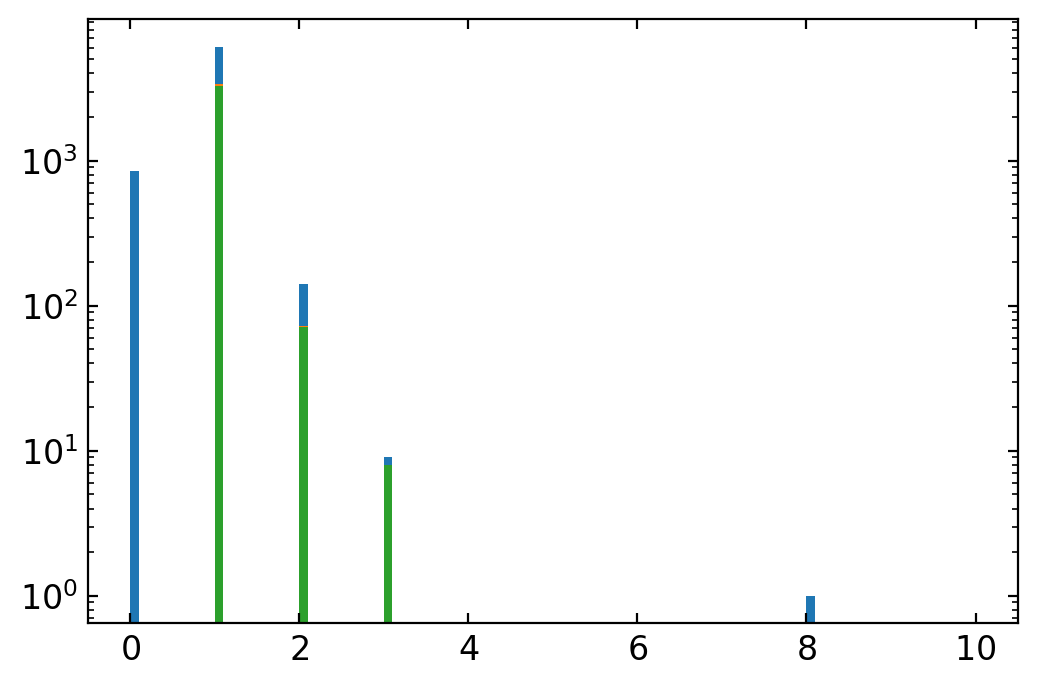

In [32]:
hist(N_reconstructible,range=(0,10));
hist(N_reconstructible[mask_floor_track_truth&mask_recon_success],range=(0,10));
hist(N_reconstructible[mask_floor_track_recon],range=(0,10));
yscale("log")

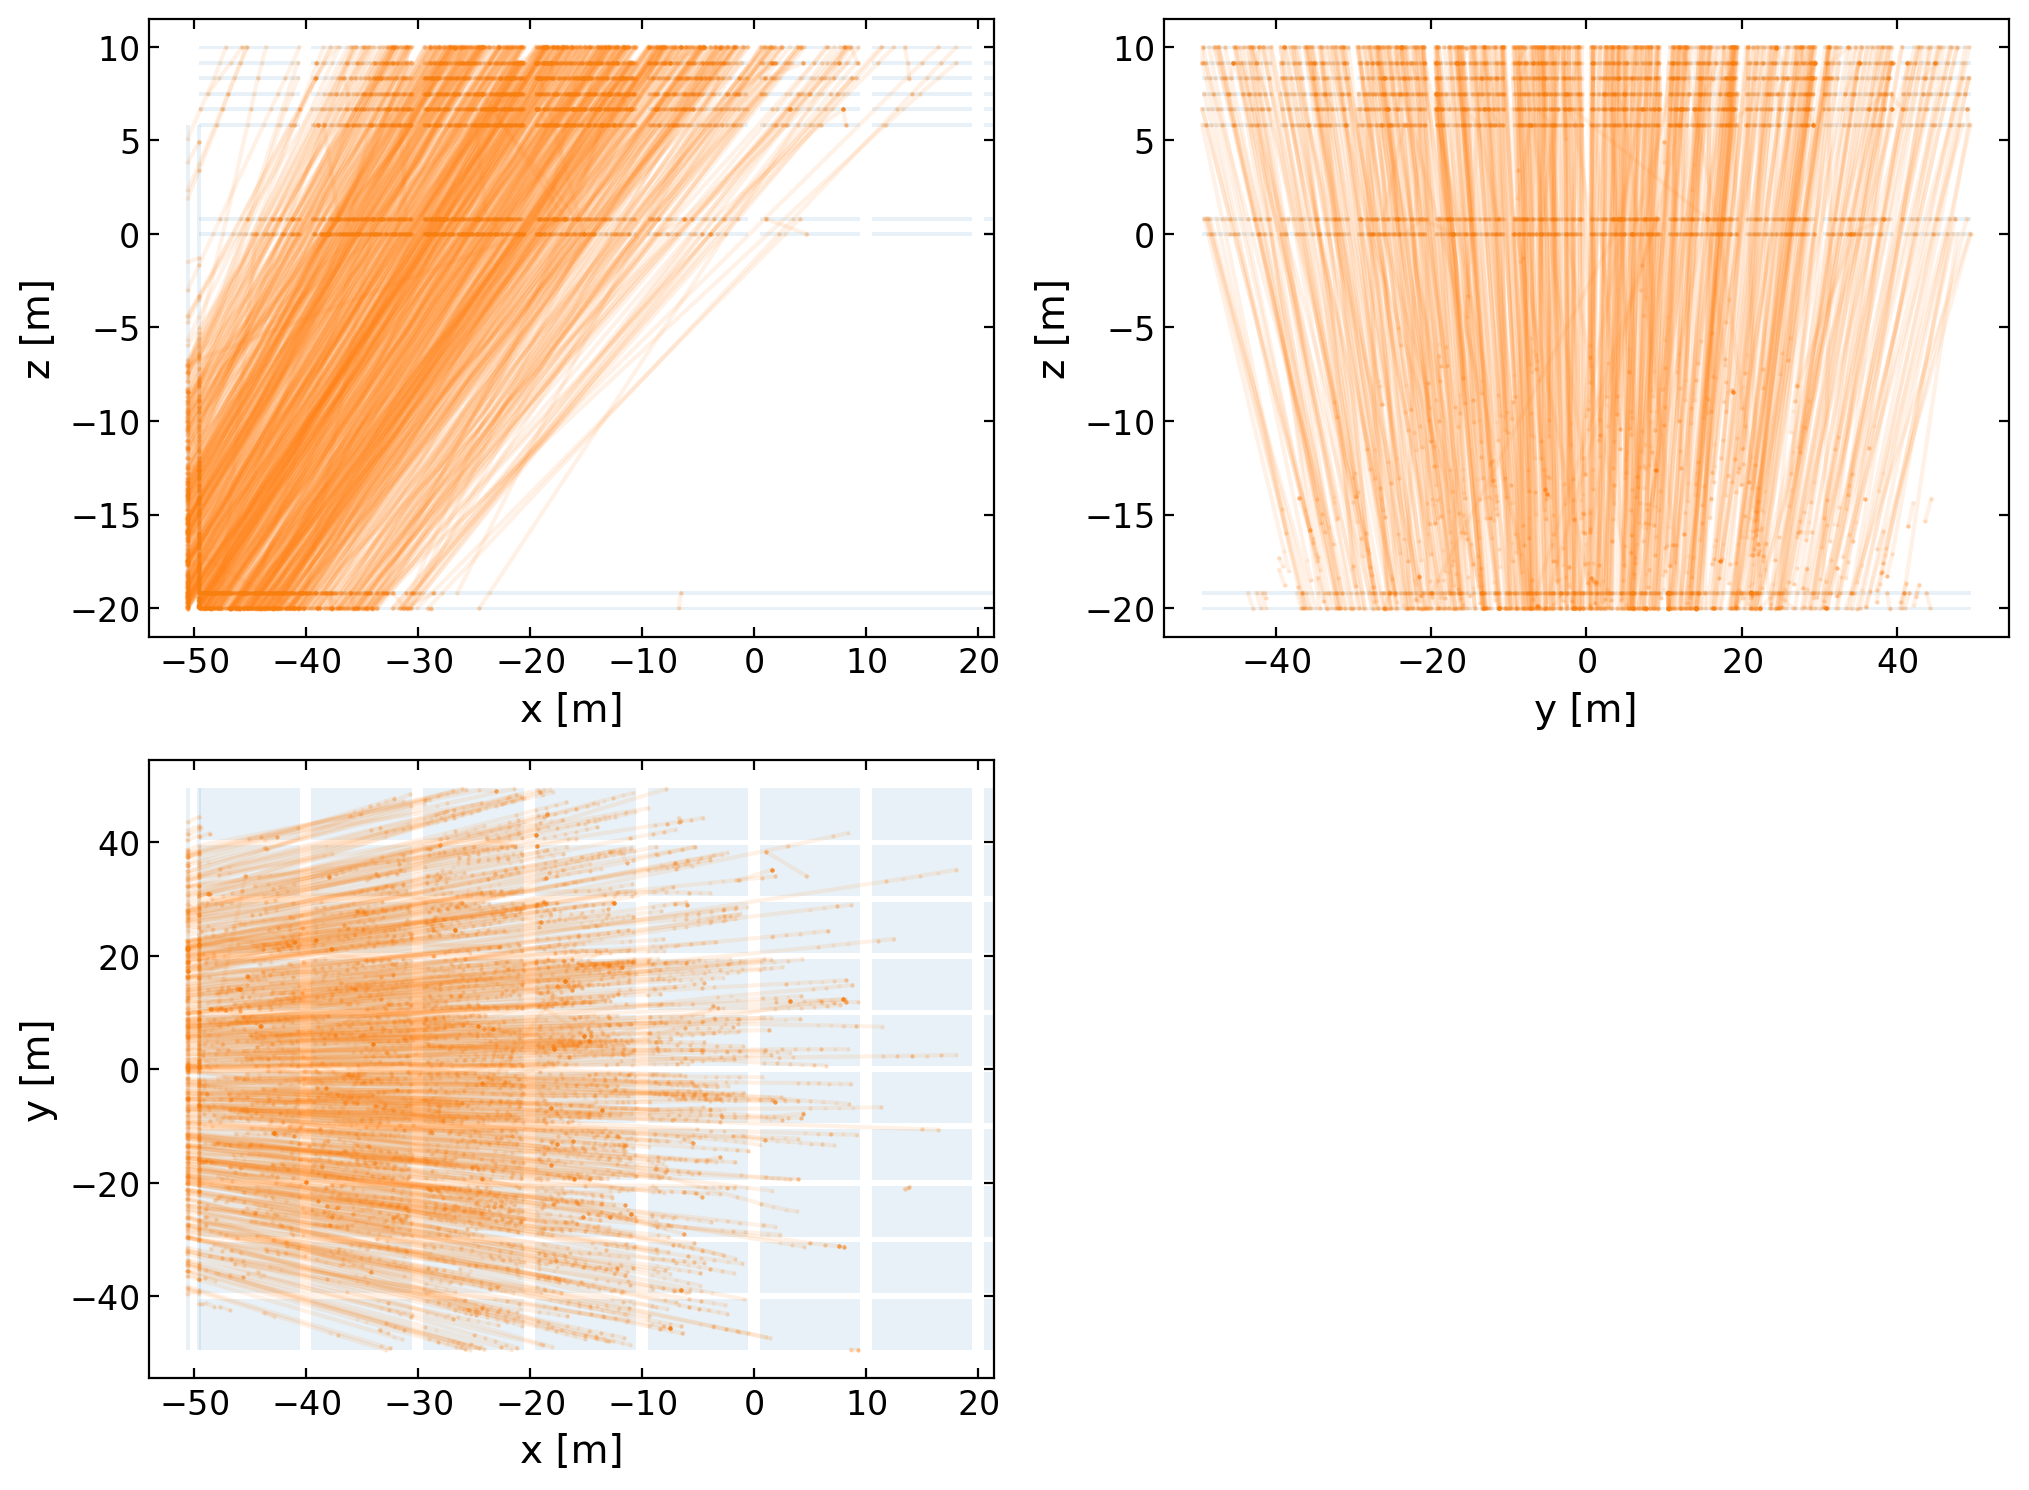

In [33]:

vis.plot_multiple_events(filenames_recon[0], tree_name, nevents=800)

In [12]:
tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]


digi_x = []
digi_y = []
digi_z = []
for i in range(nevents):
    Tree.GetEntry(i)
    digi_x.extend(util.c2list(Tree.Digi_x))
    digi_y.extend(util.c2list(Tree.Digi_y))
    digi_z.extend(util.c2list(Tree.Digi_z))


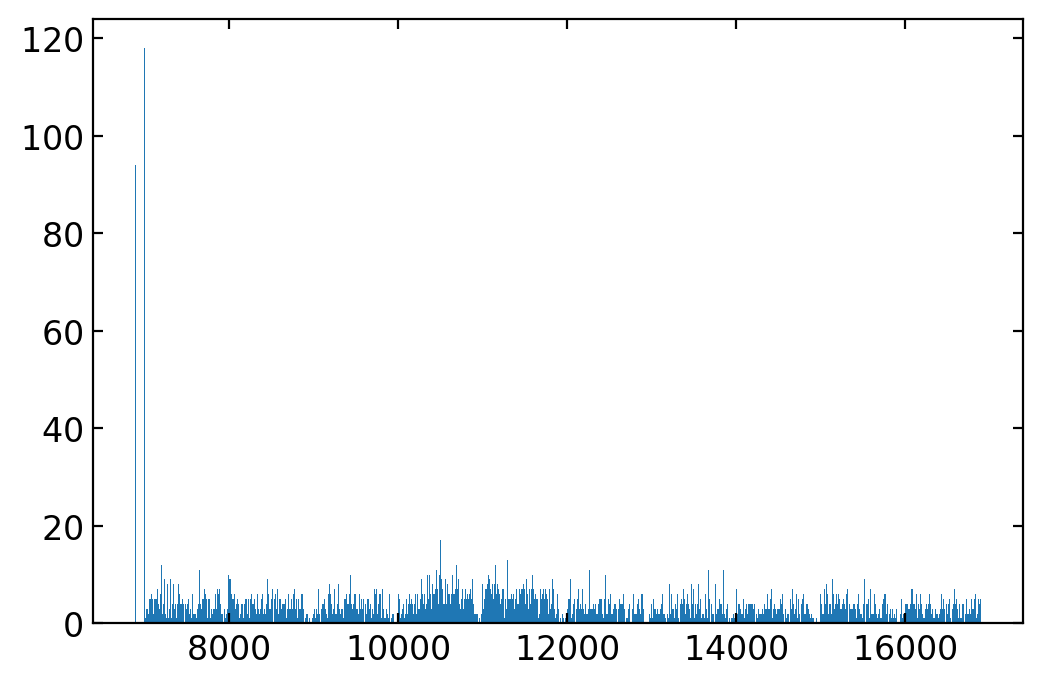

In [7]:
hist(digi_z,bins=1000);

In [19]:
reload(vis)

<module 'visualization' from '/project/6035200/tomren/jupyter/tracker_6layers/visualization.py'>

===========================Event 0==============================


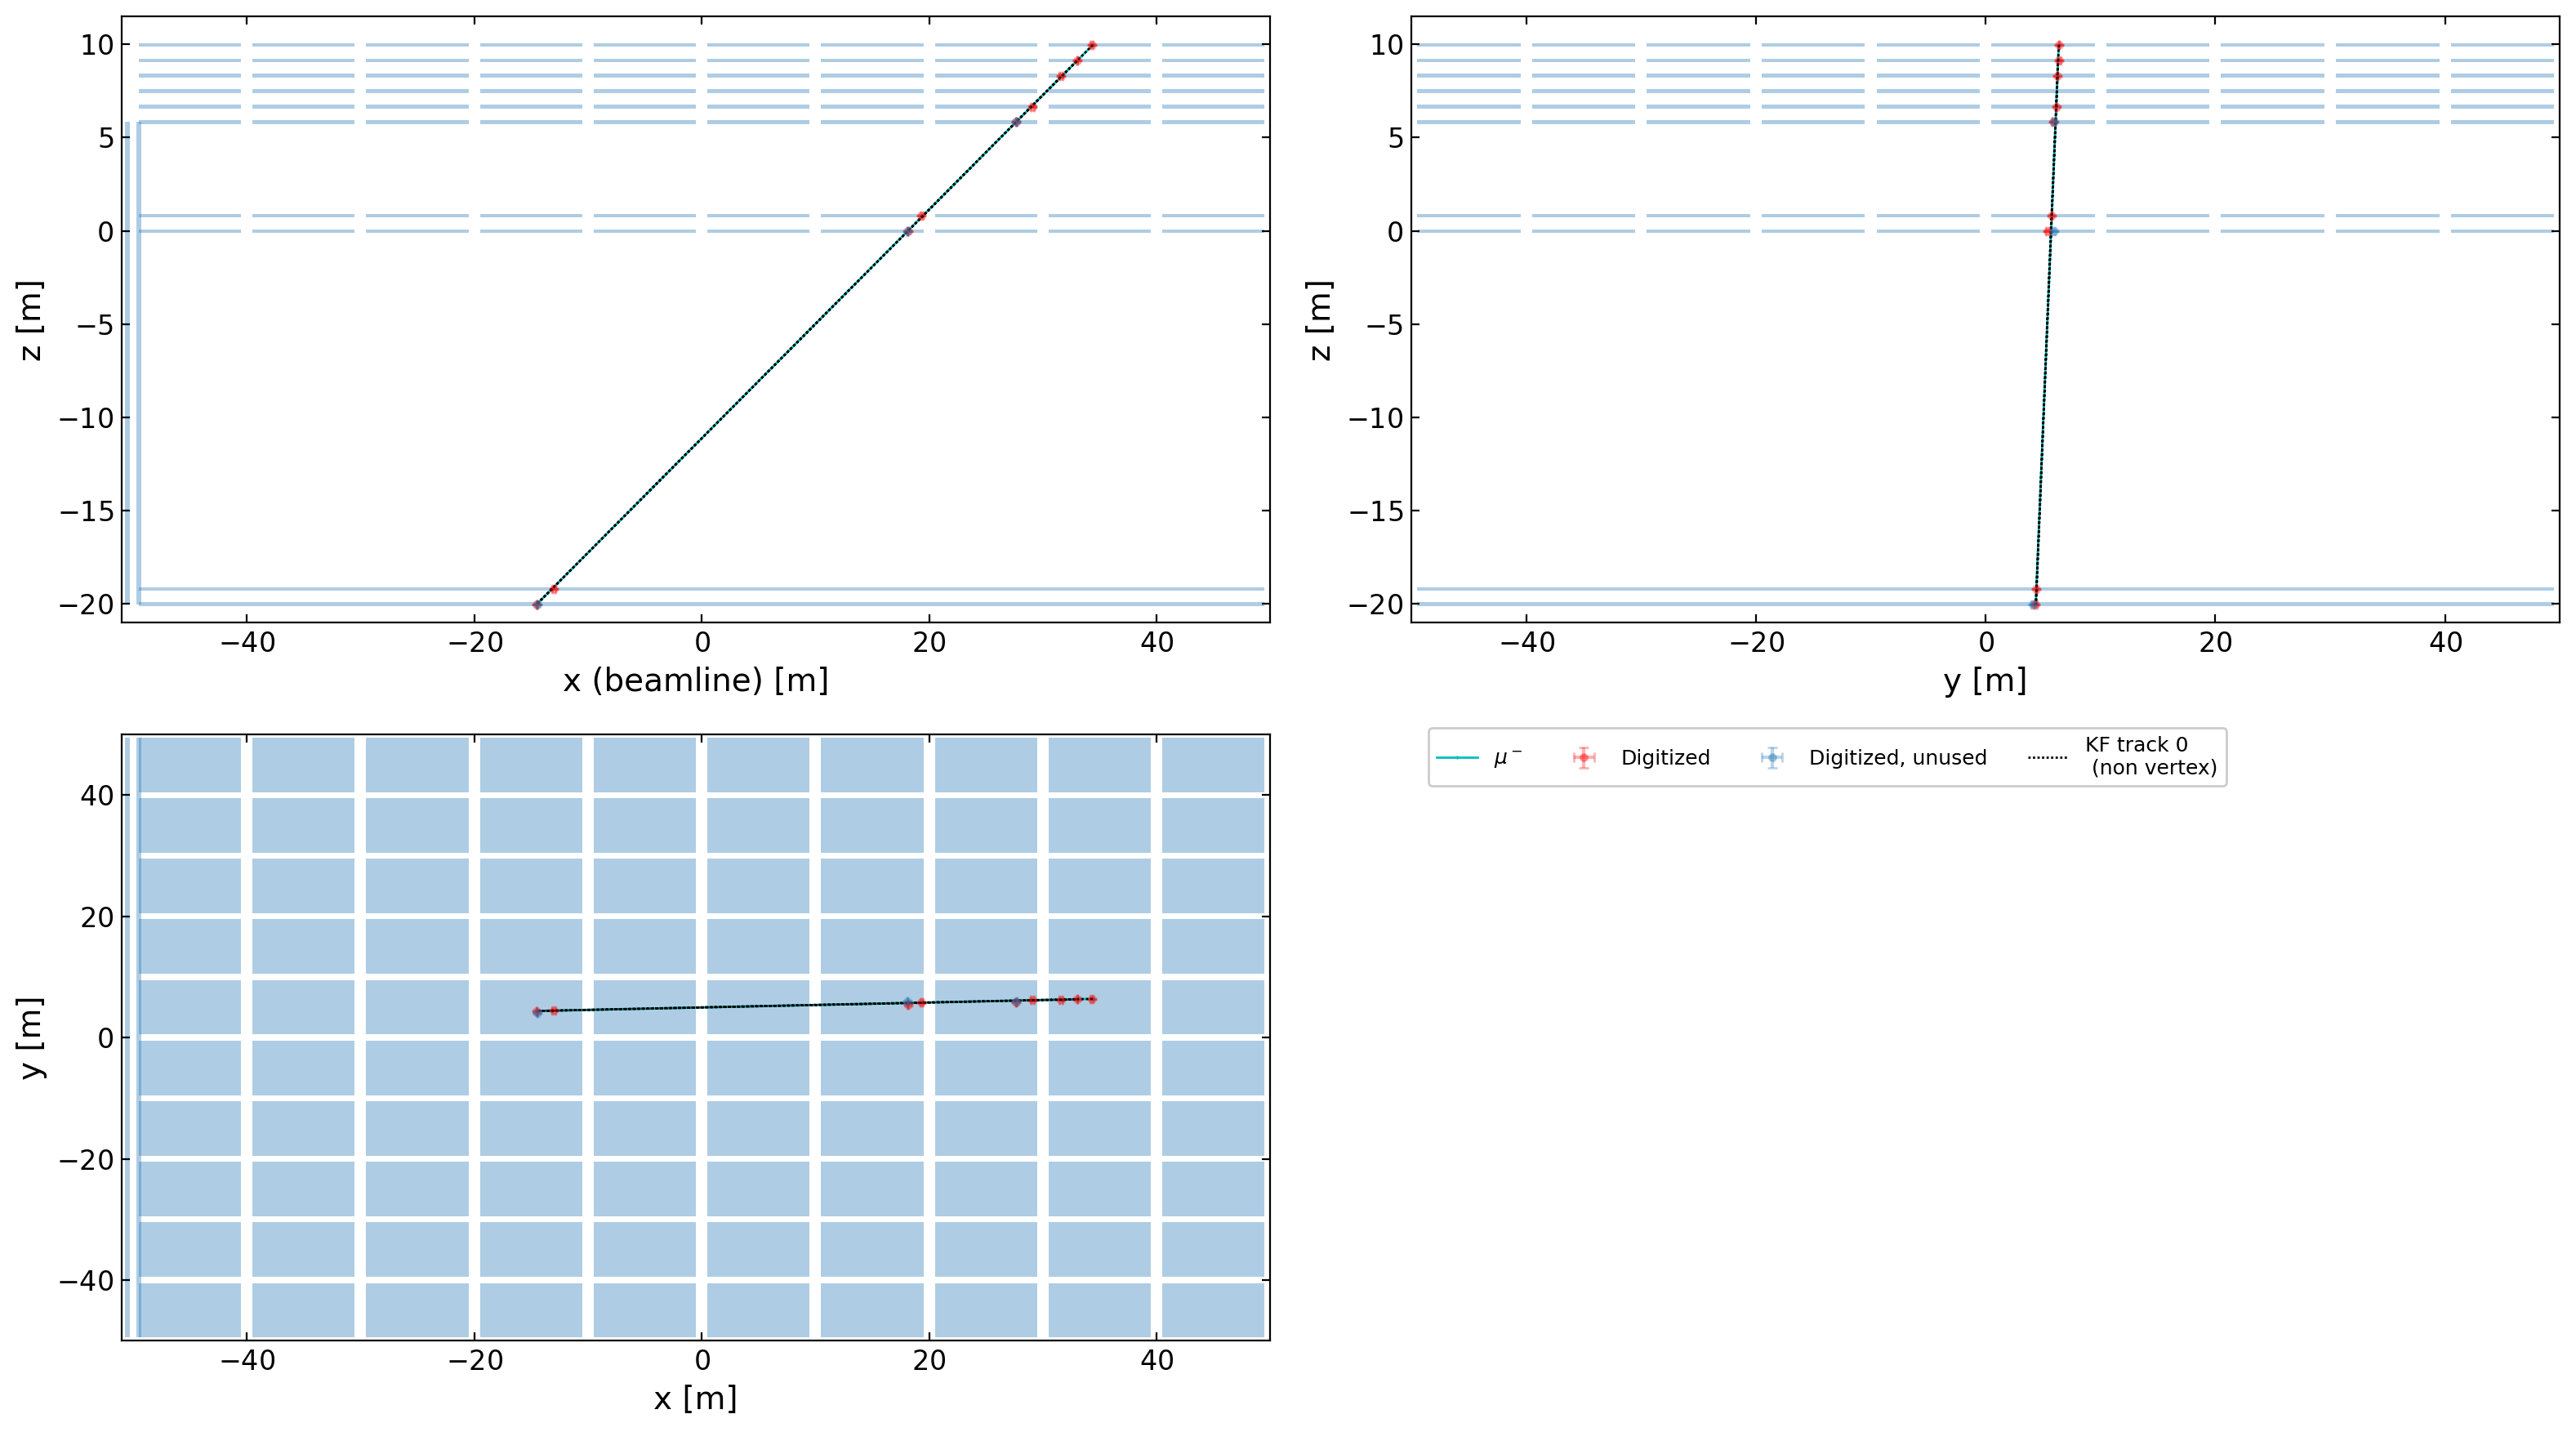

In [8]:

ev = event.Event(filename, 0)

for i in range(1):
    print(f"===========================Event {i}==============================")
    ev.EventNumber=i
    ev.Tree.GetEntry(ev.EventNumber)
    if ev.Tree.Digi_x.size()<4:
        continue

    fig,axs=plt.subplots(2,2,figsize=(16,9))
    # fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
    # fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True);
    
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
    fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True, disp_vertex_track_extension=True);    
    # print(util.unzip(ev.Tree.Vertex_k_m_trackIndices))
    show()

In [11]:
mask_plot = ~mask_recon_success&mask_reconstructible

mask_plot = (mask_floor_track_truth&mask_recon_success)&(~np.array(mask_floor_track_recon))

mask_plot = ~(mask_floor_track_recon|mask_wall_track_recon) & mask_recon_success


mask_plot = (mask_floor_track_truth|mask_wall_track_truth) &mask_recon_success &(~(mask_floor_track_recon|mask_wall_track_recon)) #&(N_reconstructible>=2)

inds_plot = np.flatnonzero(mask_plot)
print(len(inds_plot))

22


===========================Event 191==============================


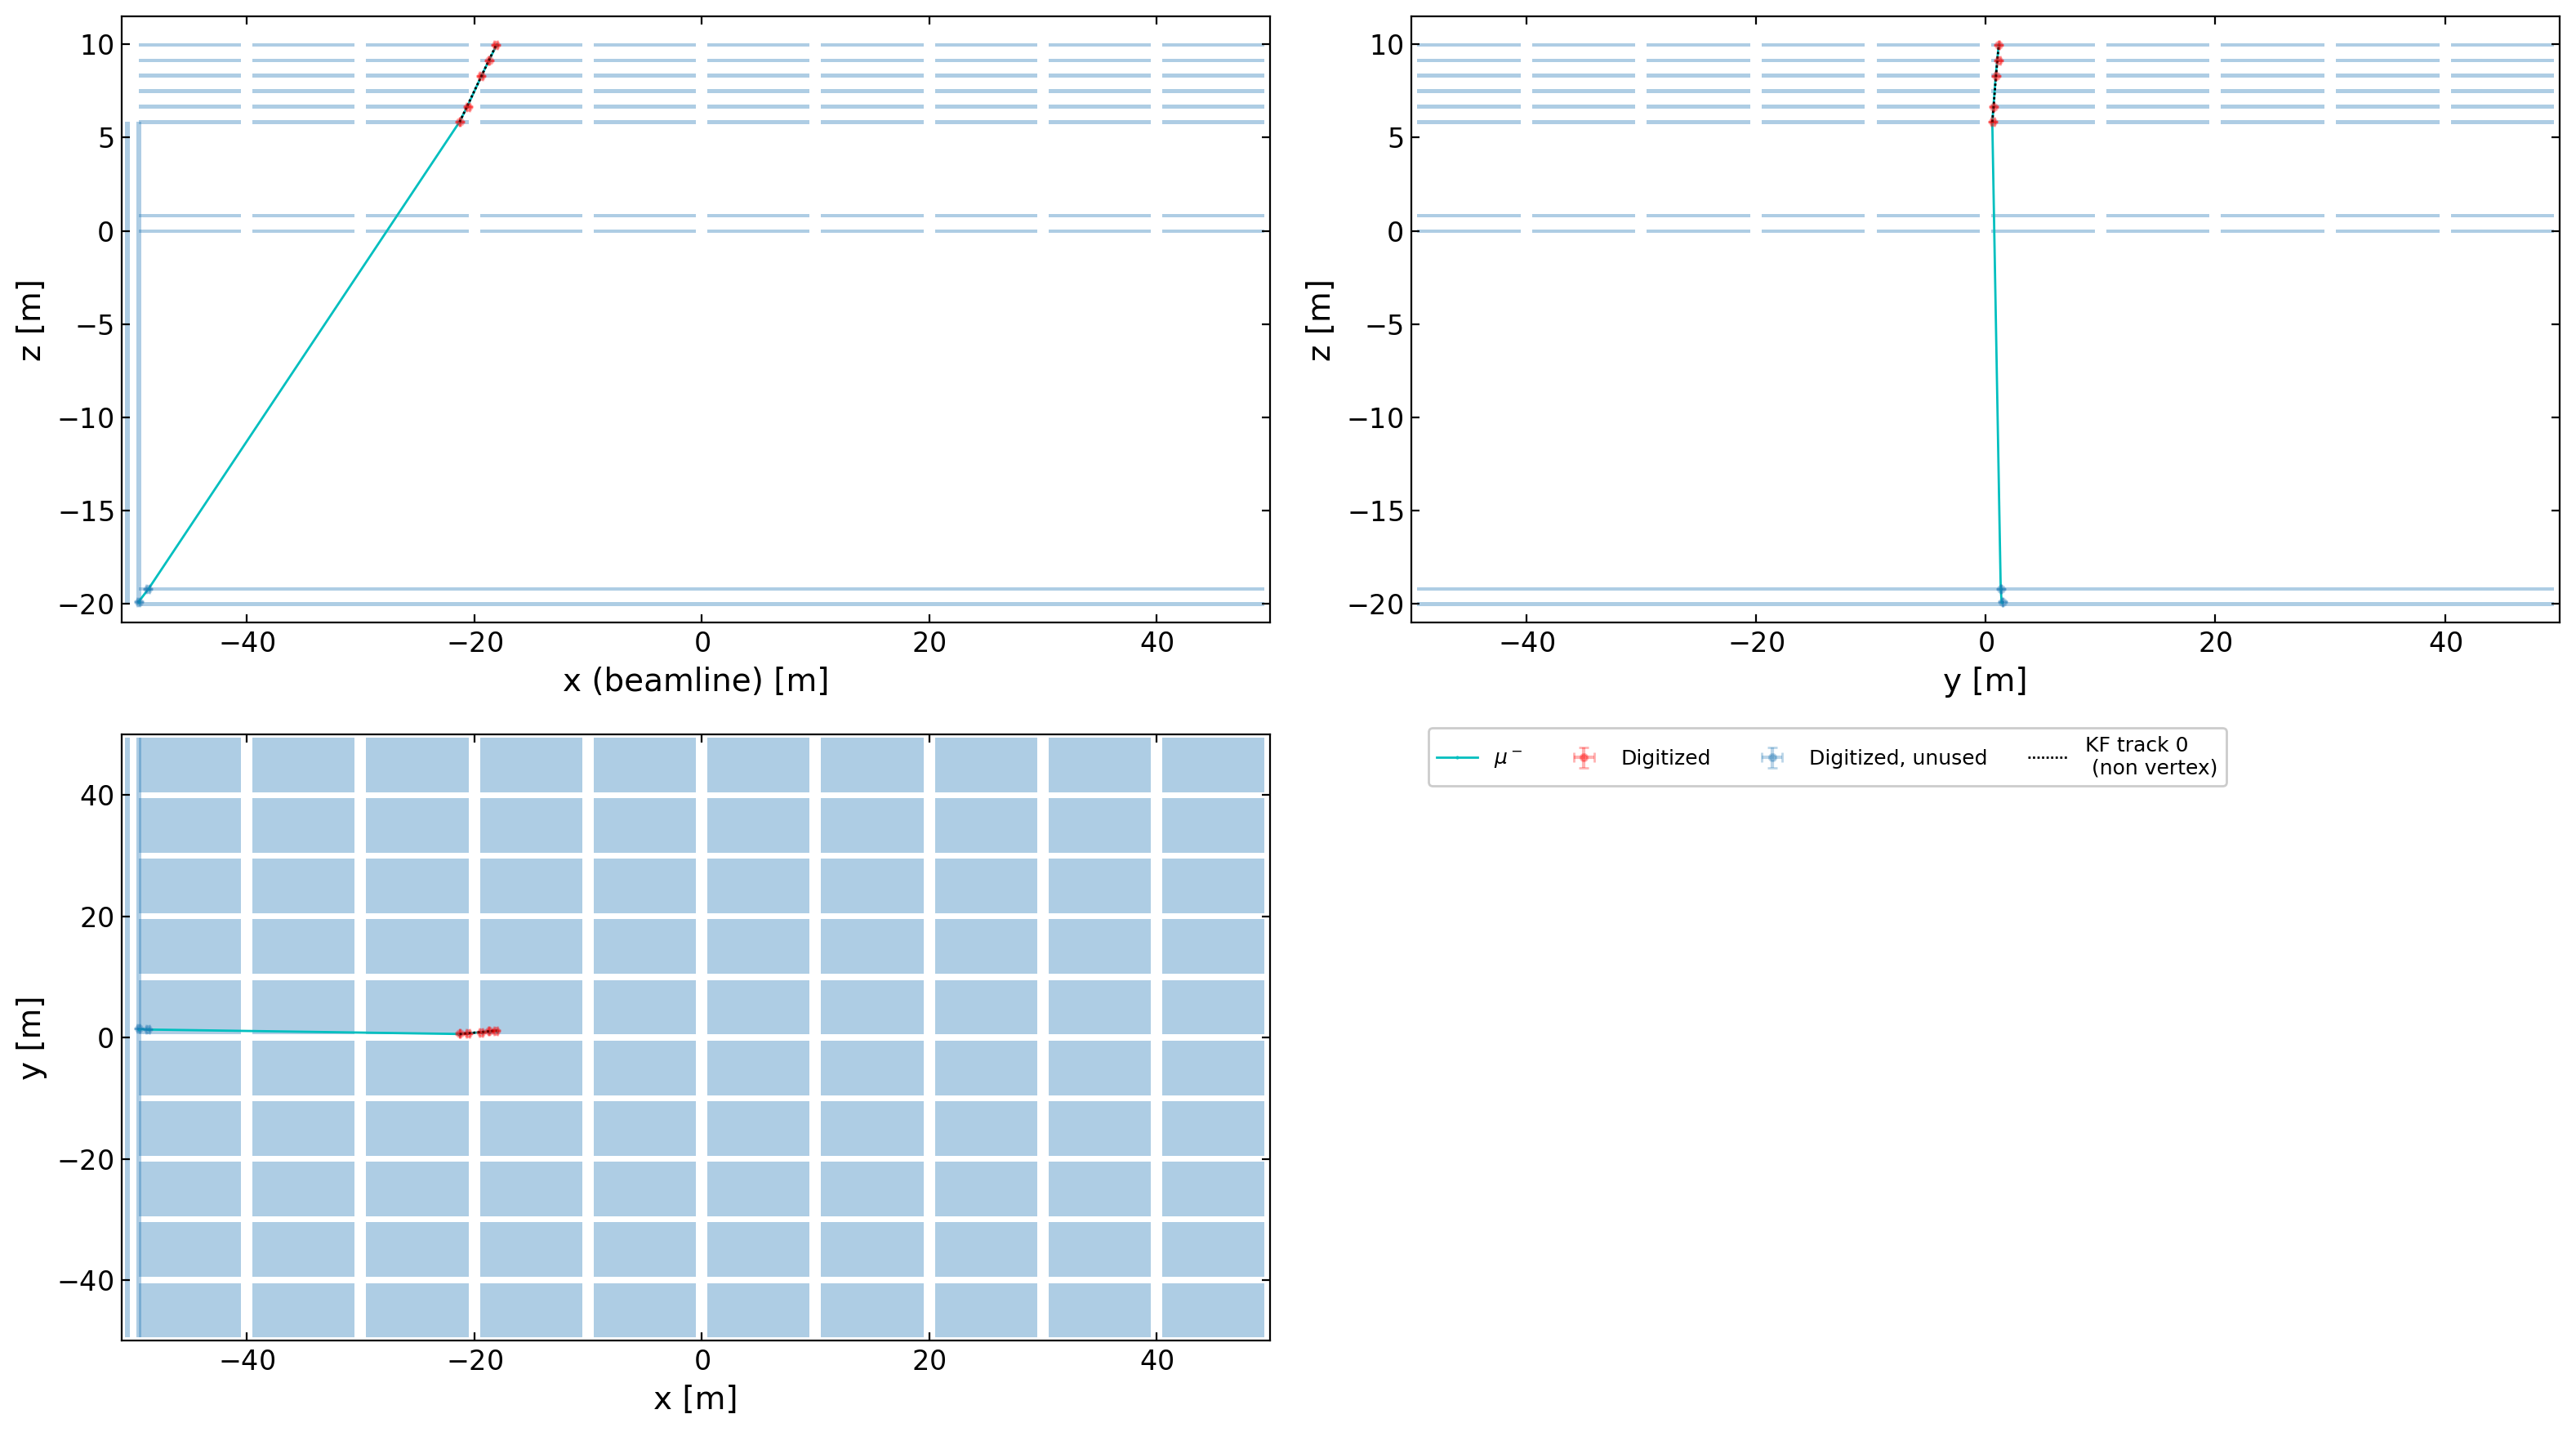

===========================Event 661==============================


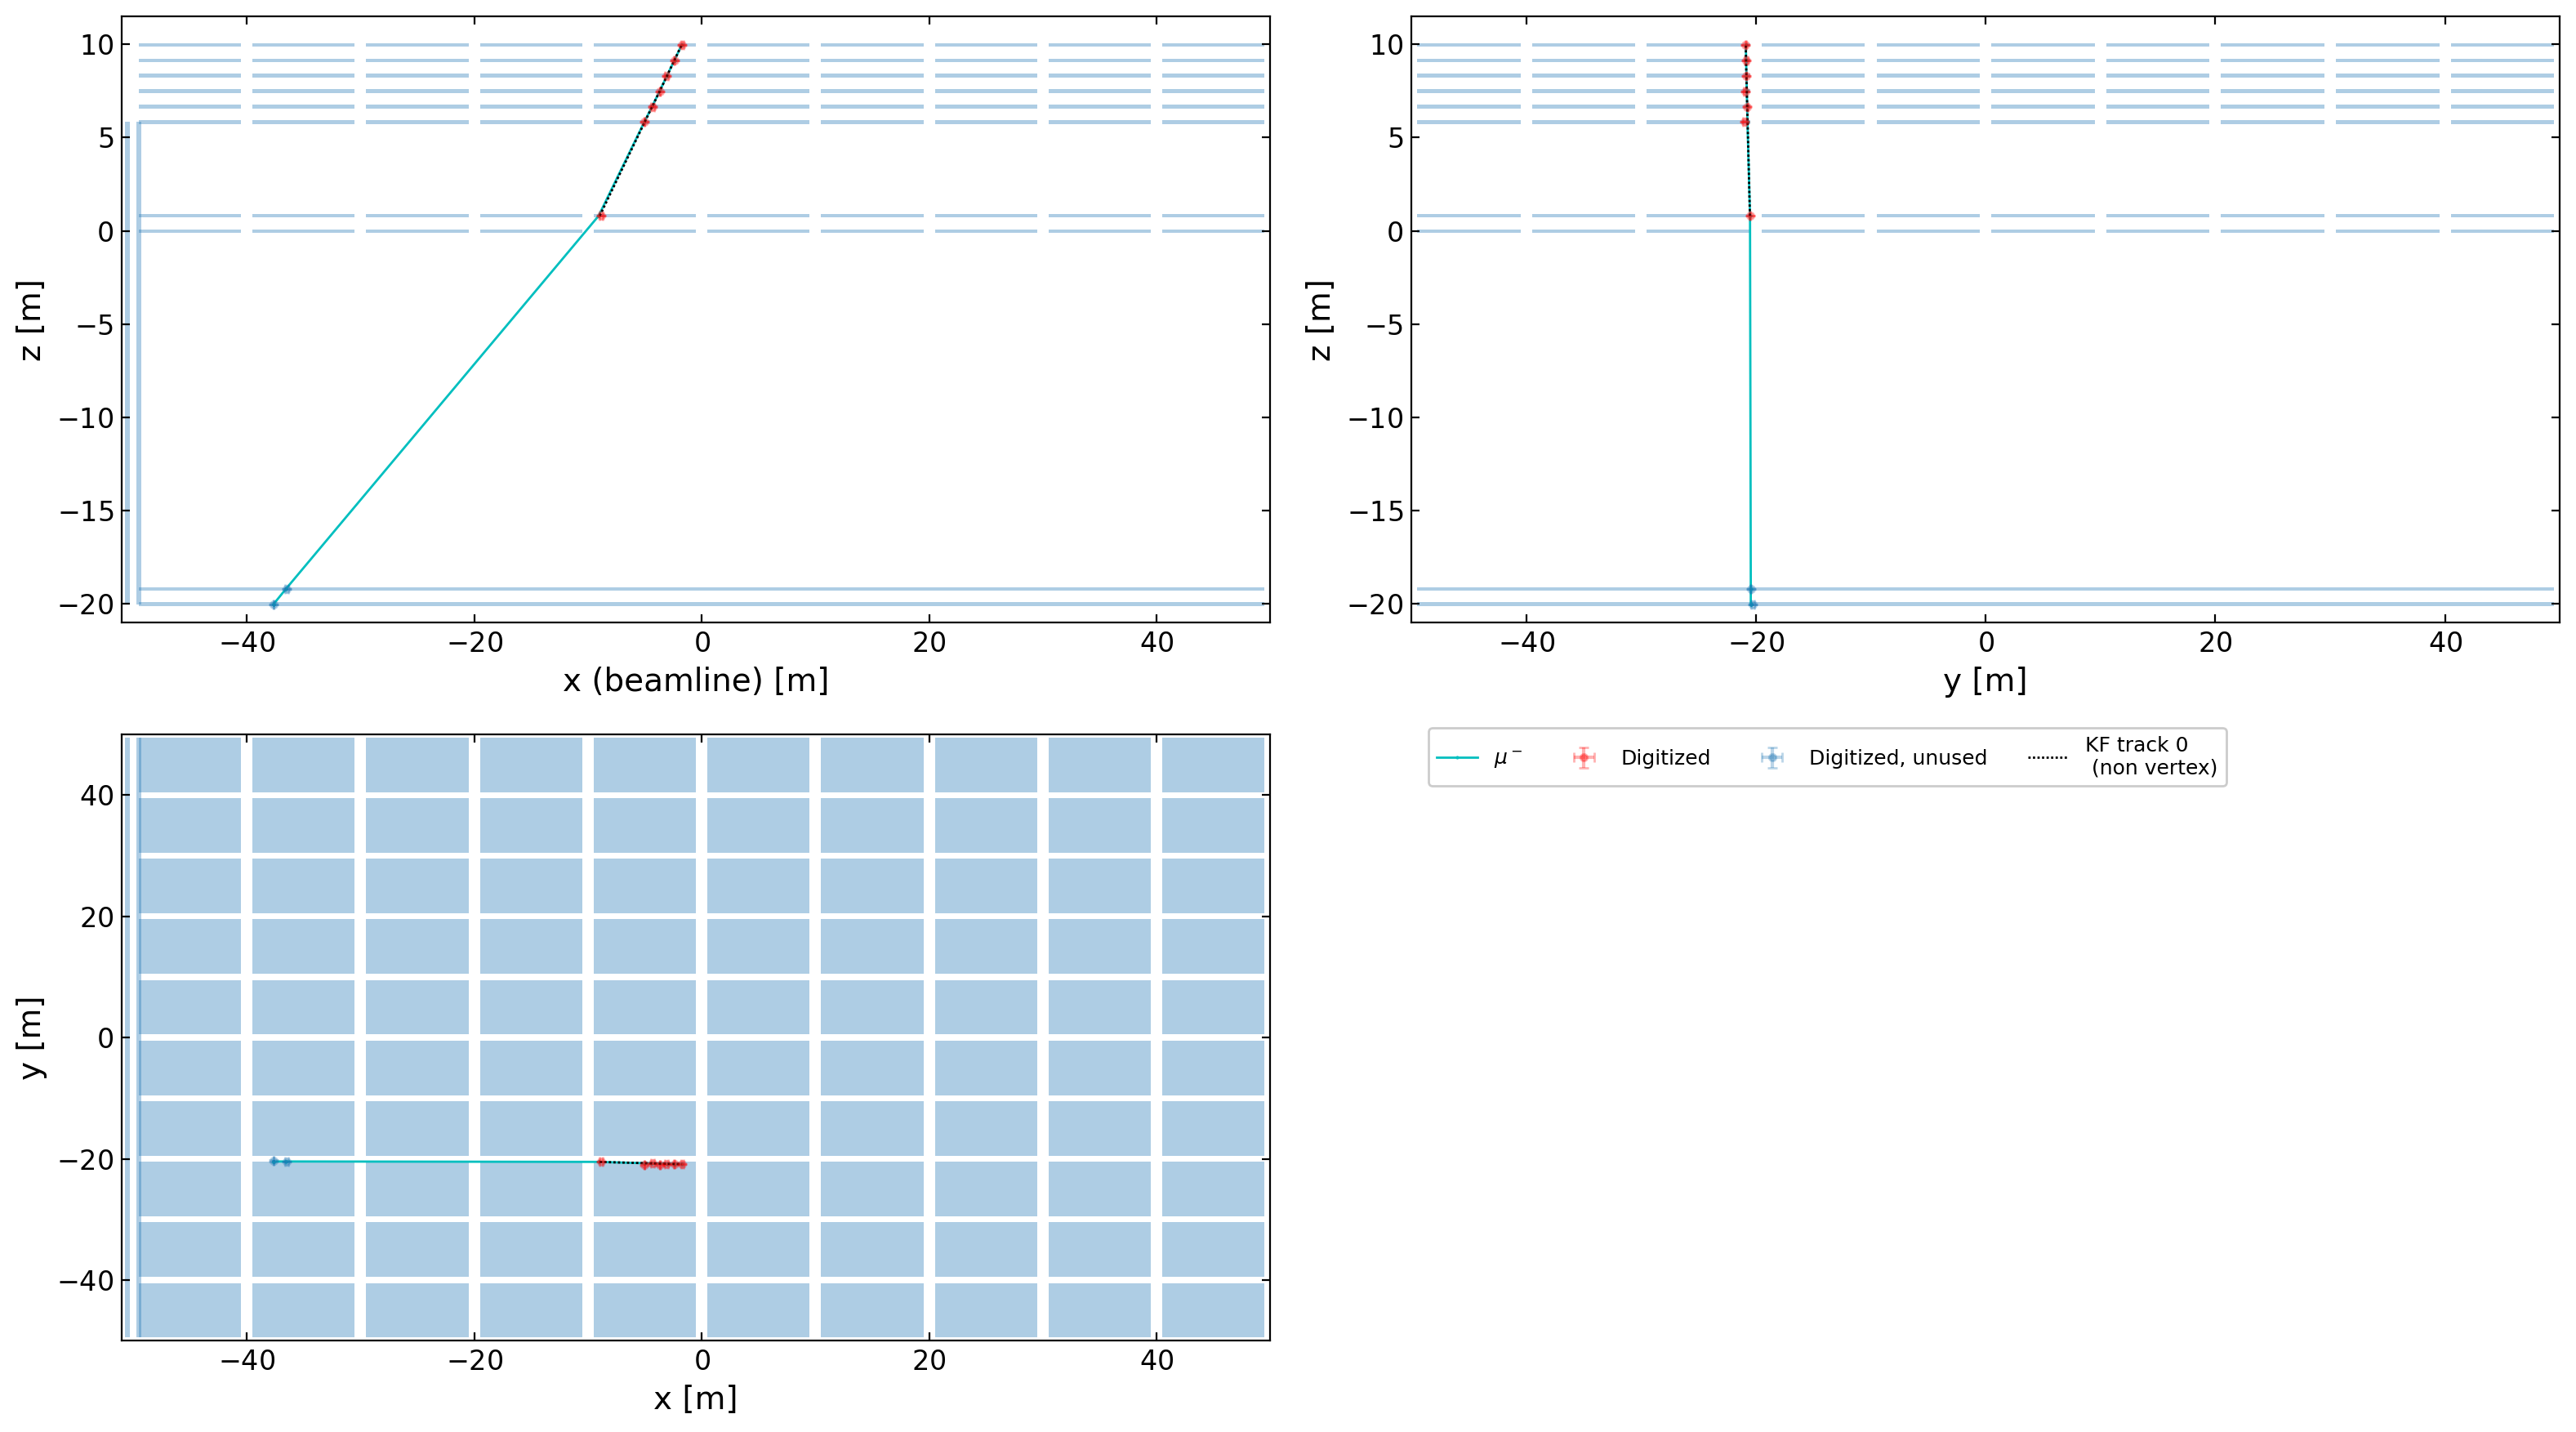

===========================Event 678==============================


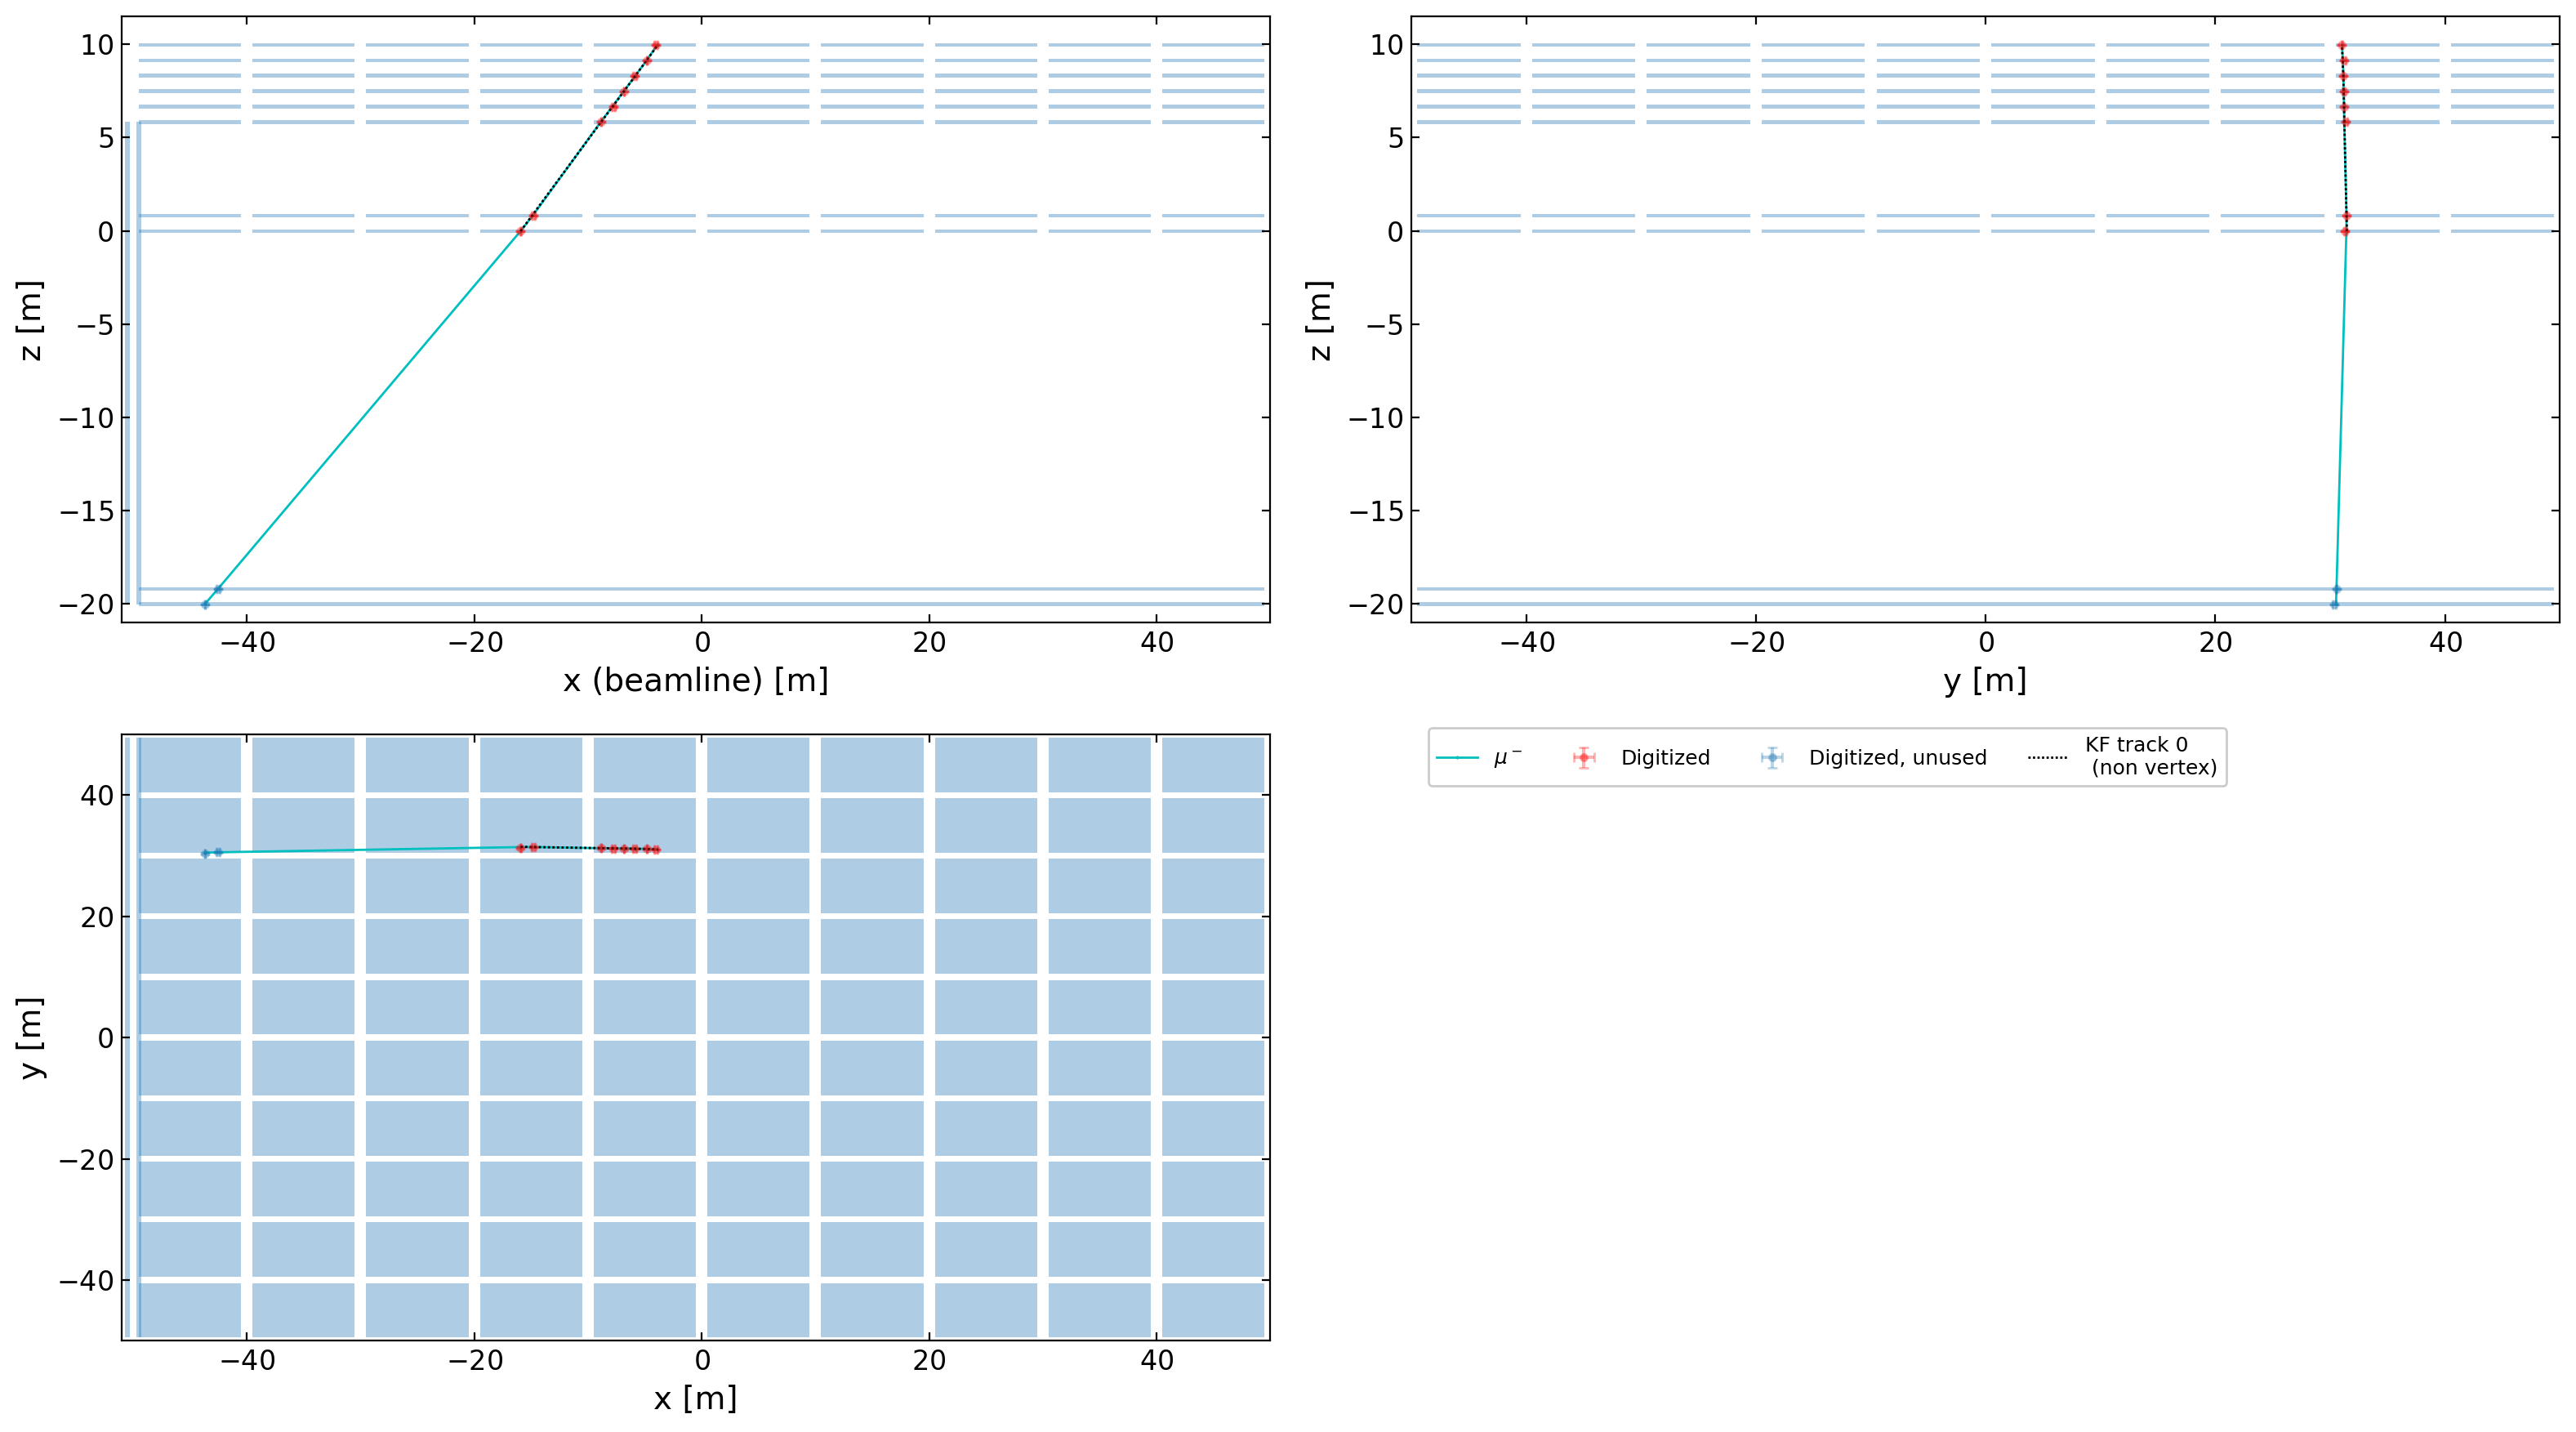

===========================Event 1074==============================


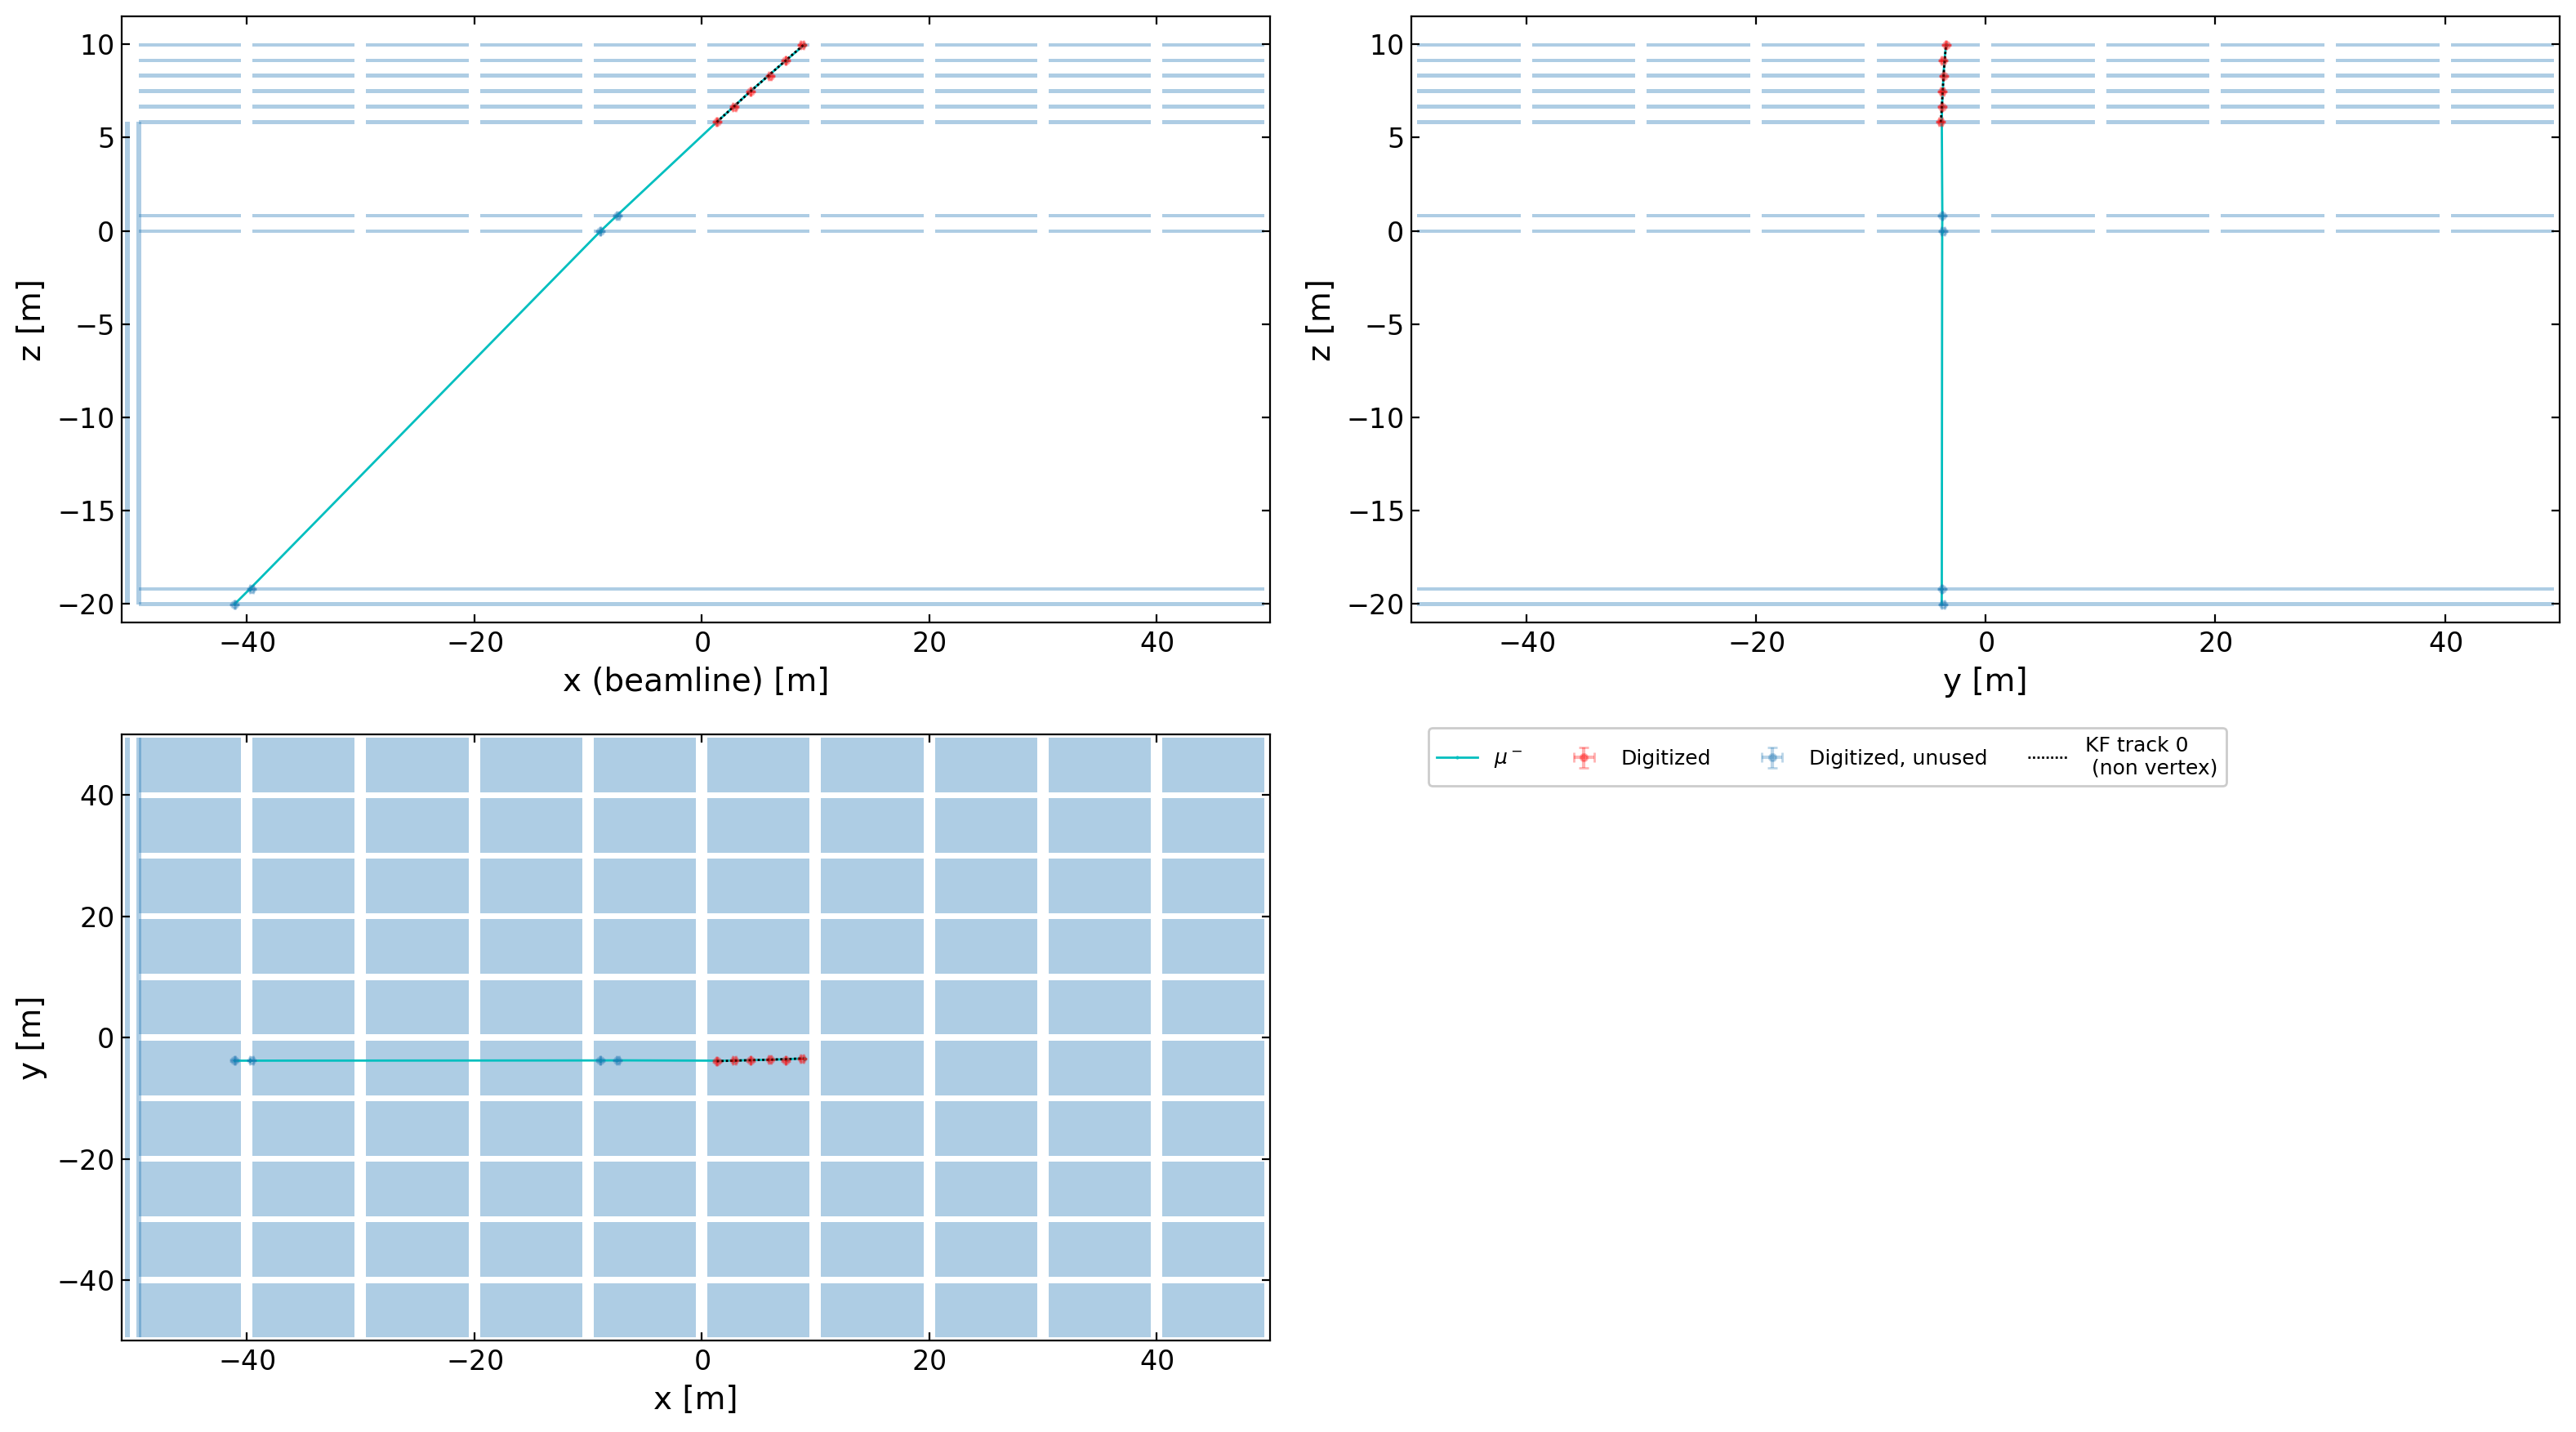

===========================Event 1239==============================


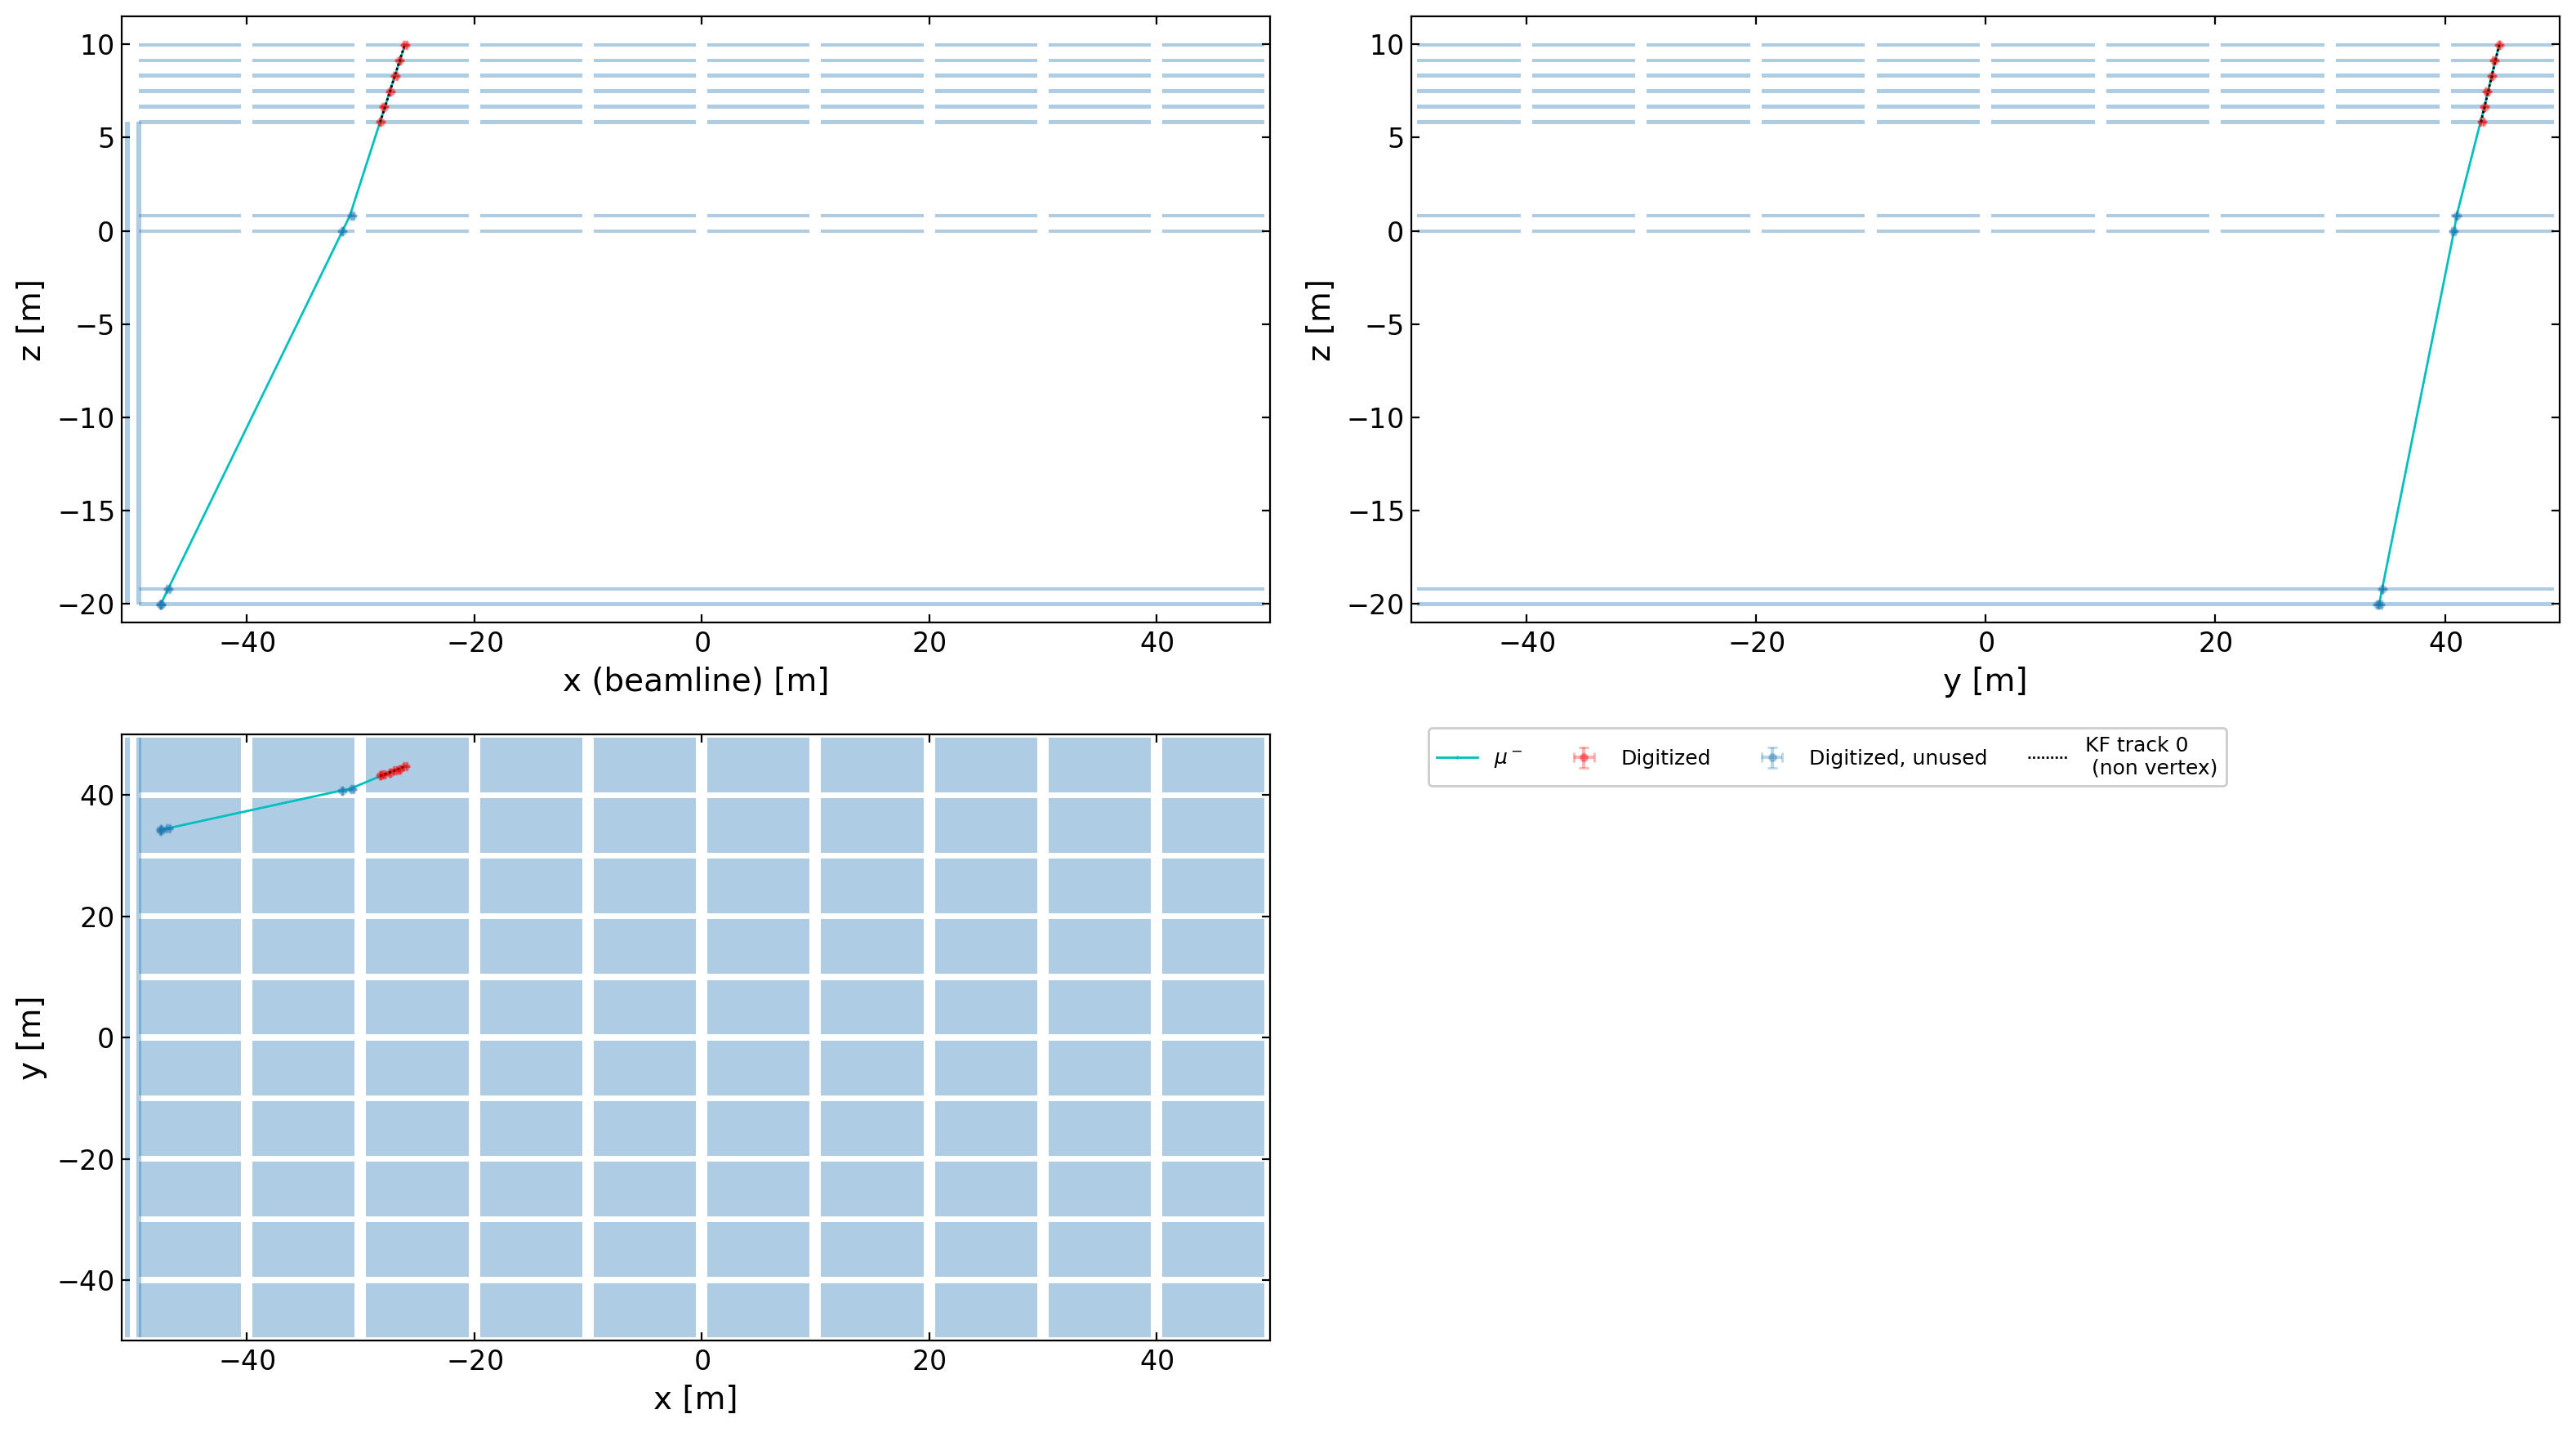

===========================Event 1333==============================


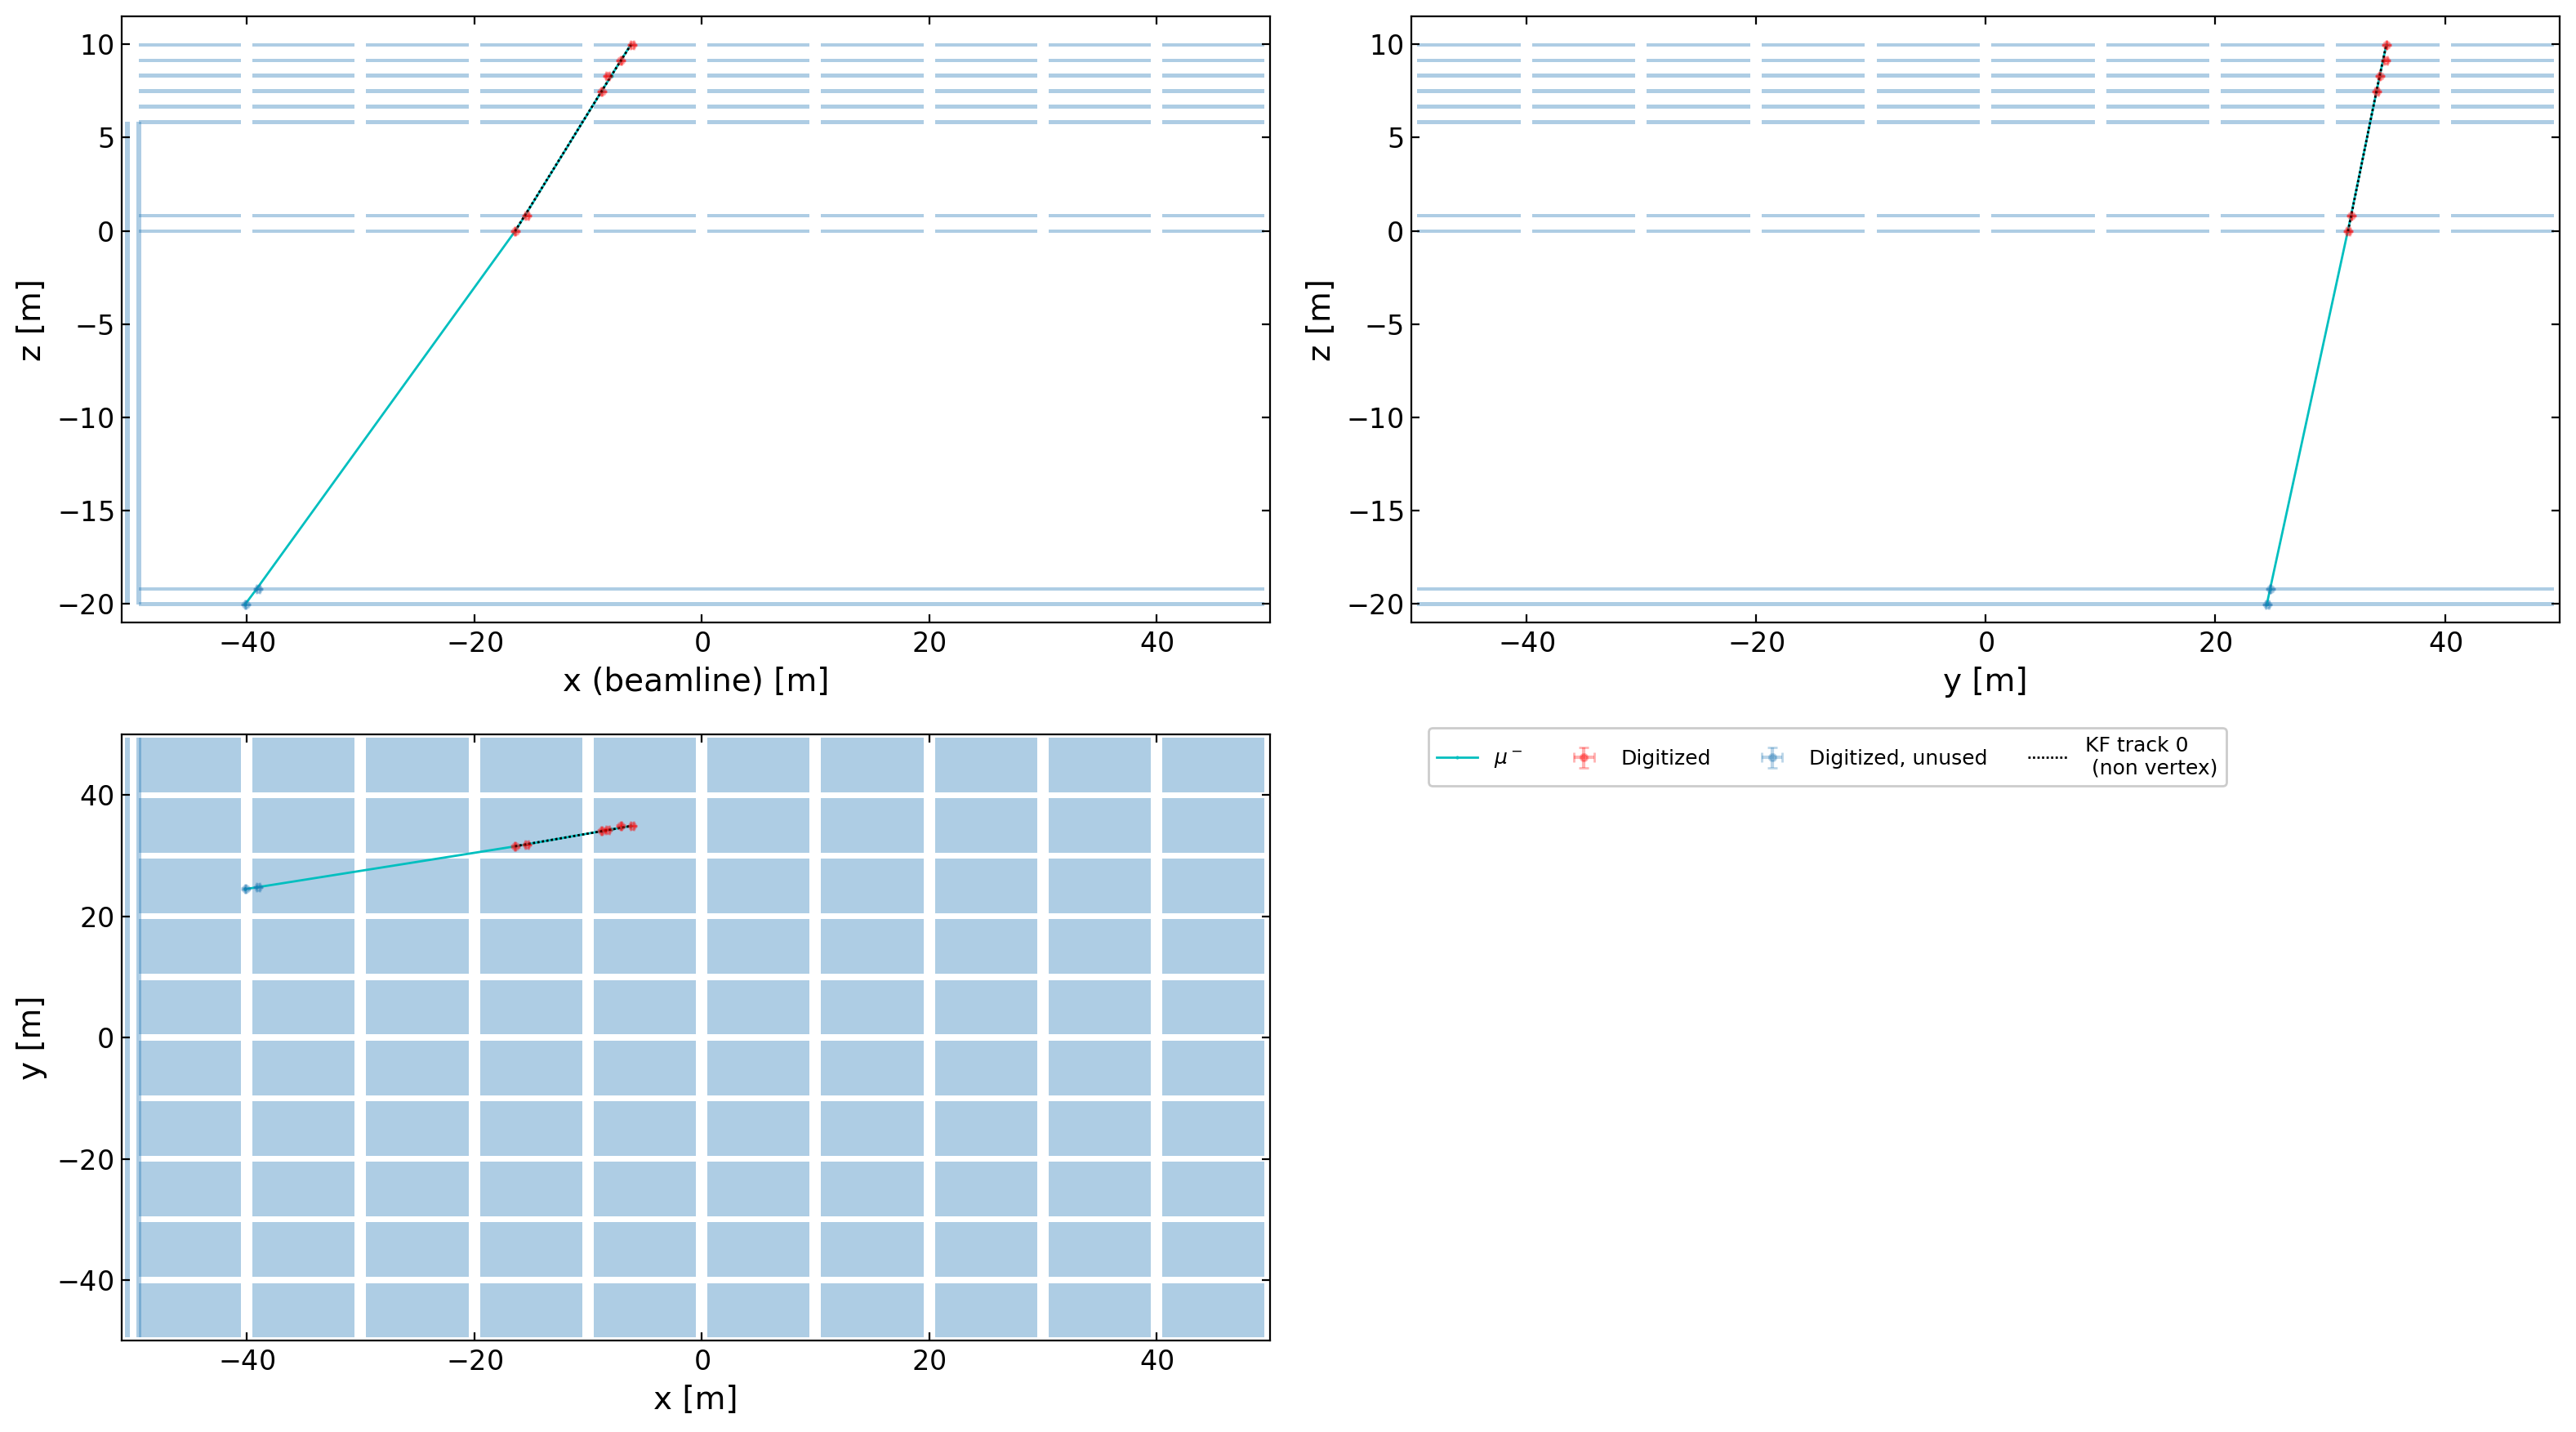

===========================Event 1507==============================


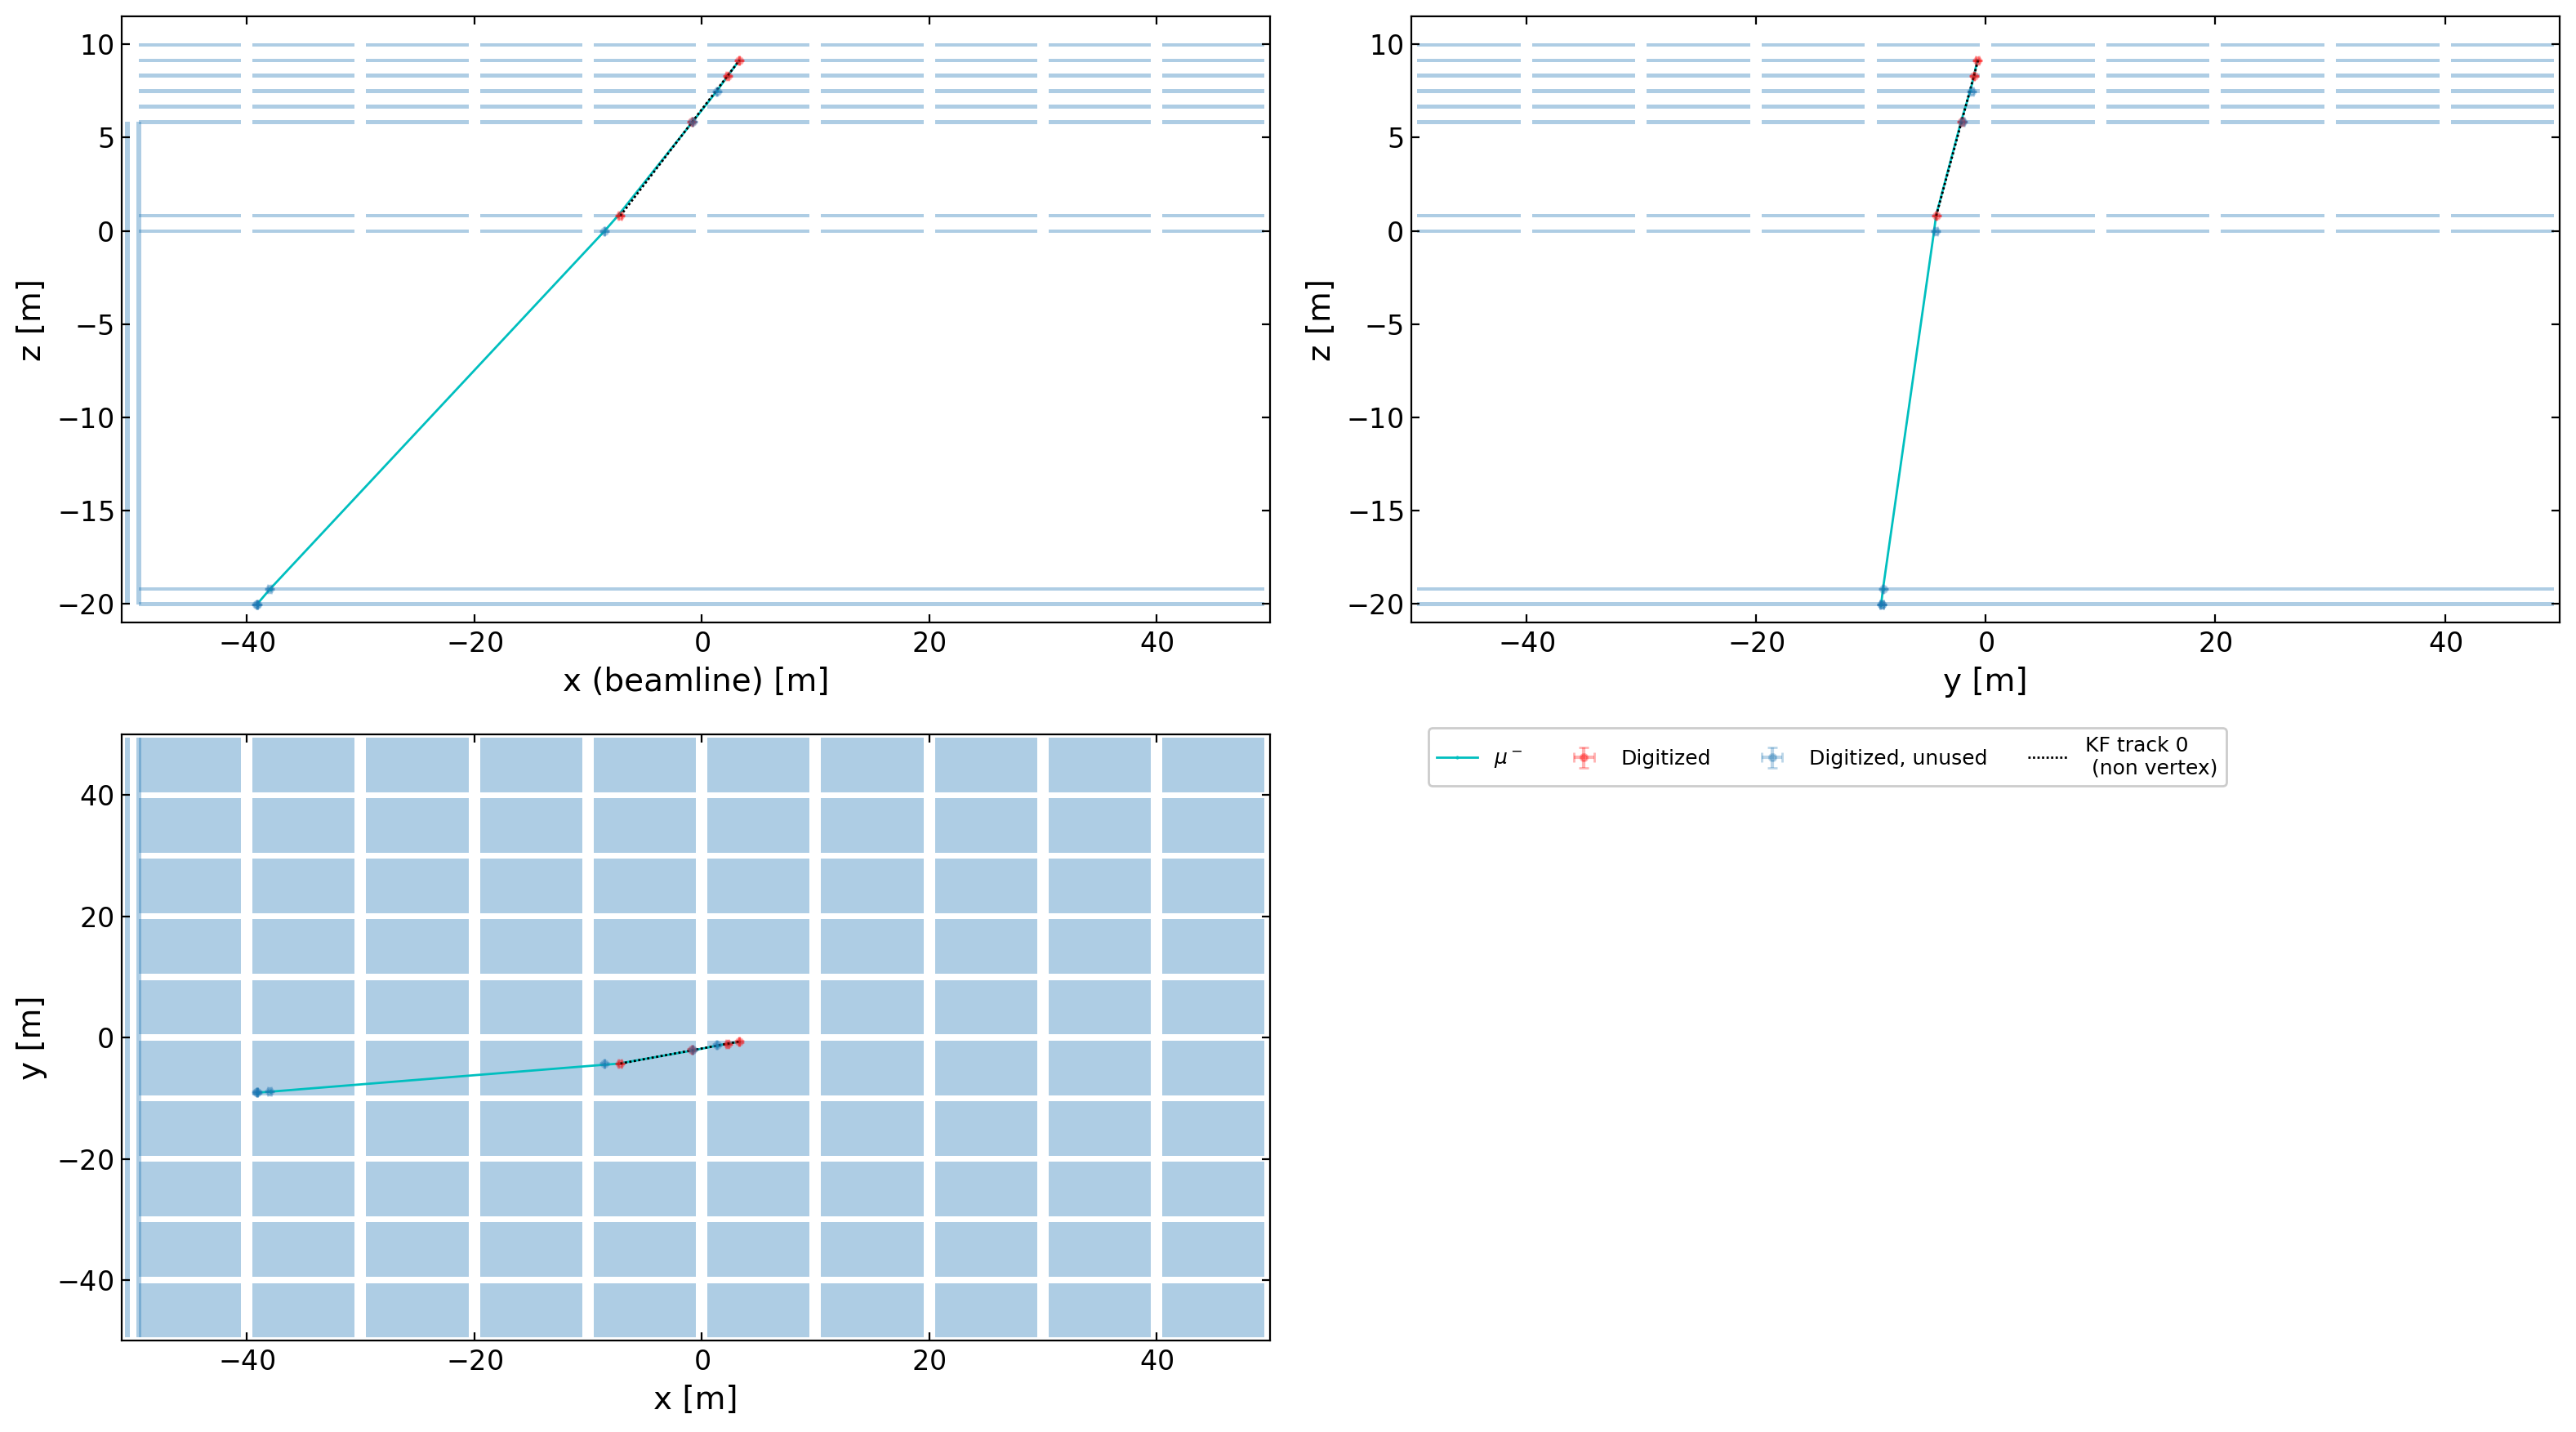

===========================Event 1588==============================


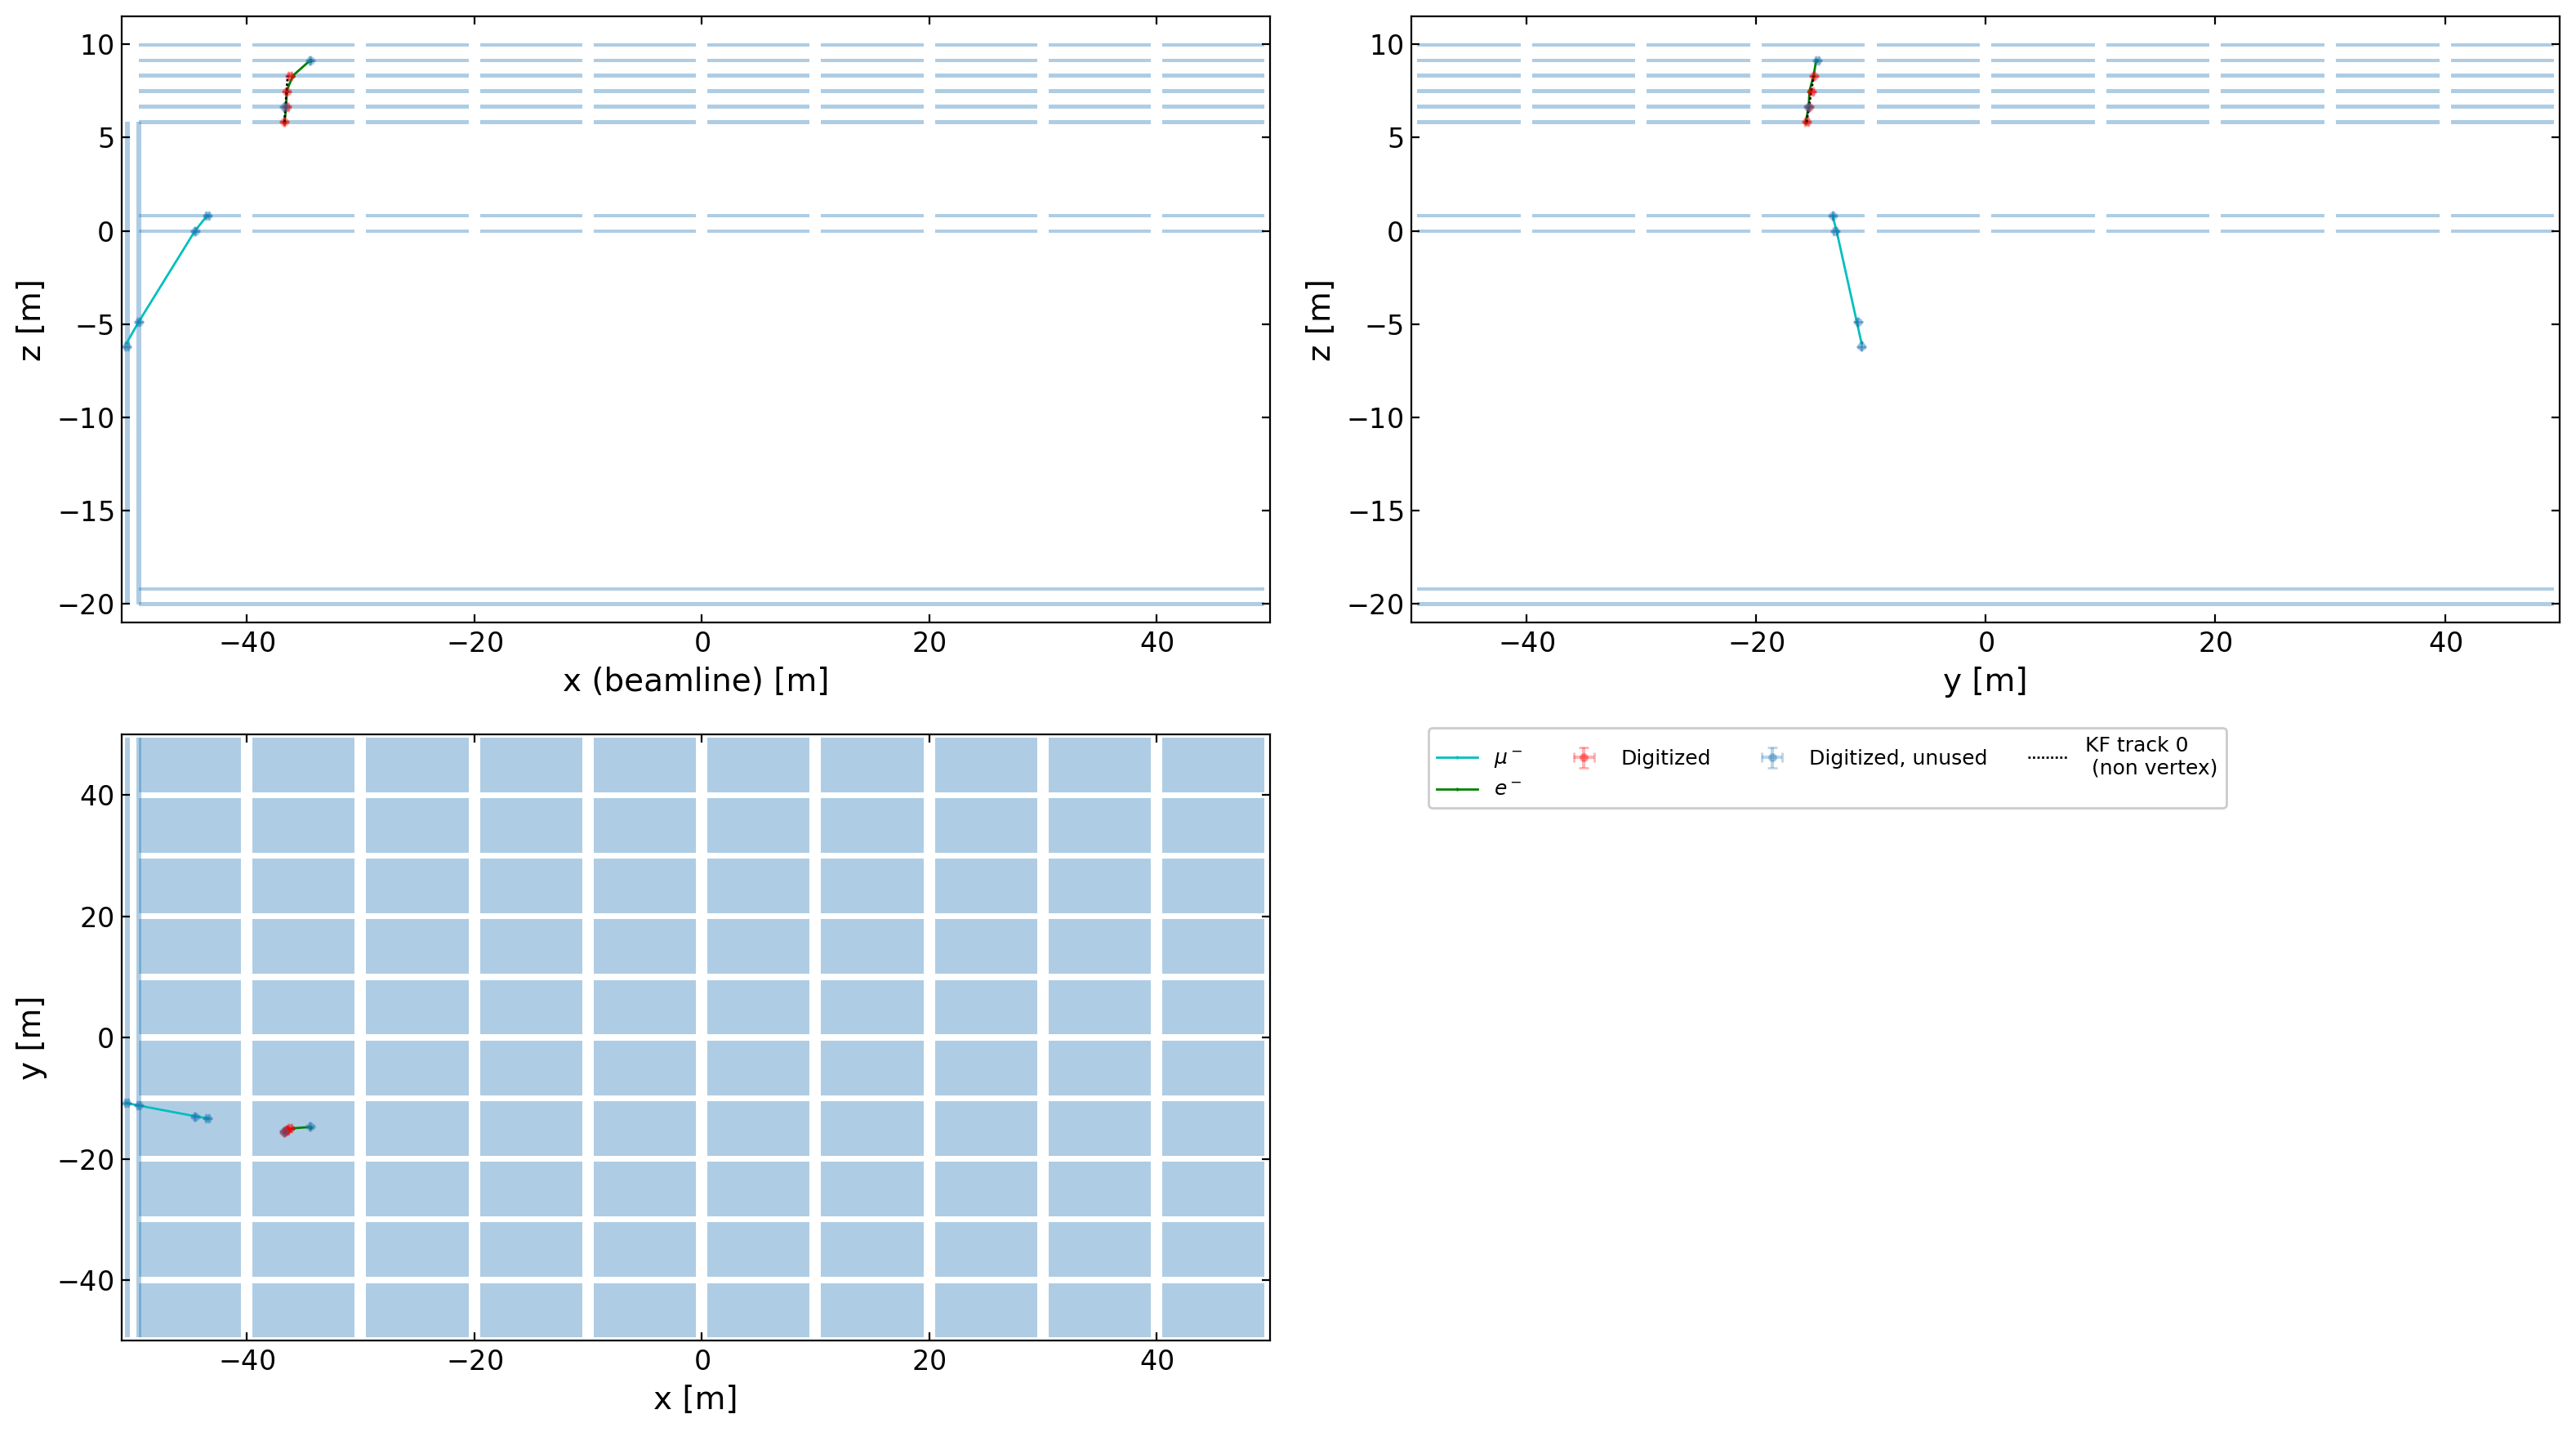

===========================Event 2263==============================


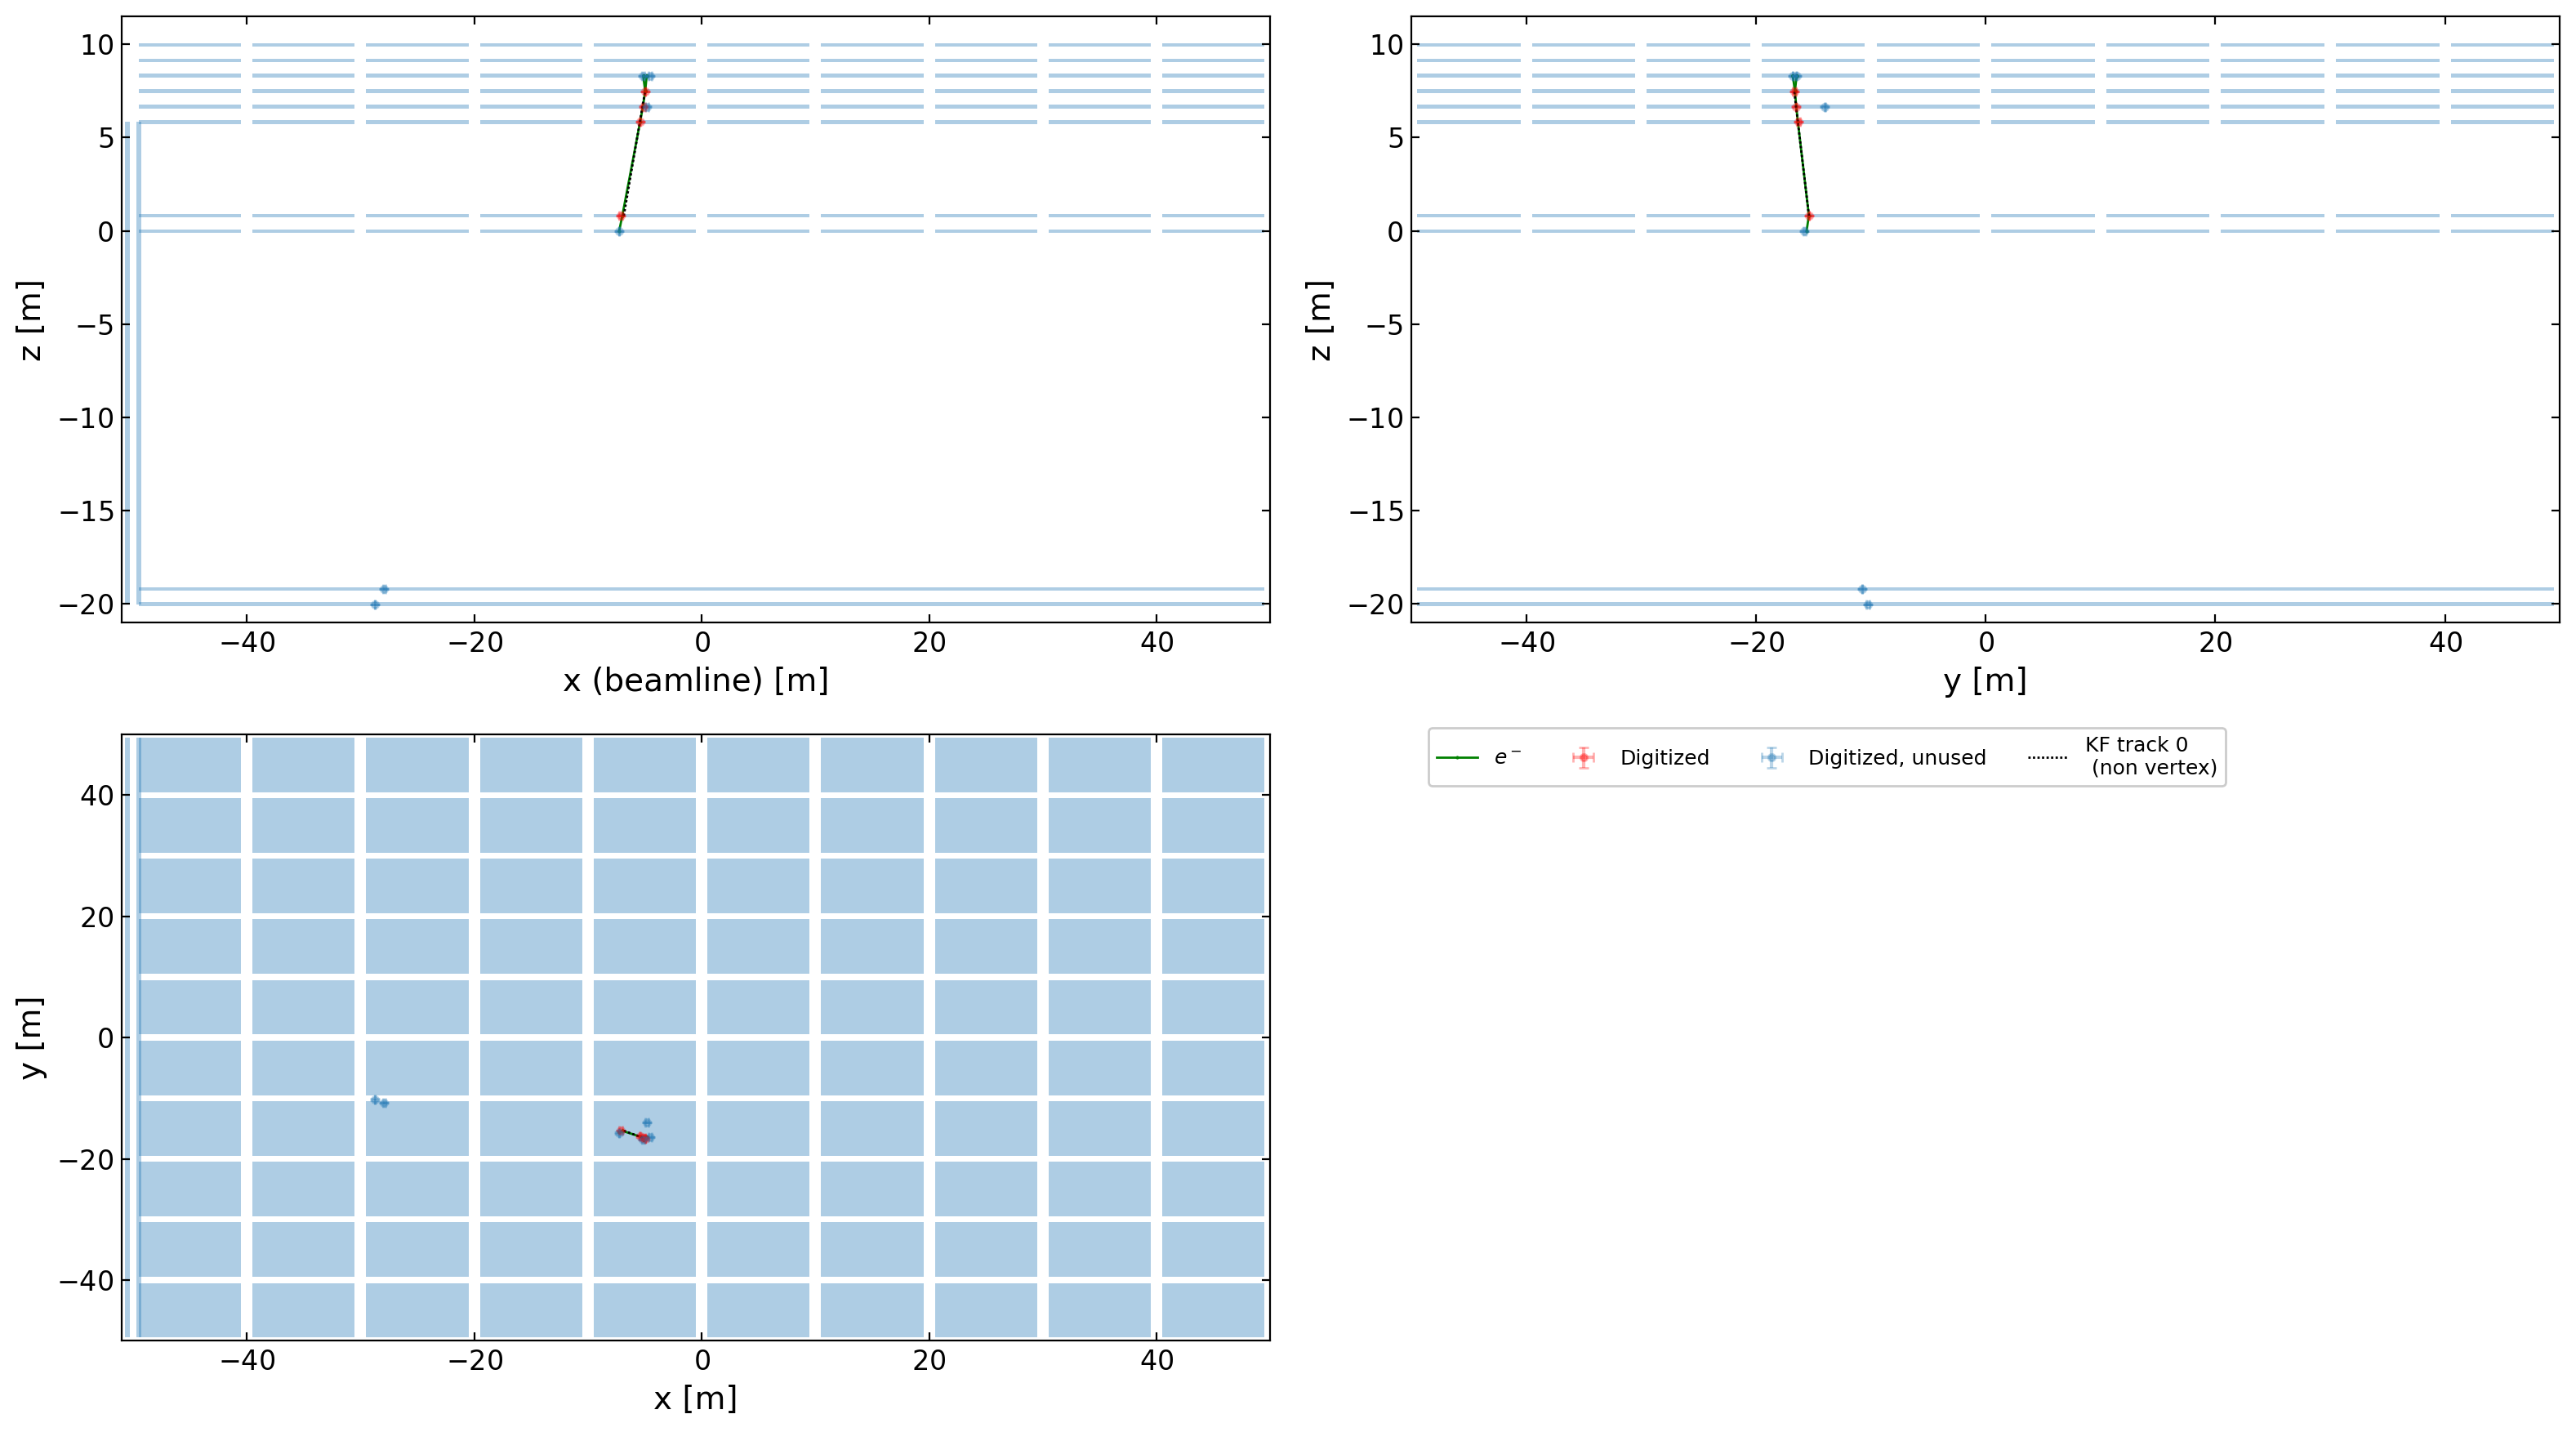

===========================Event 2704==============================


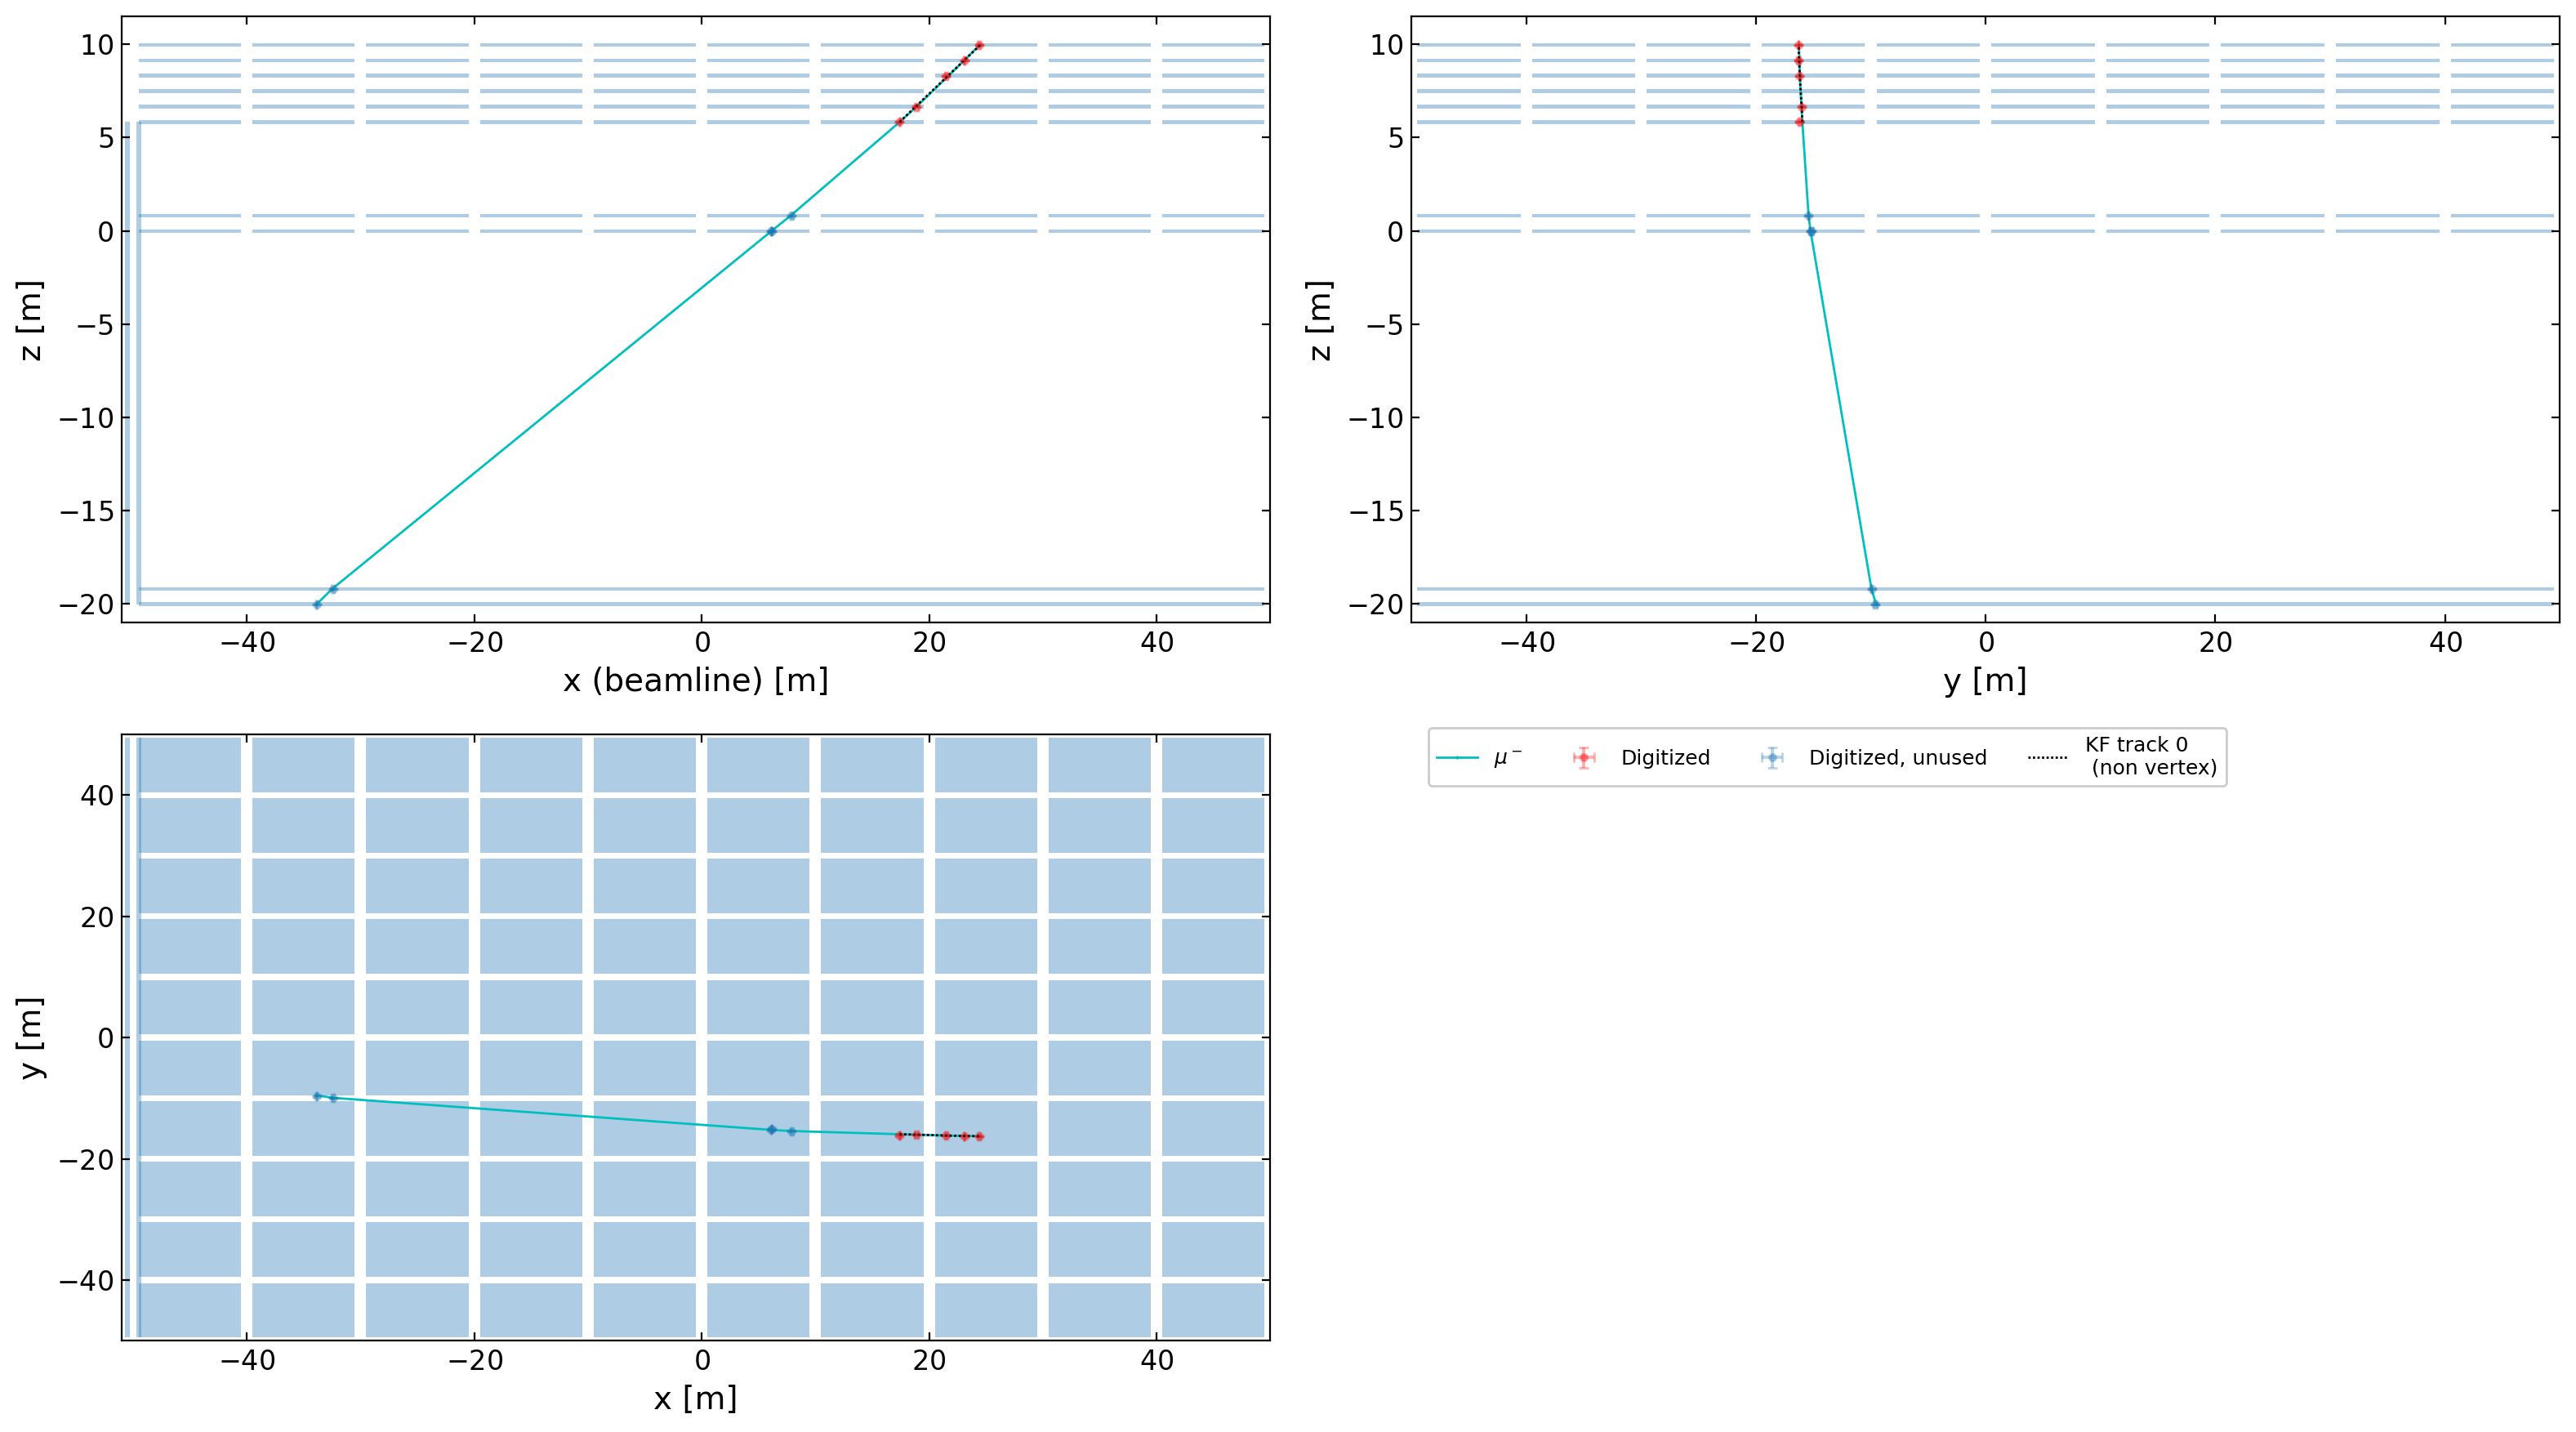

===========================Event 3561==============================


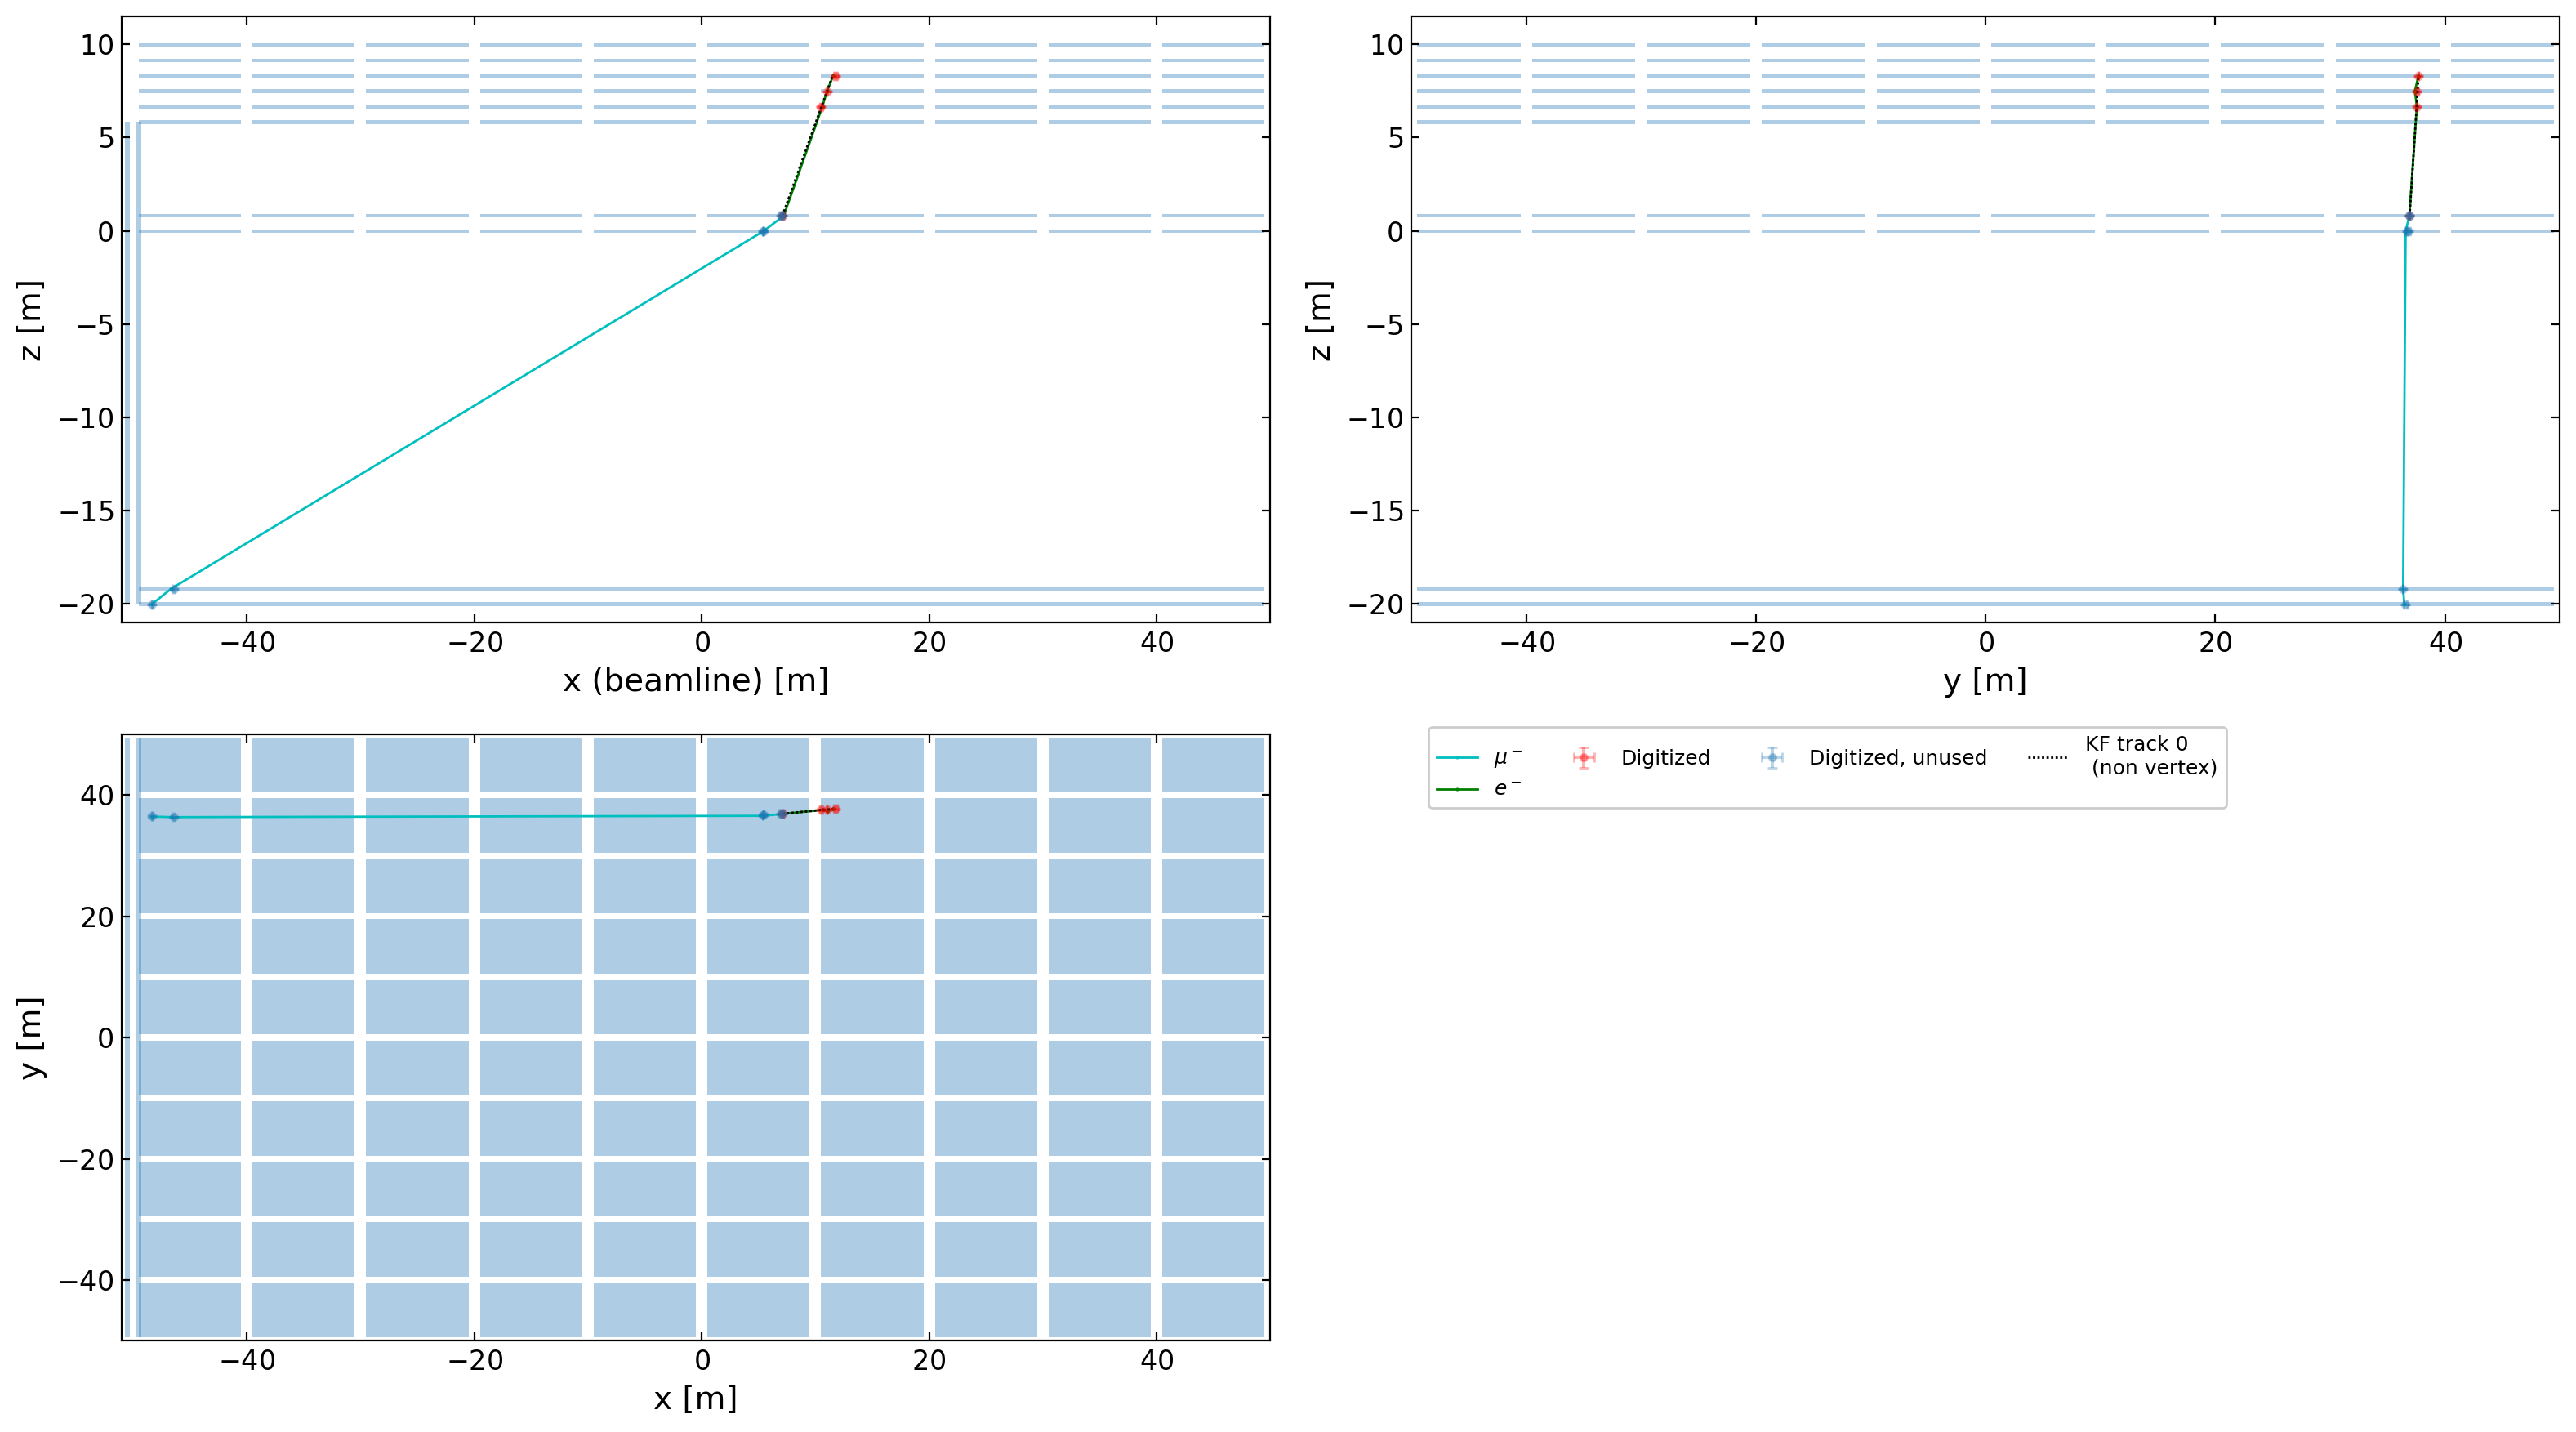

===========================Event 4289==============================


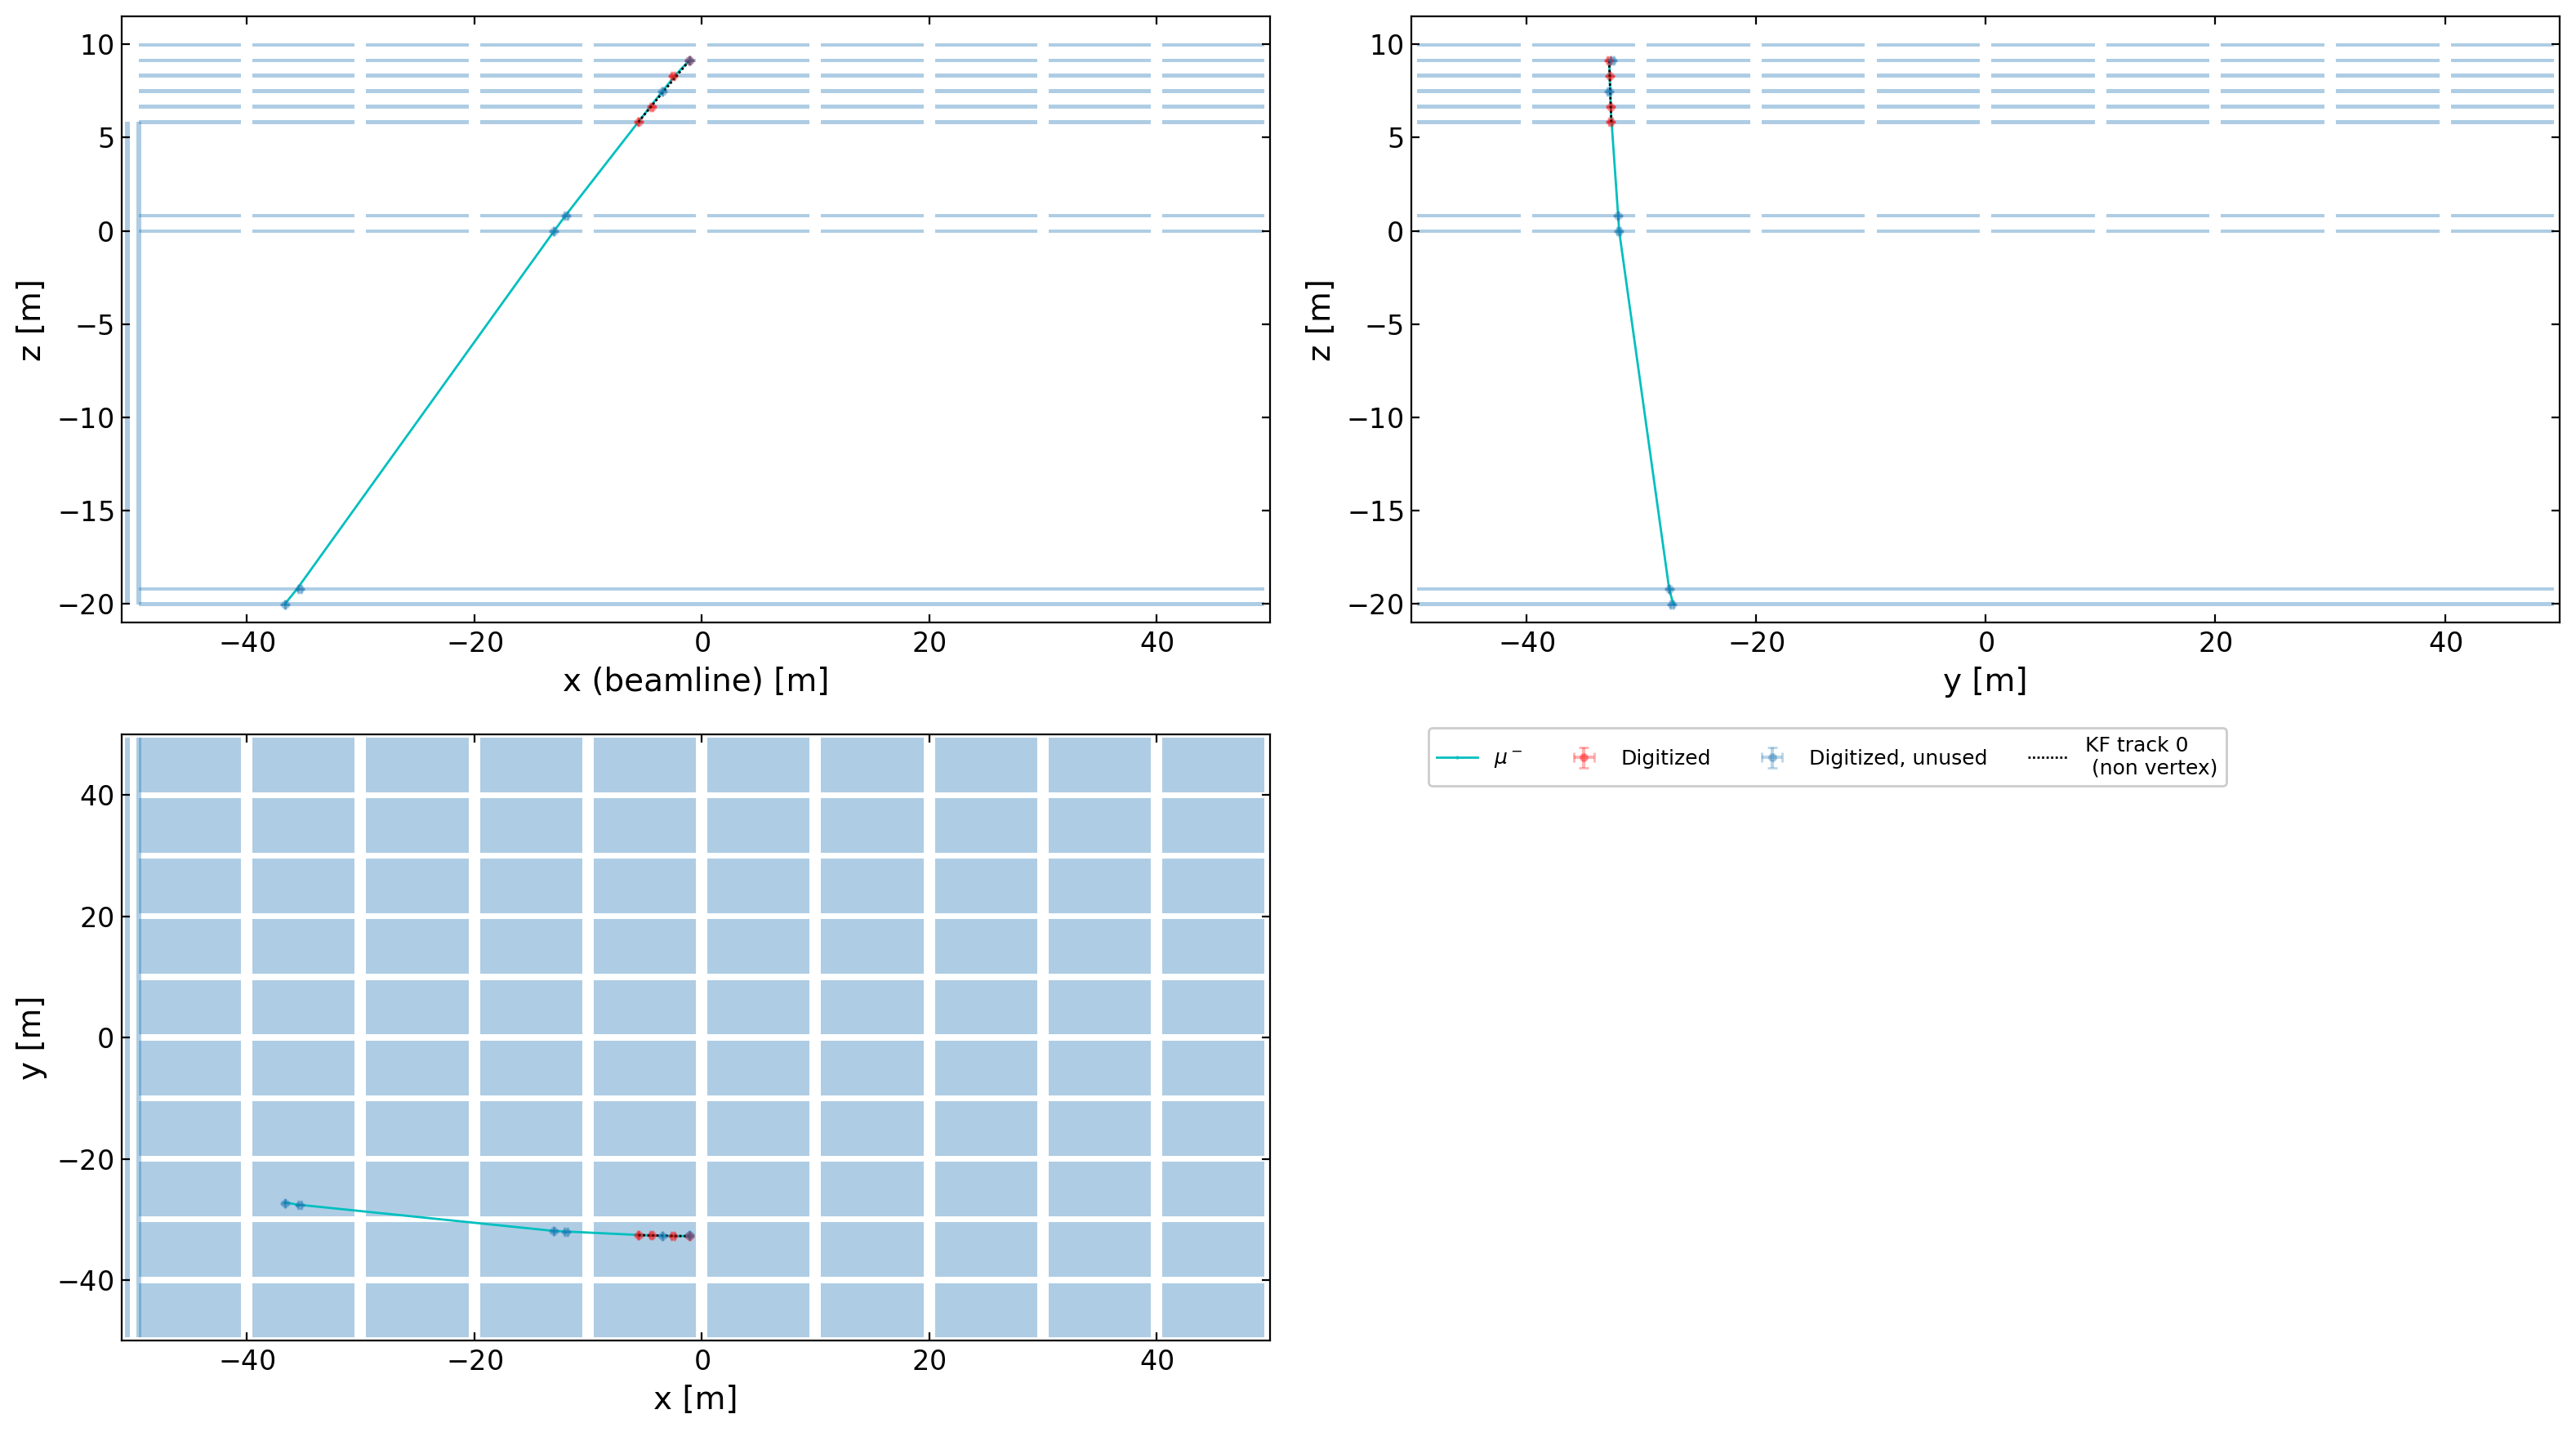

===========================Event 4519==============================


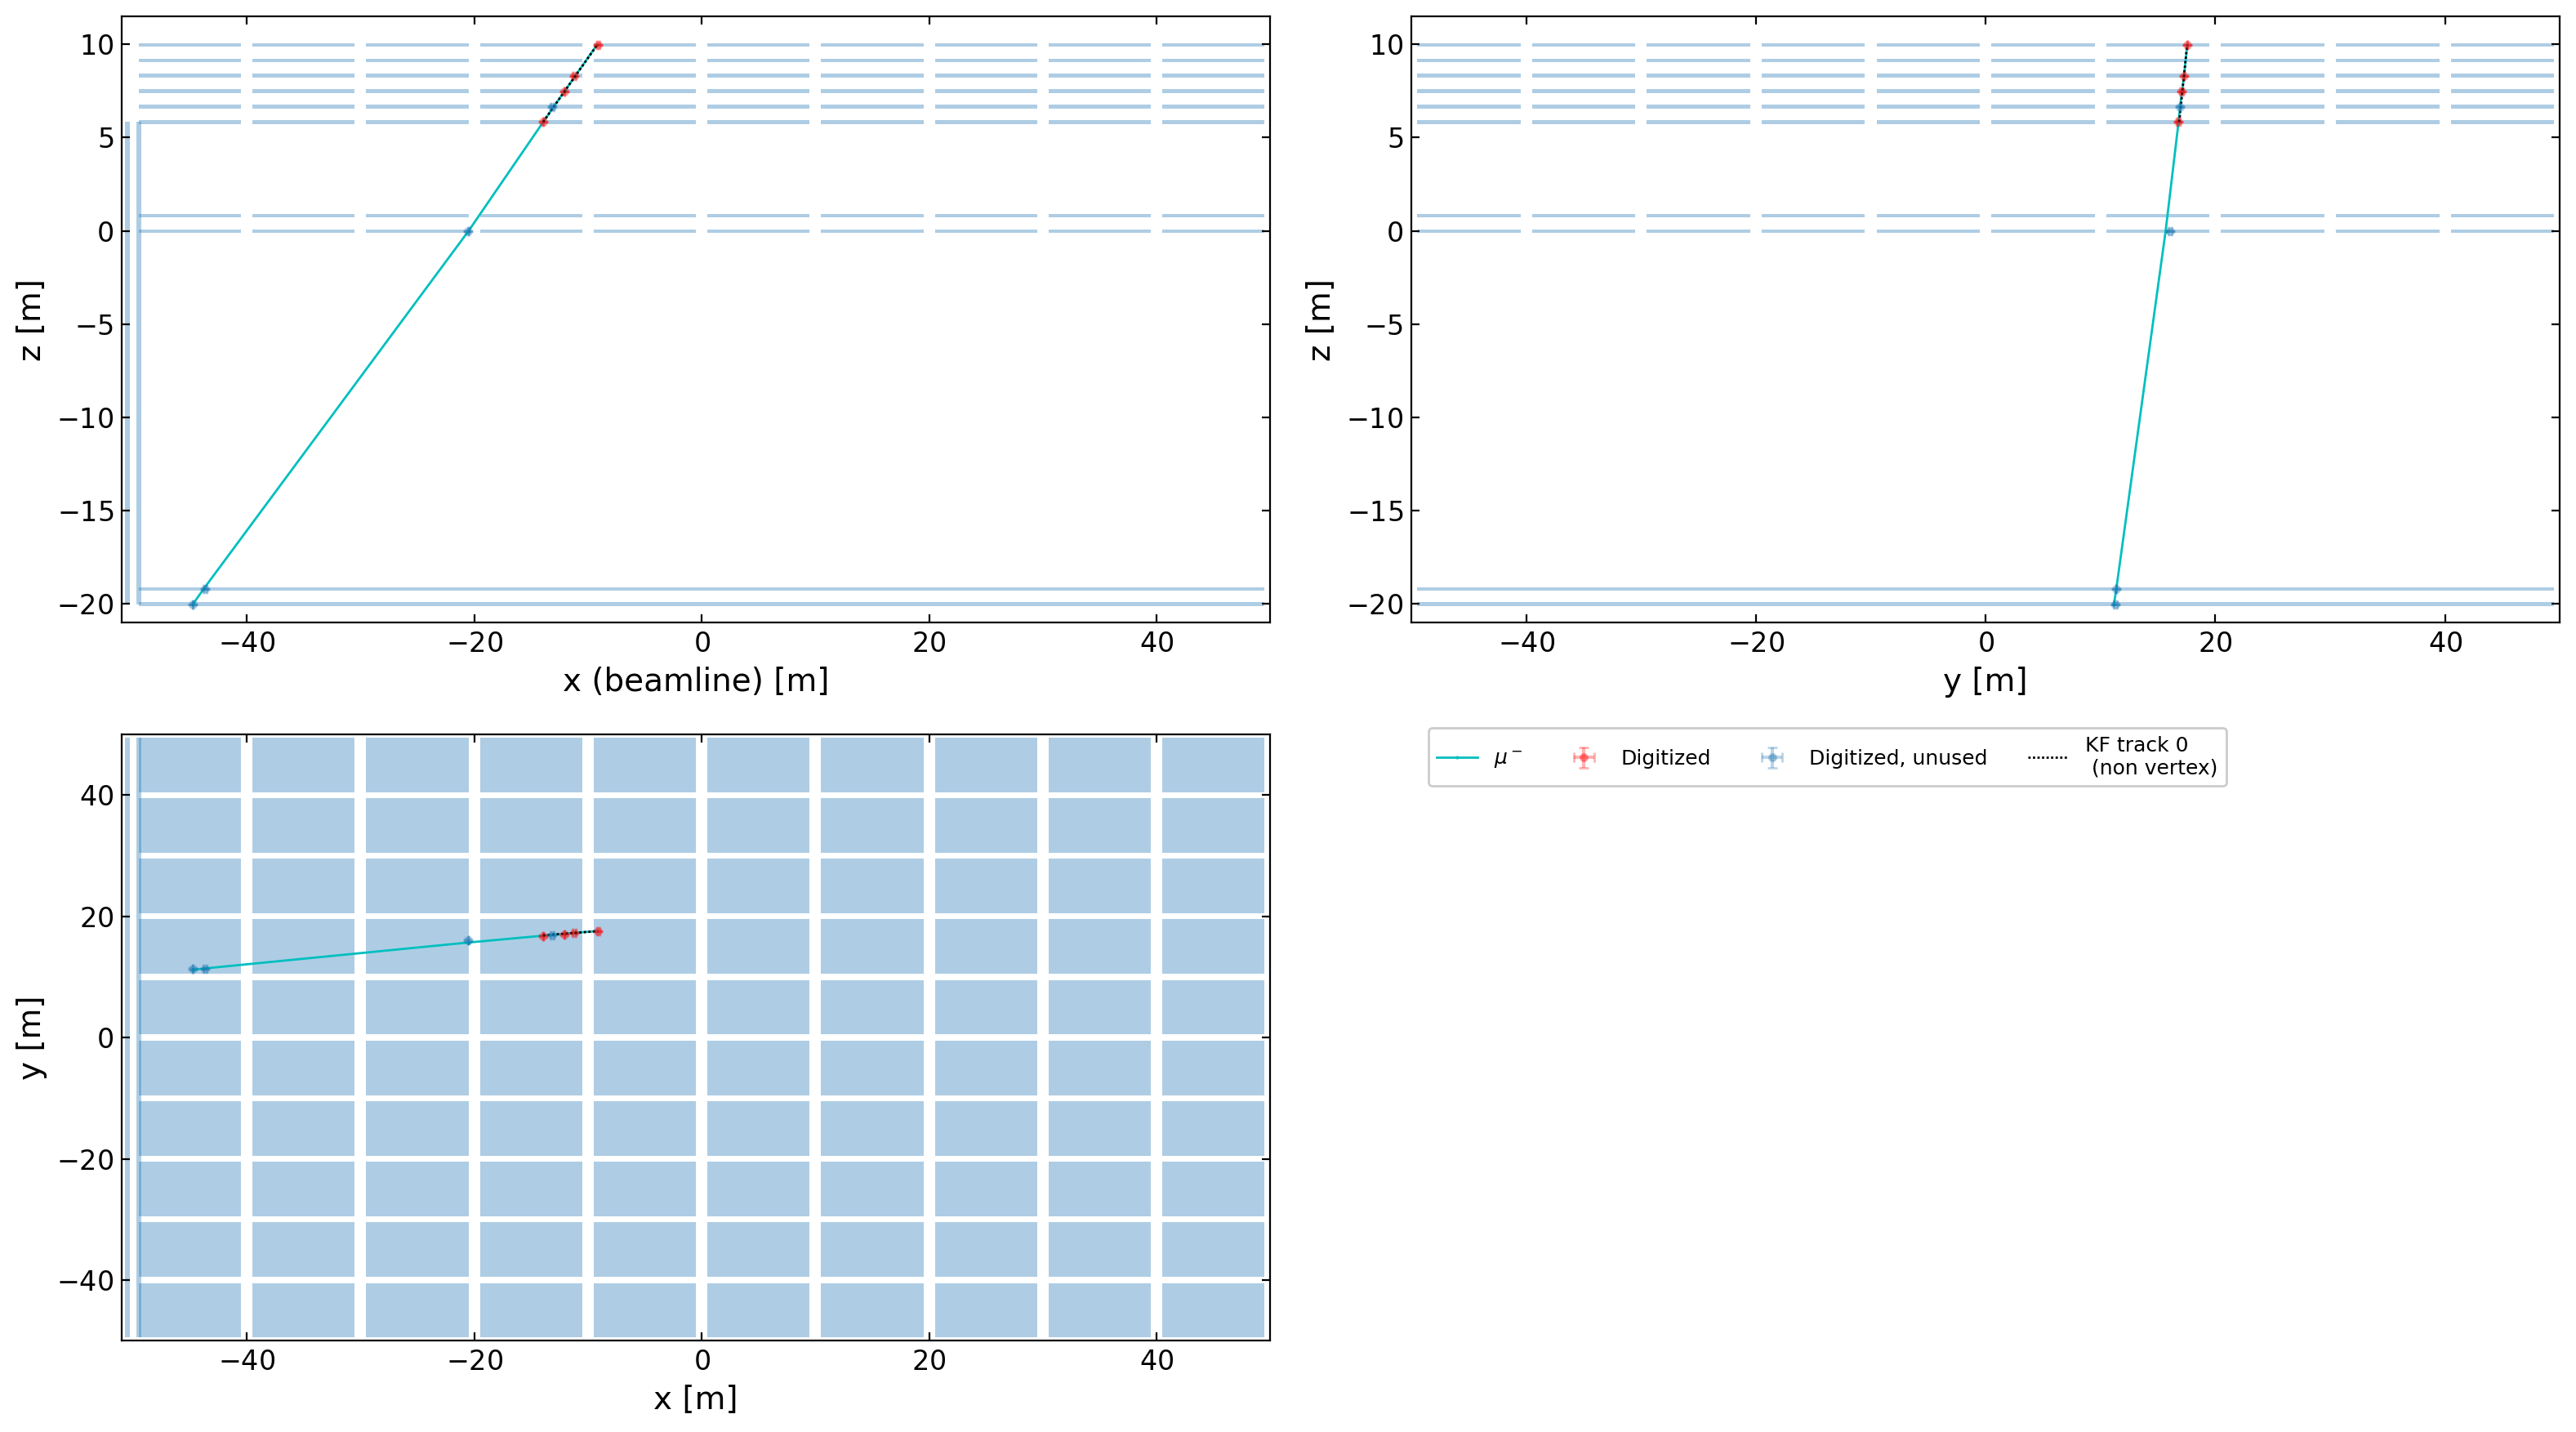

===========================Event 5074==============================


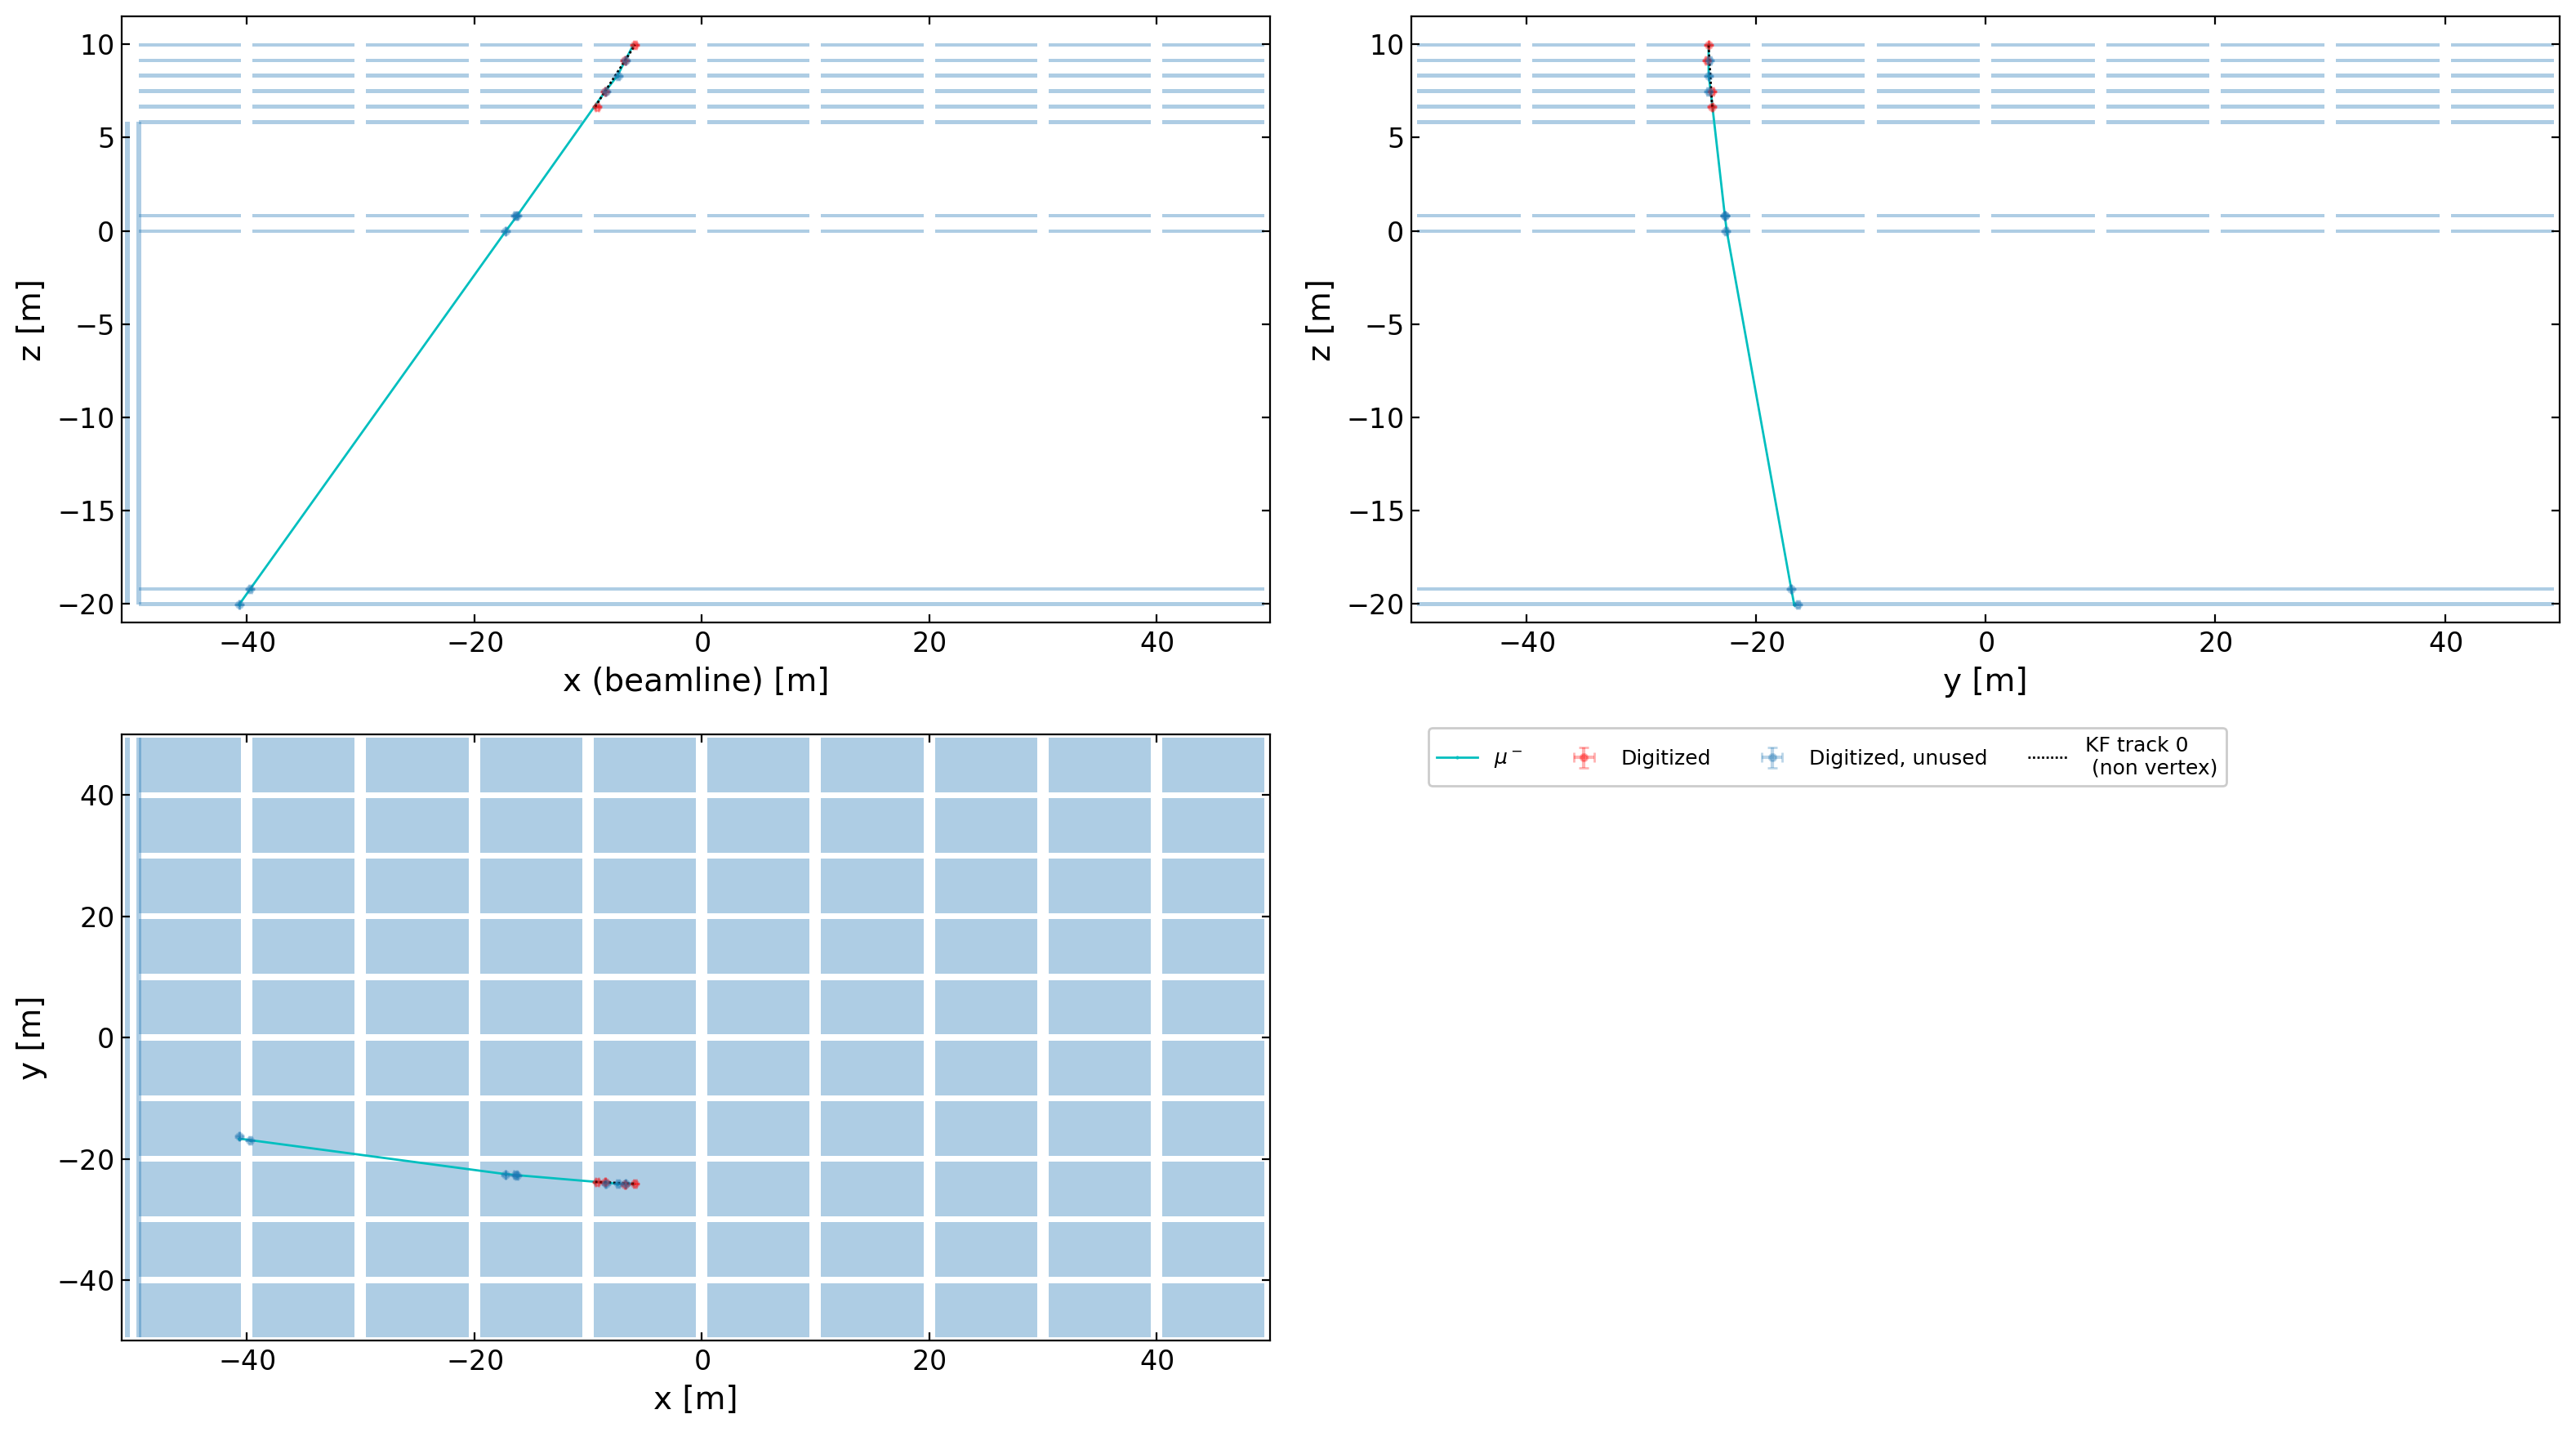

===========================Event 5315==============================


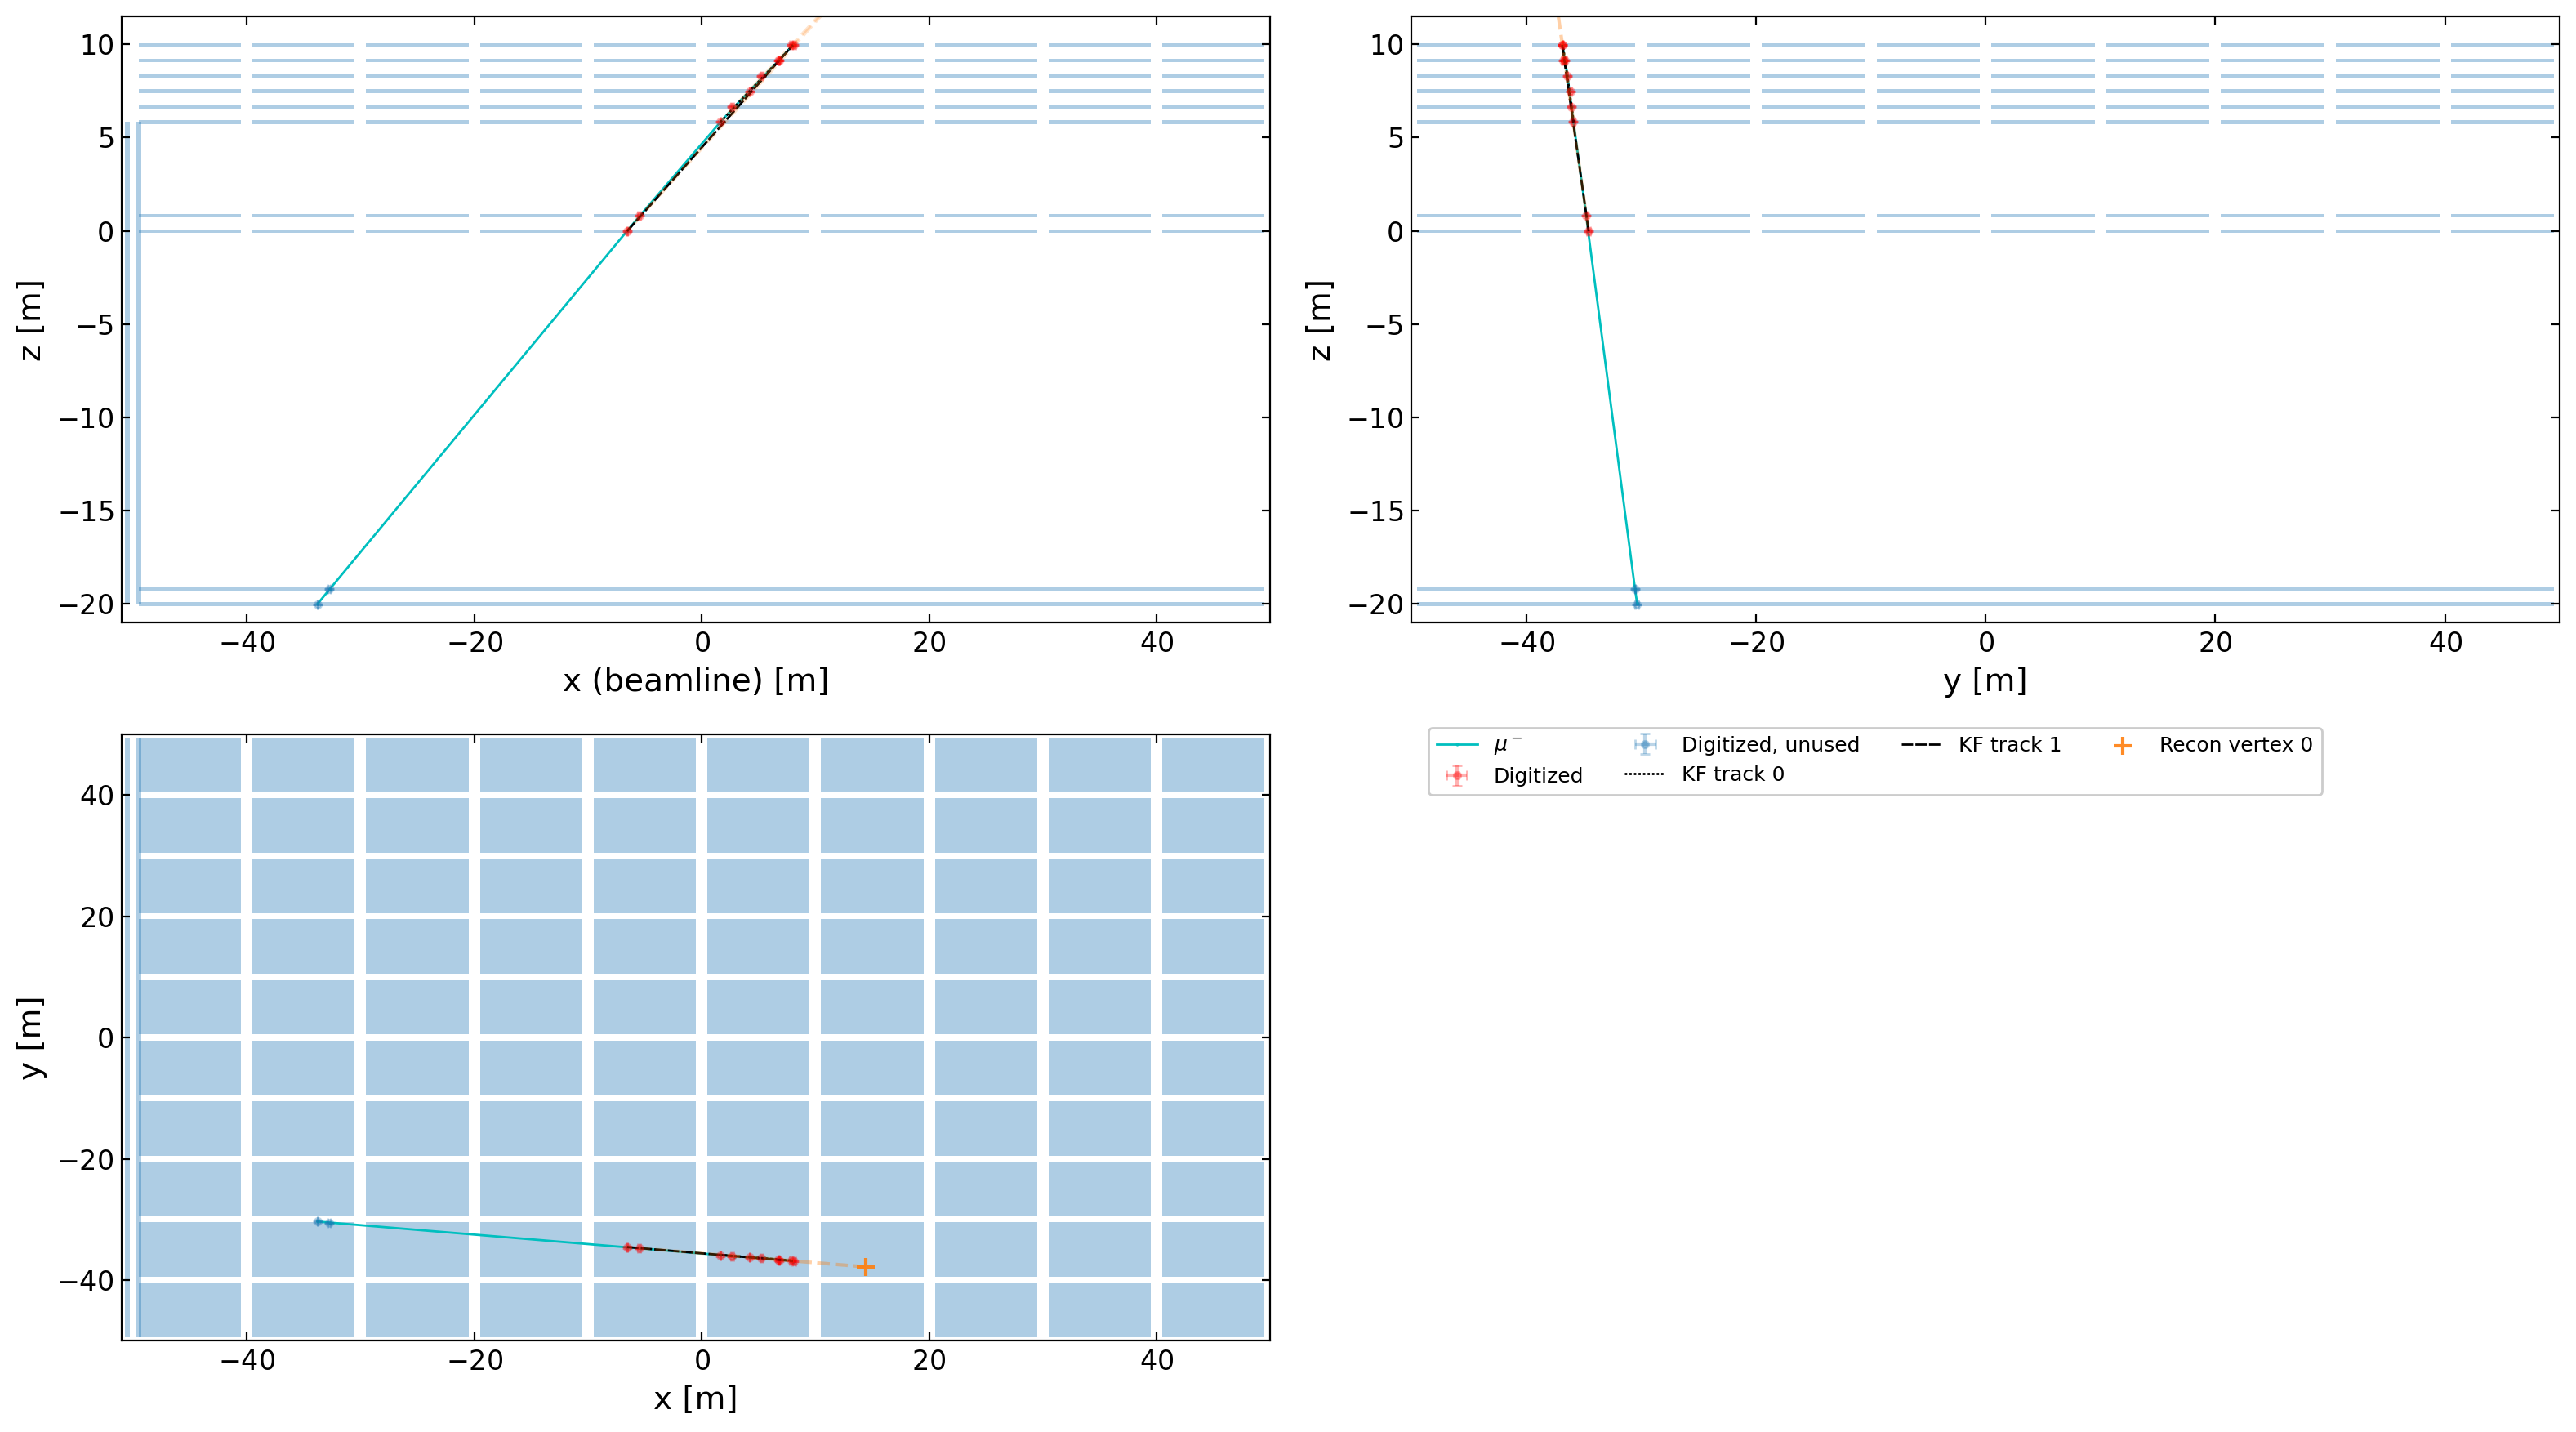

===========================Event 5482==============================


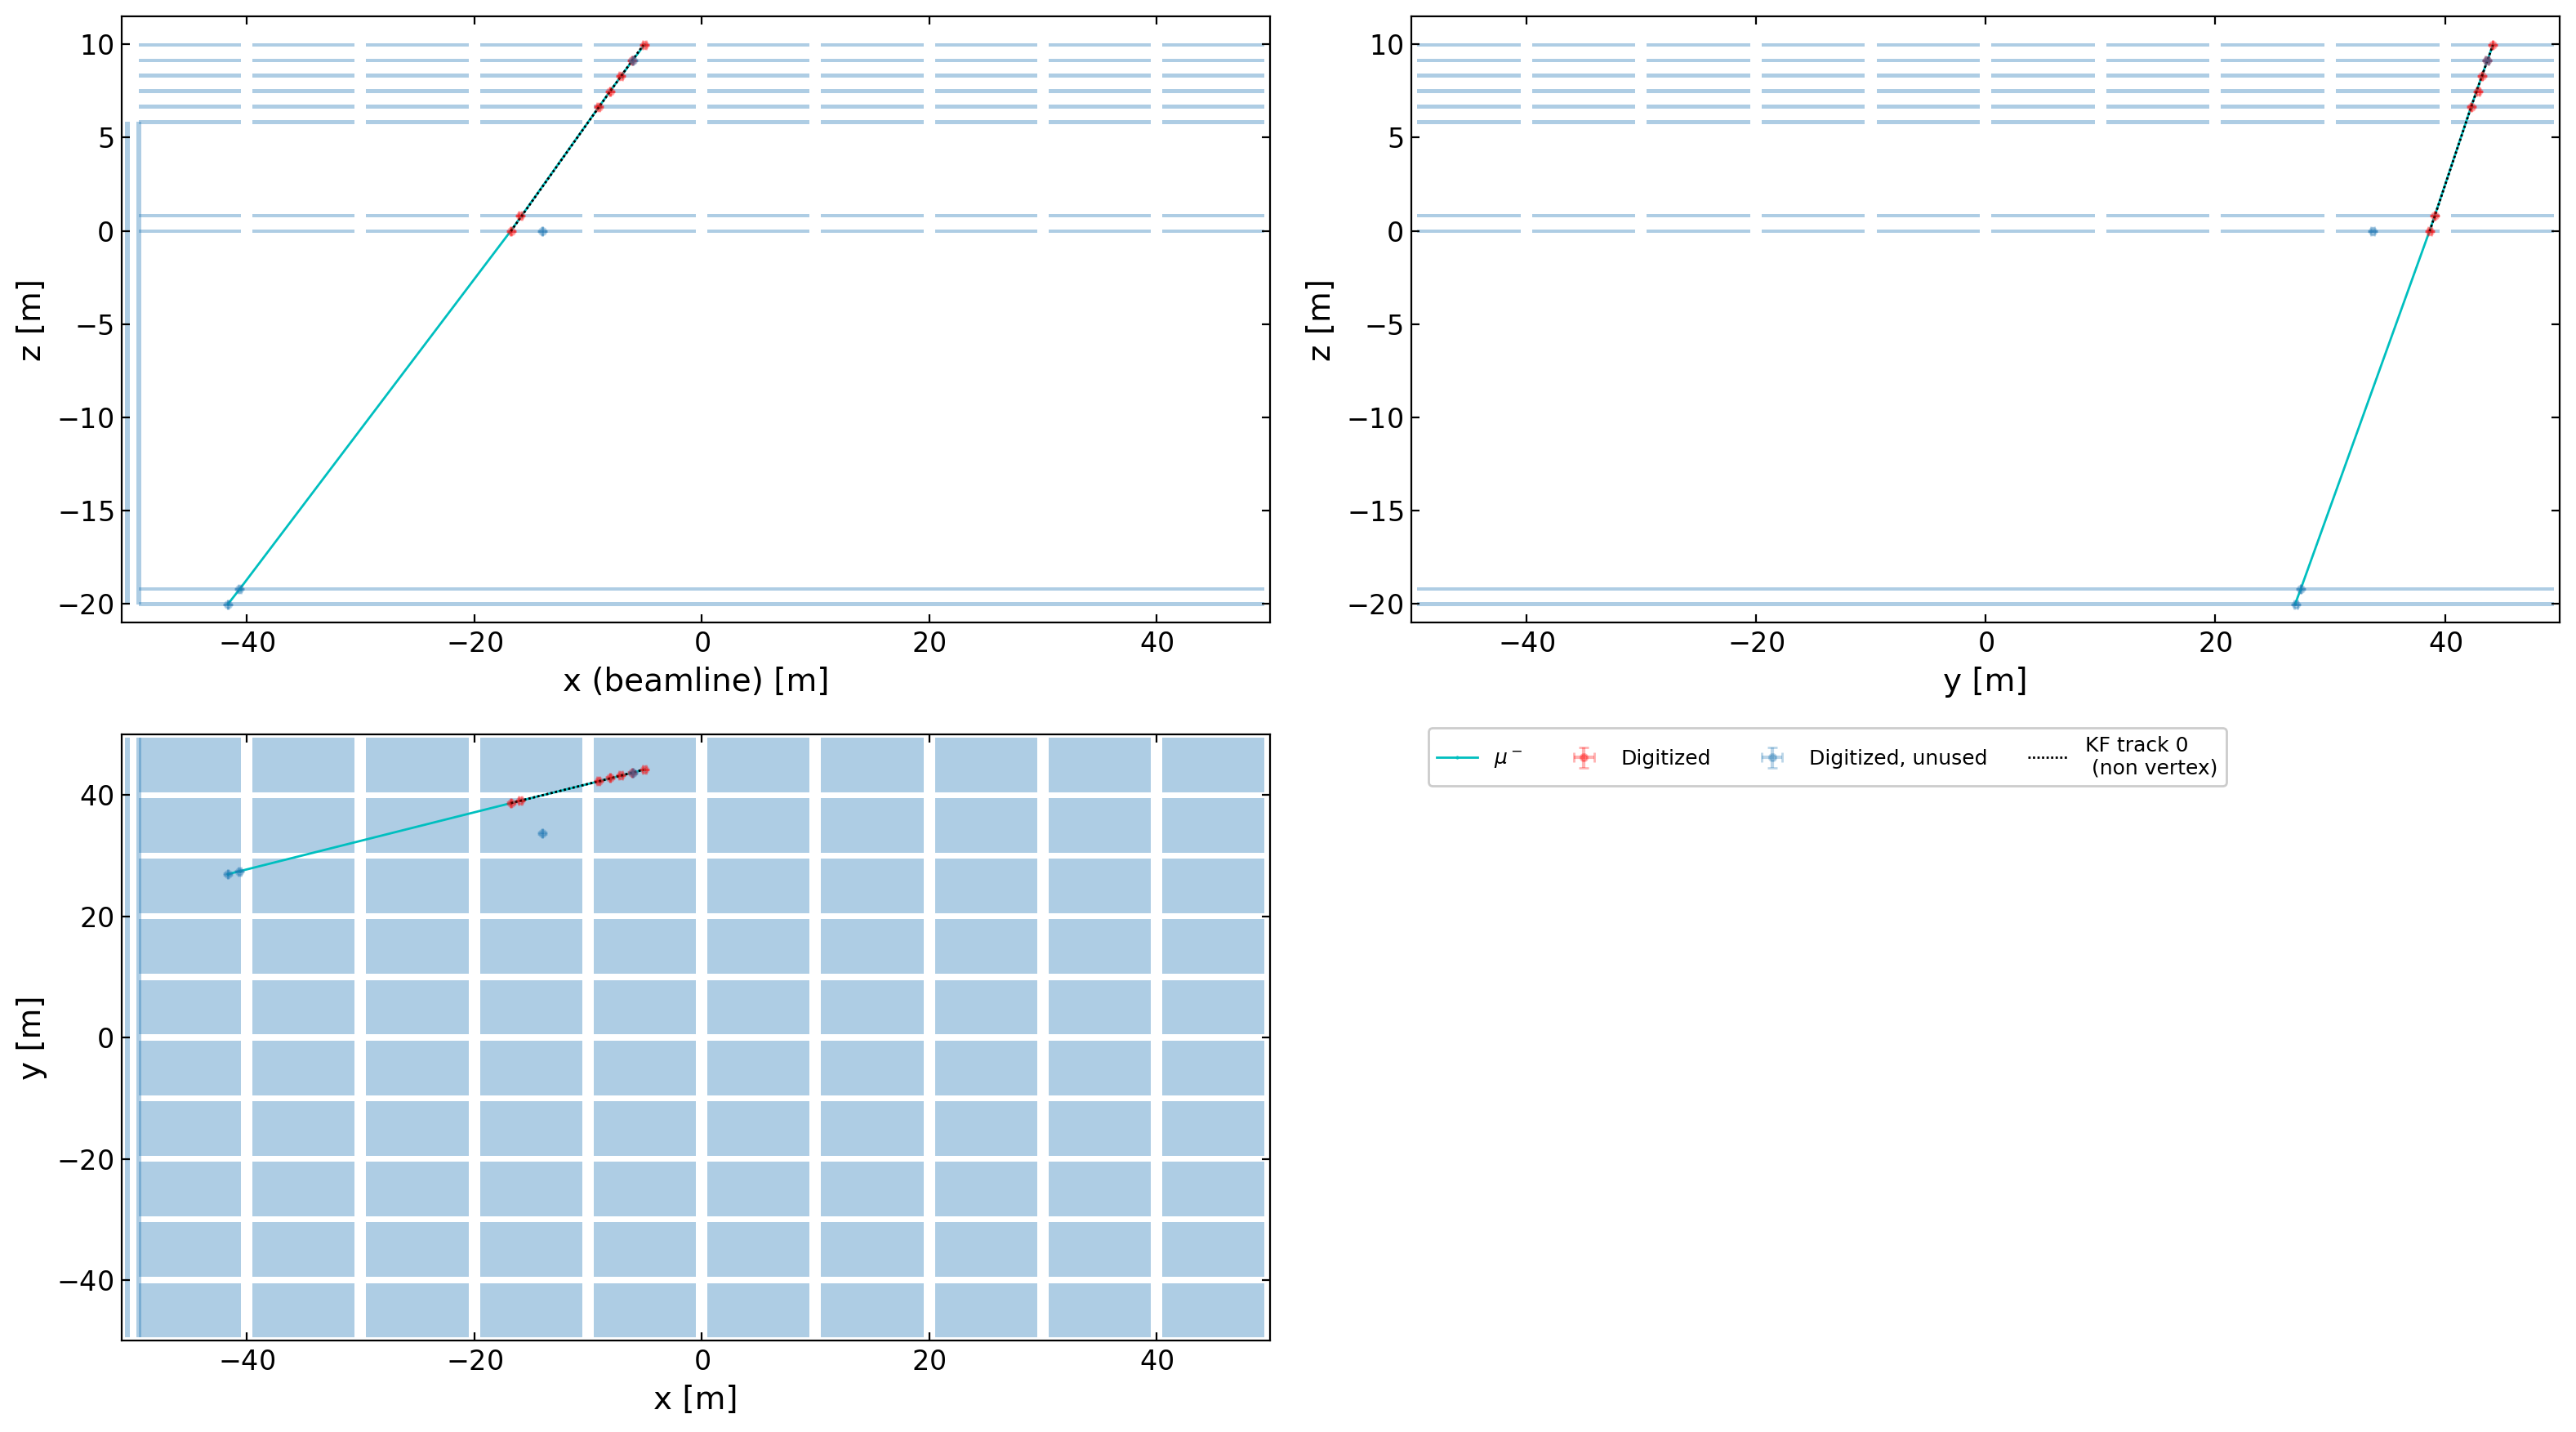

===========================Event 6008==============================


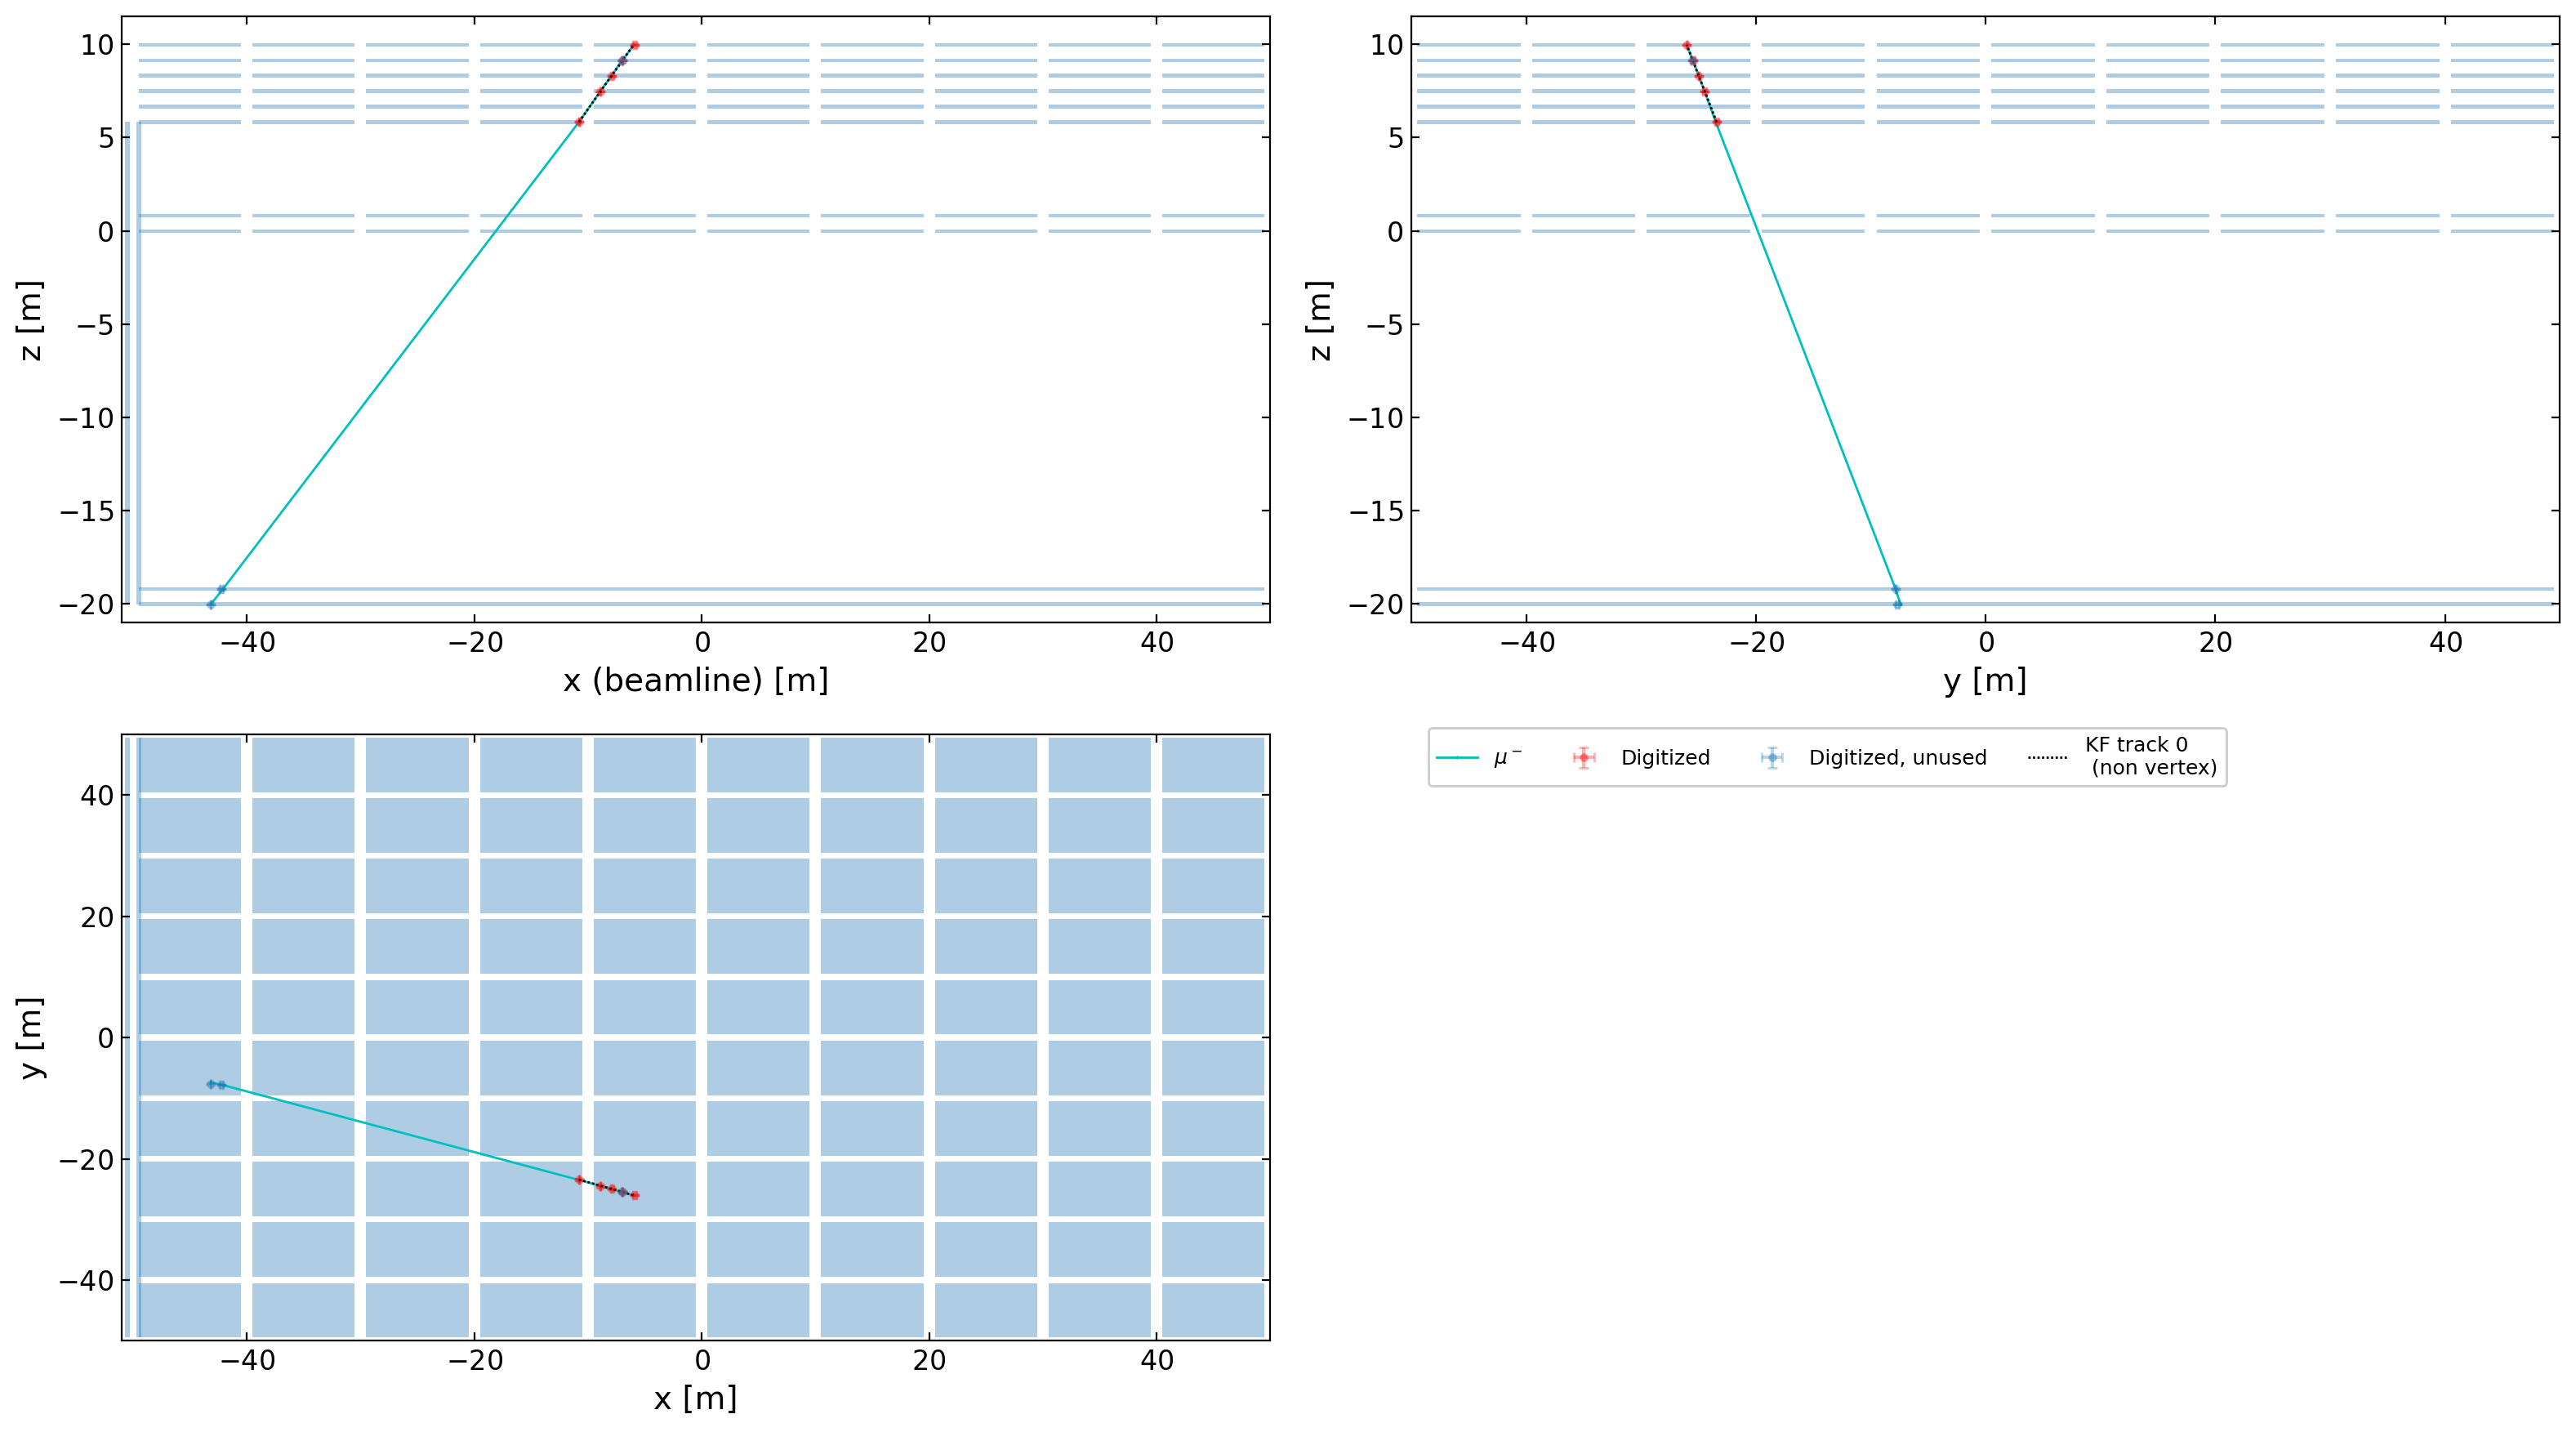

===========================Event 6145==============================


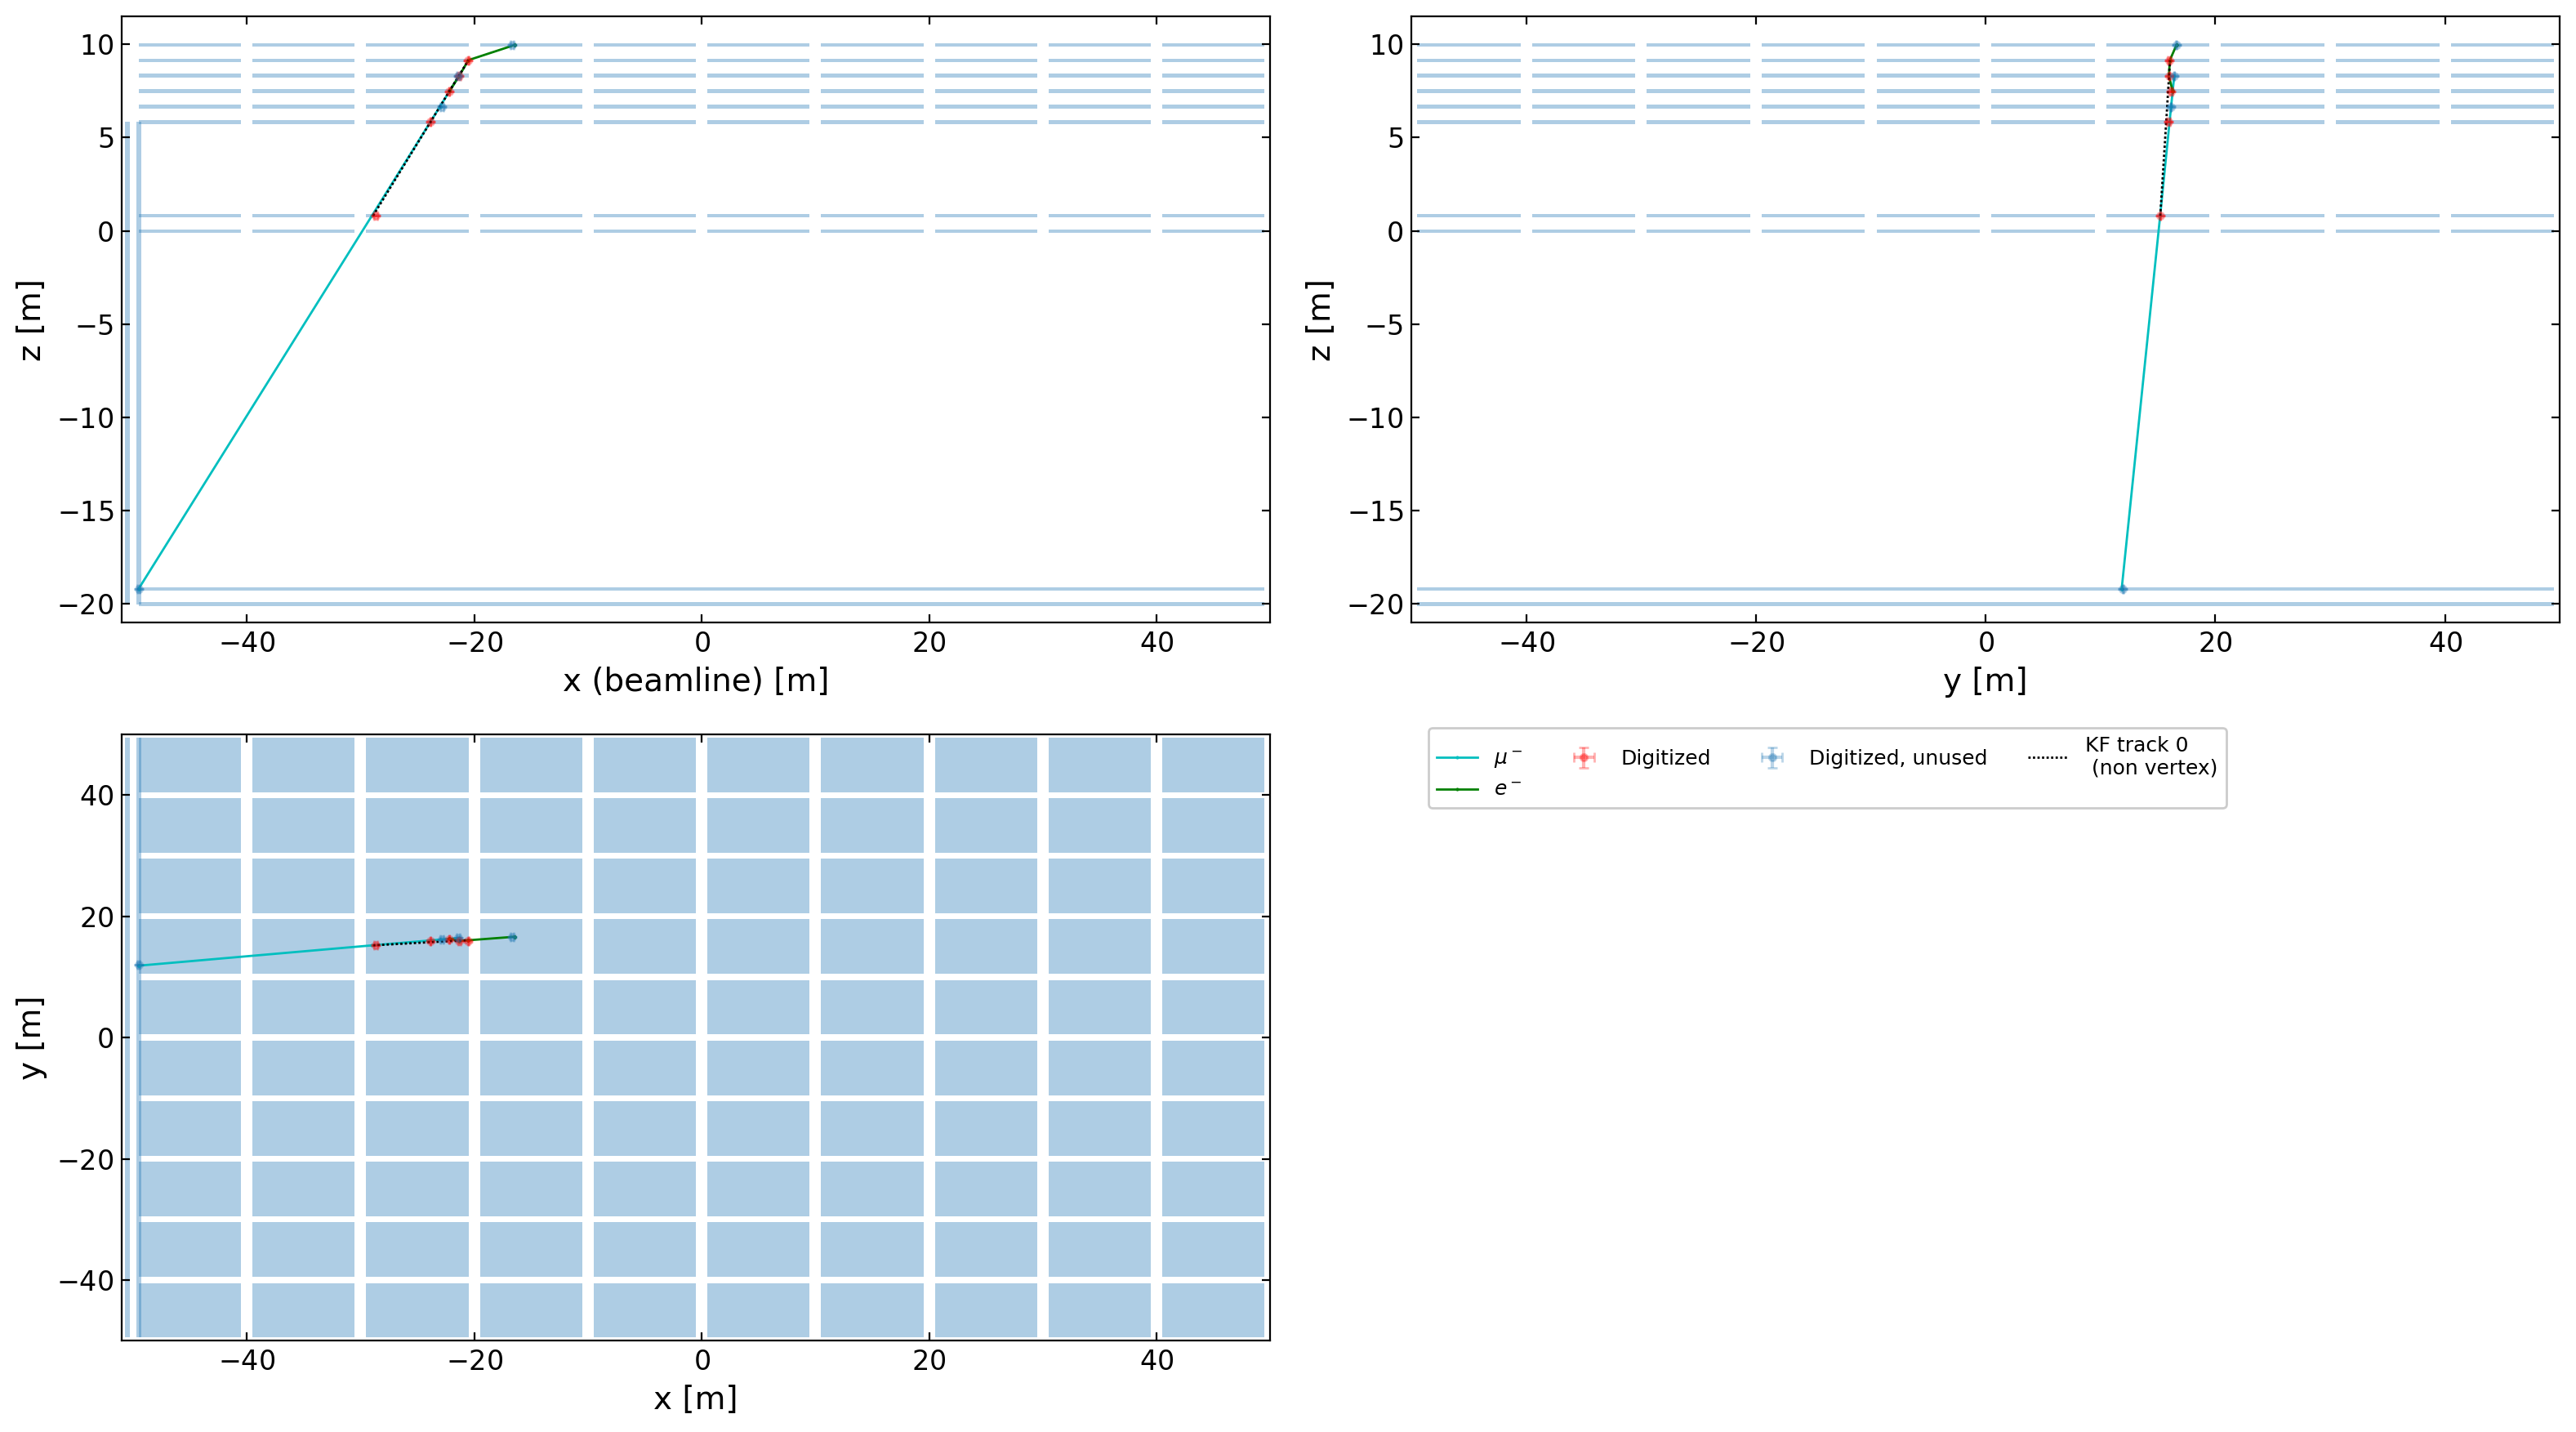

===========================Event 6622==============================


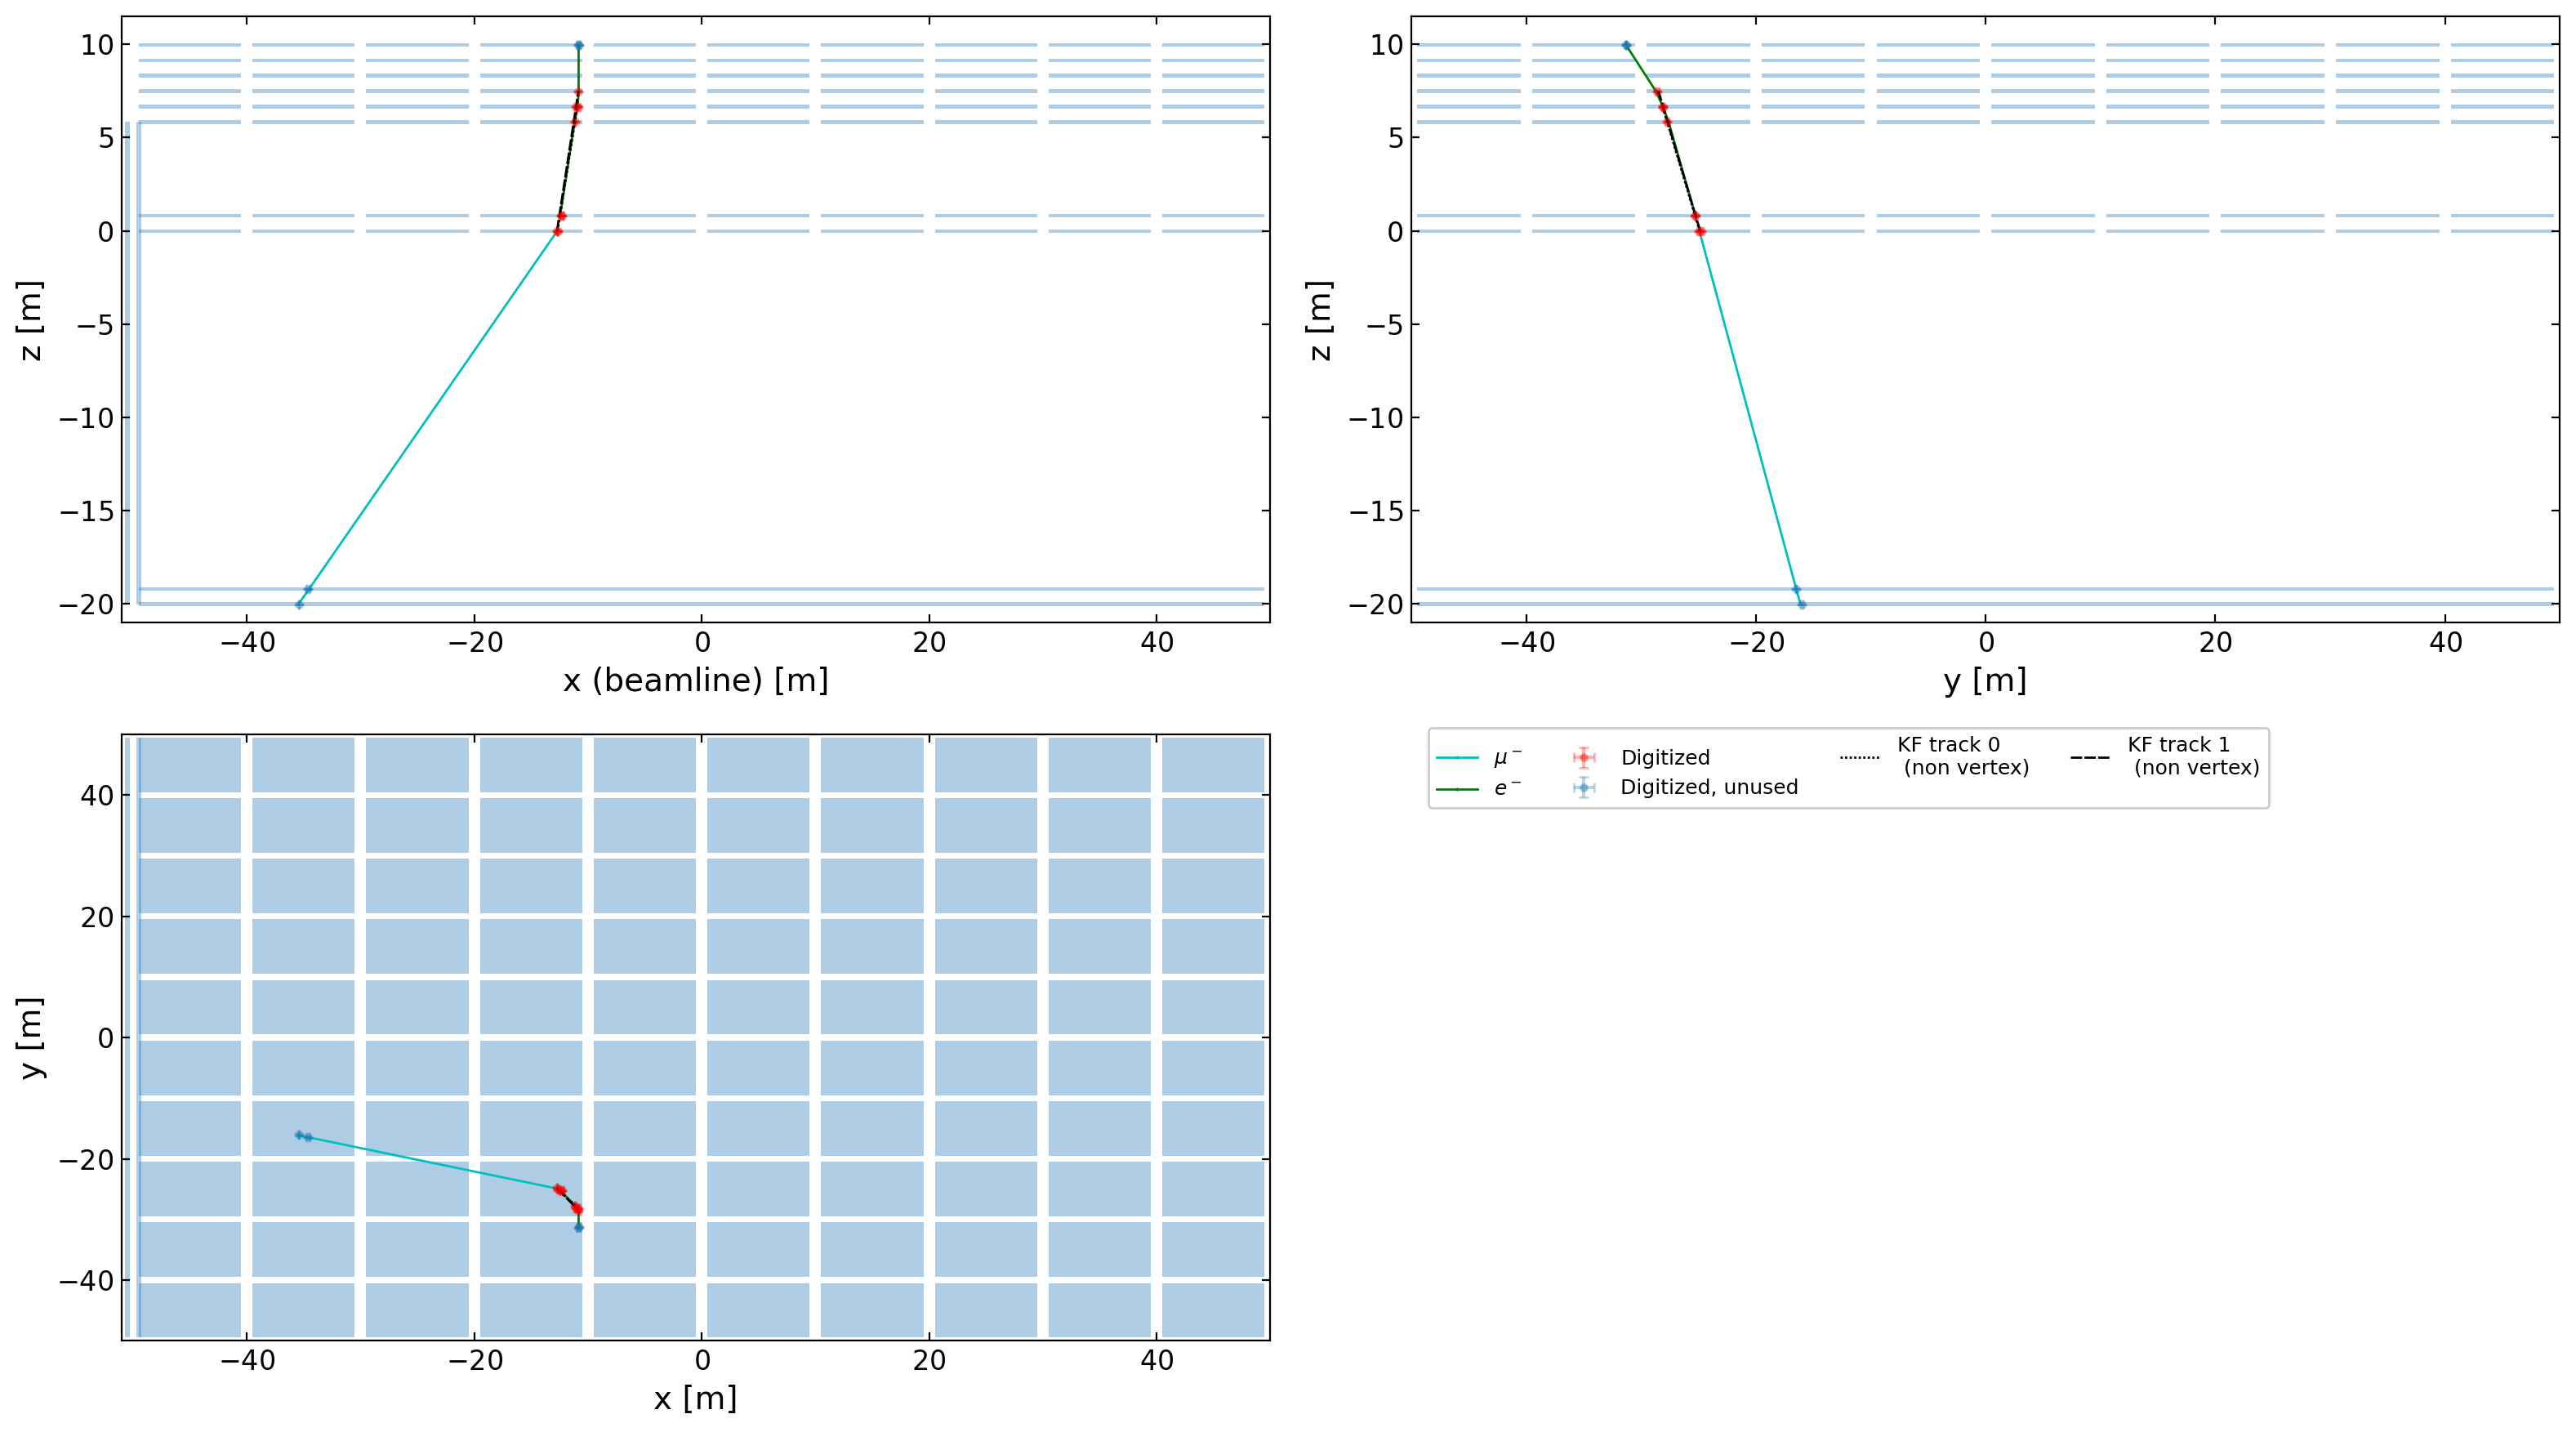

===========================Event 6695==============================


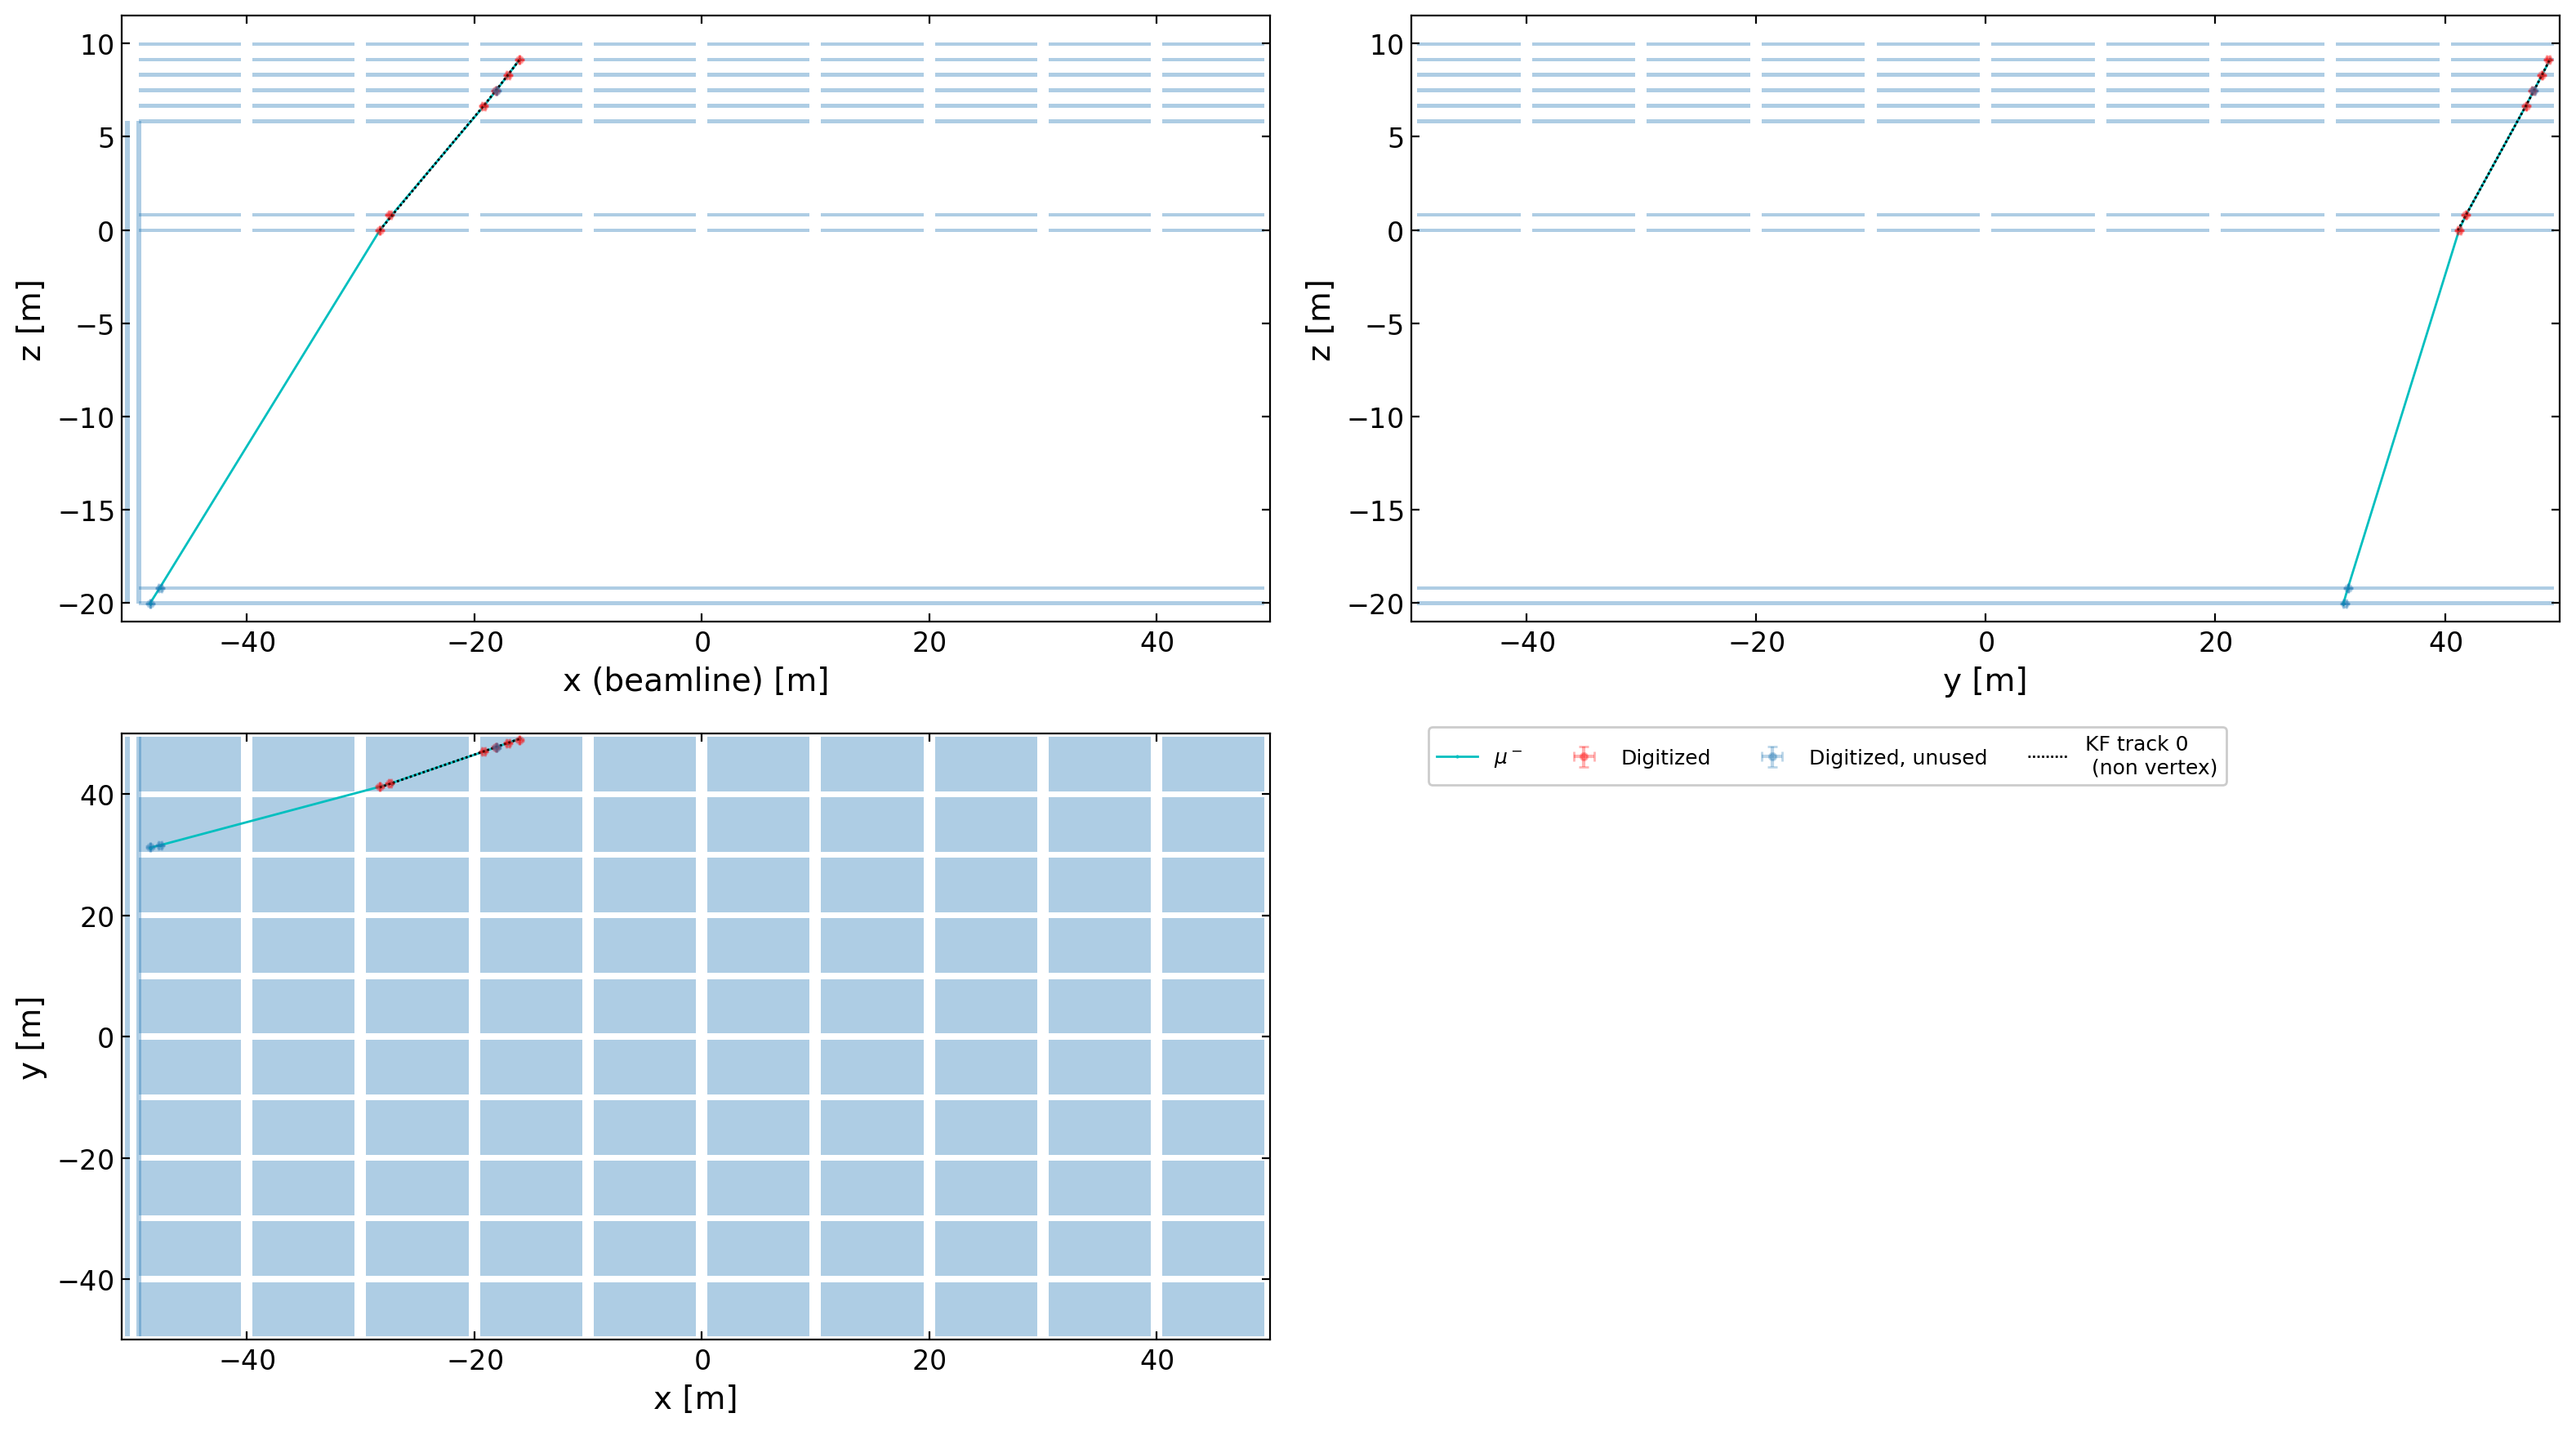

===========================Event 6731==============================


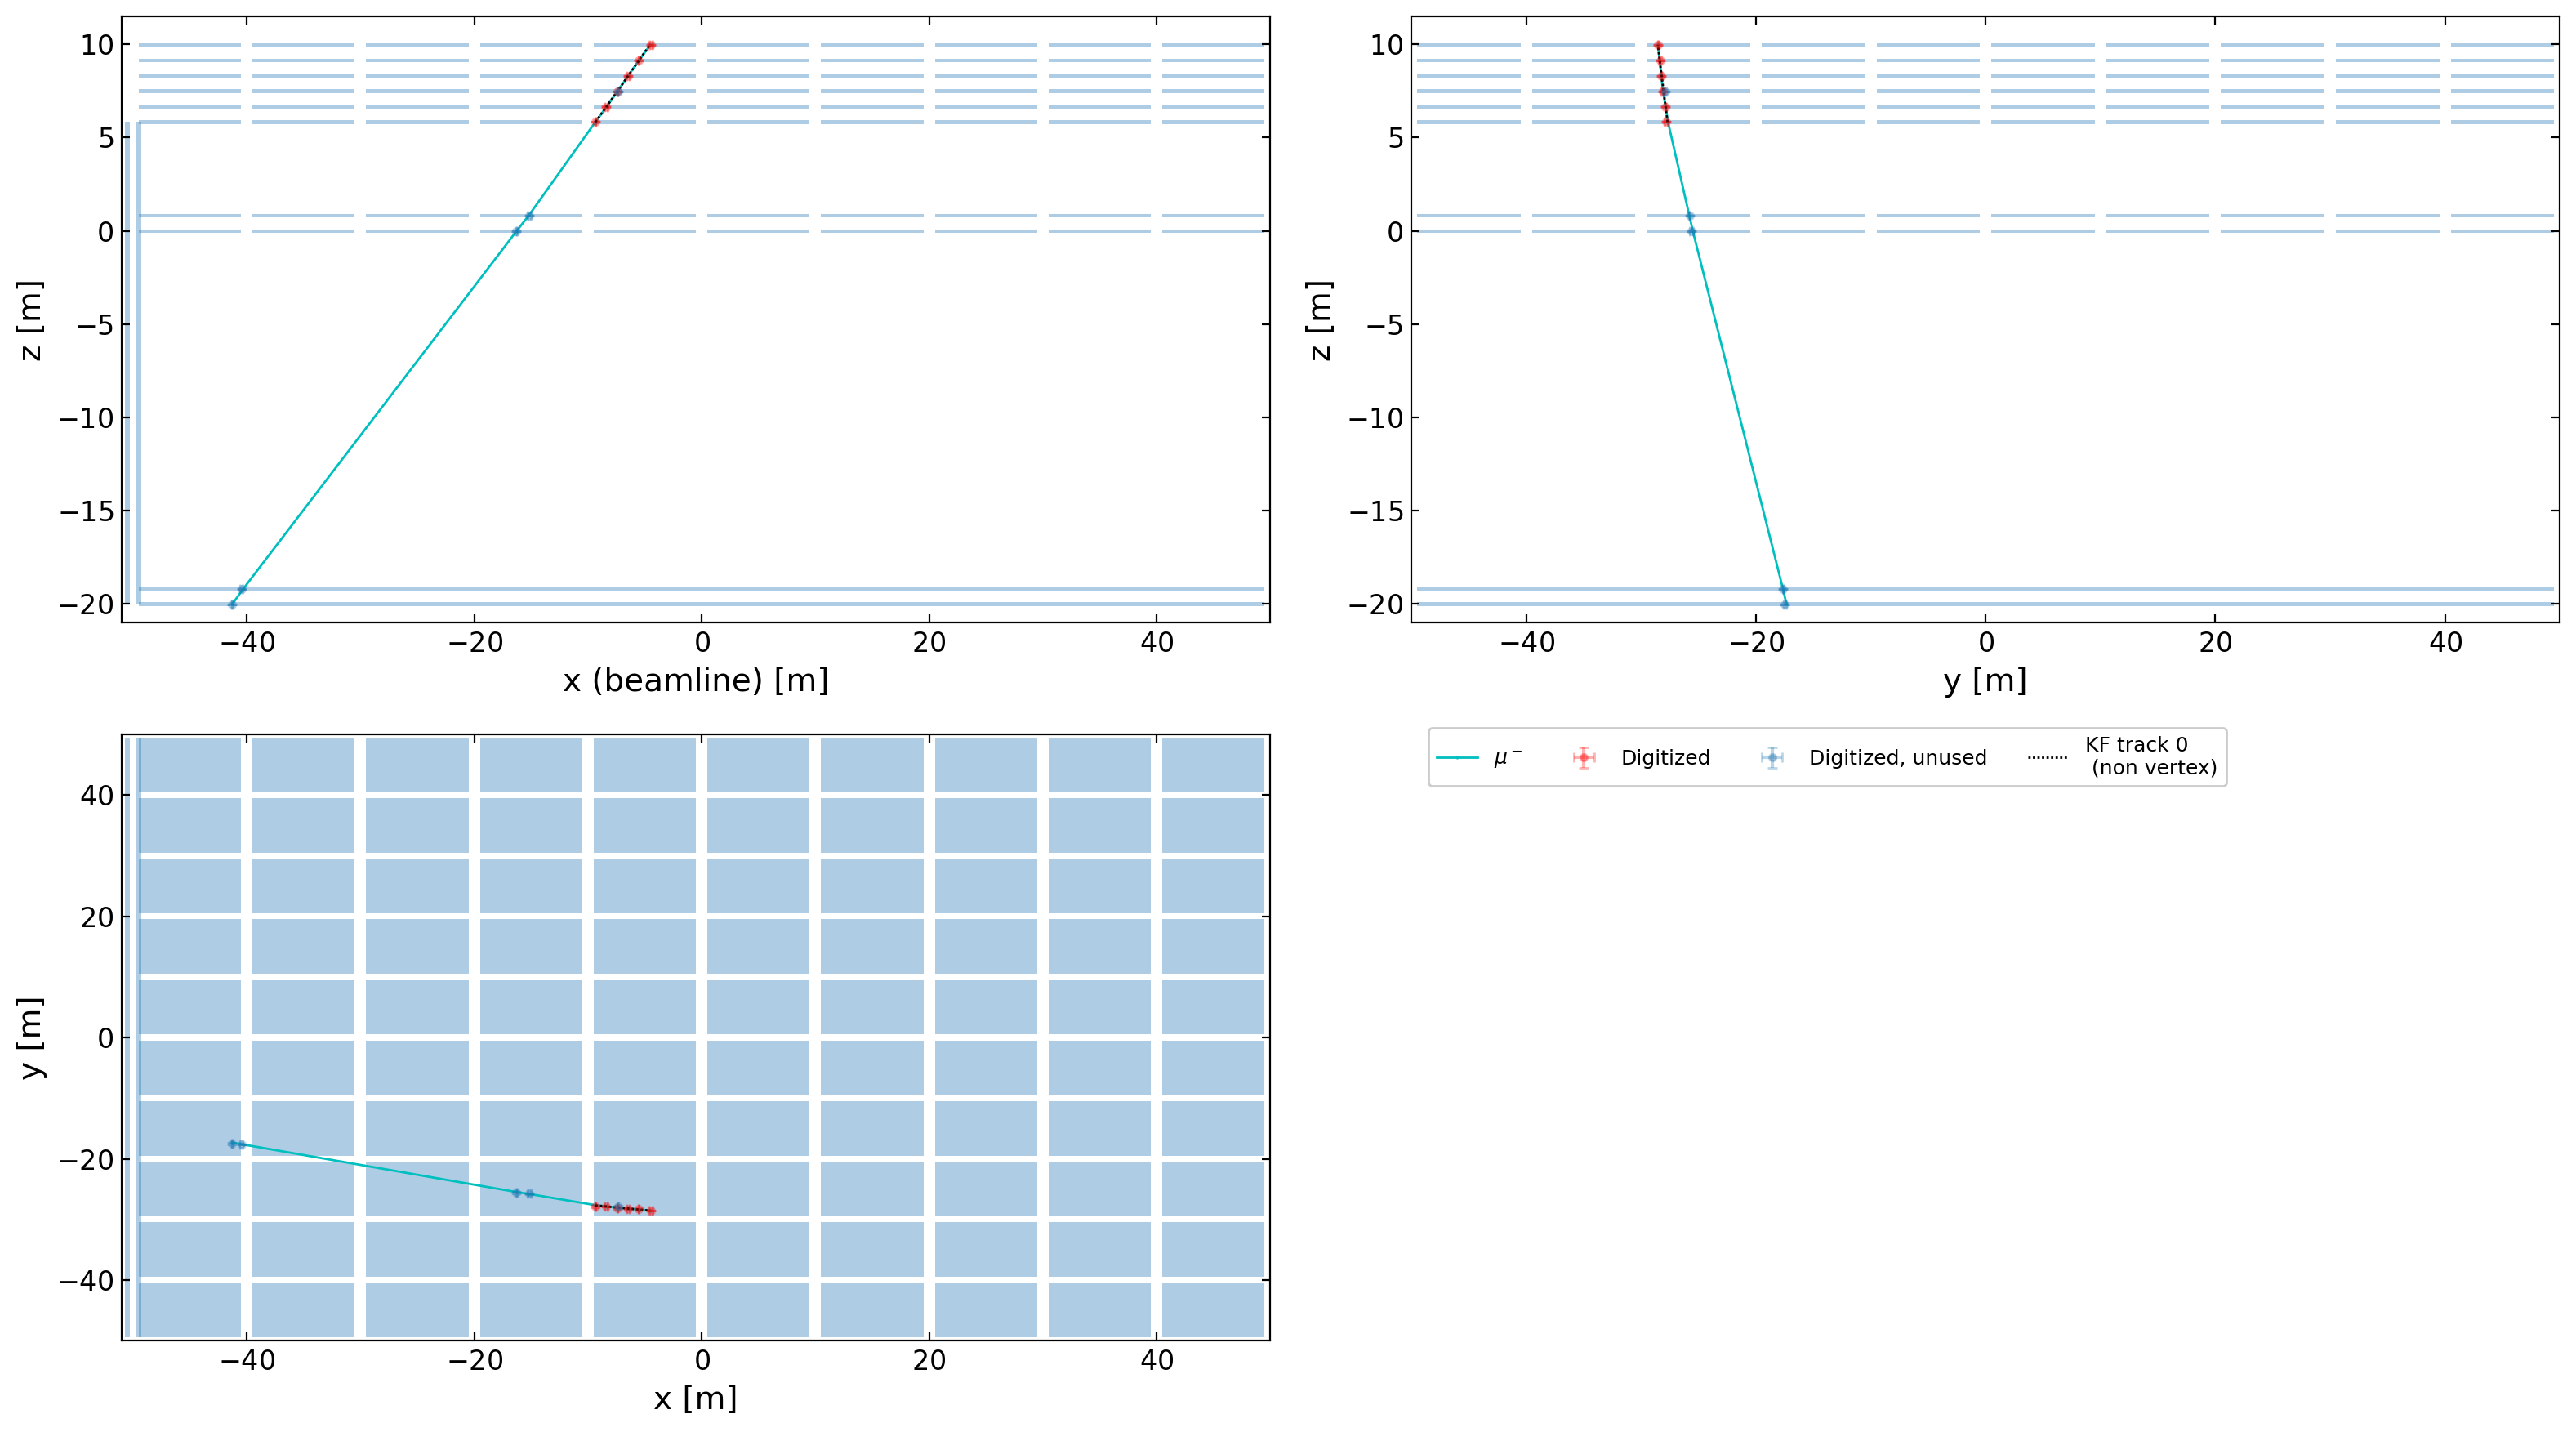

===========================Event 7020==============================


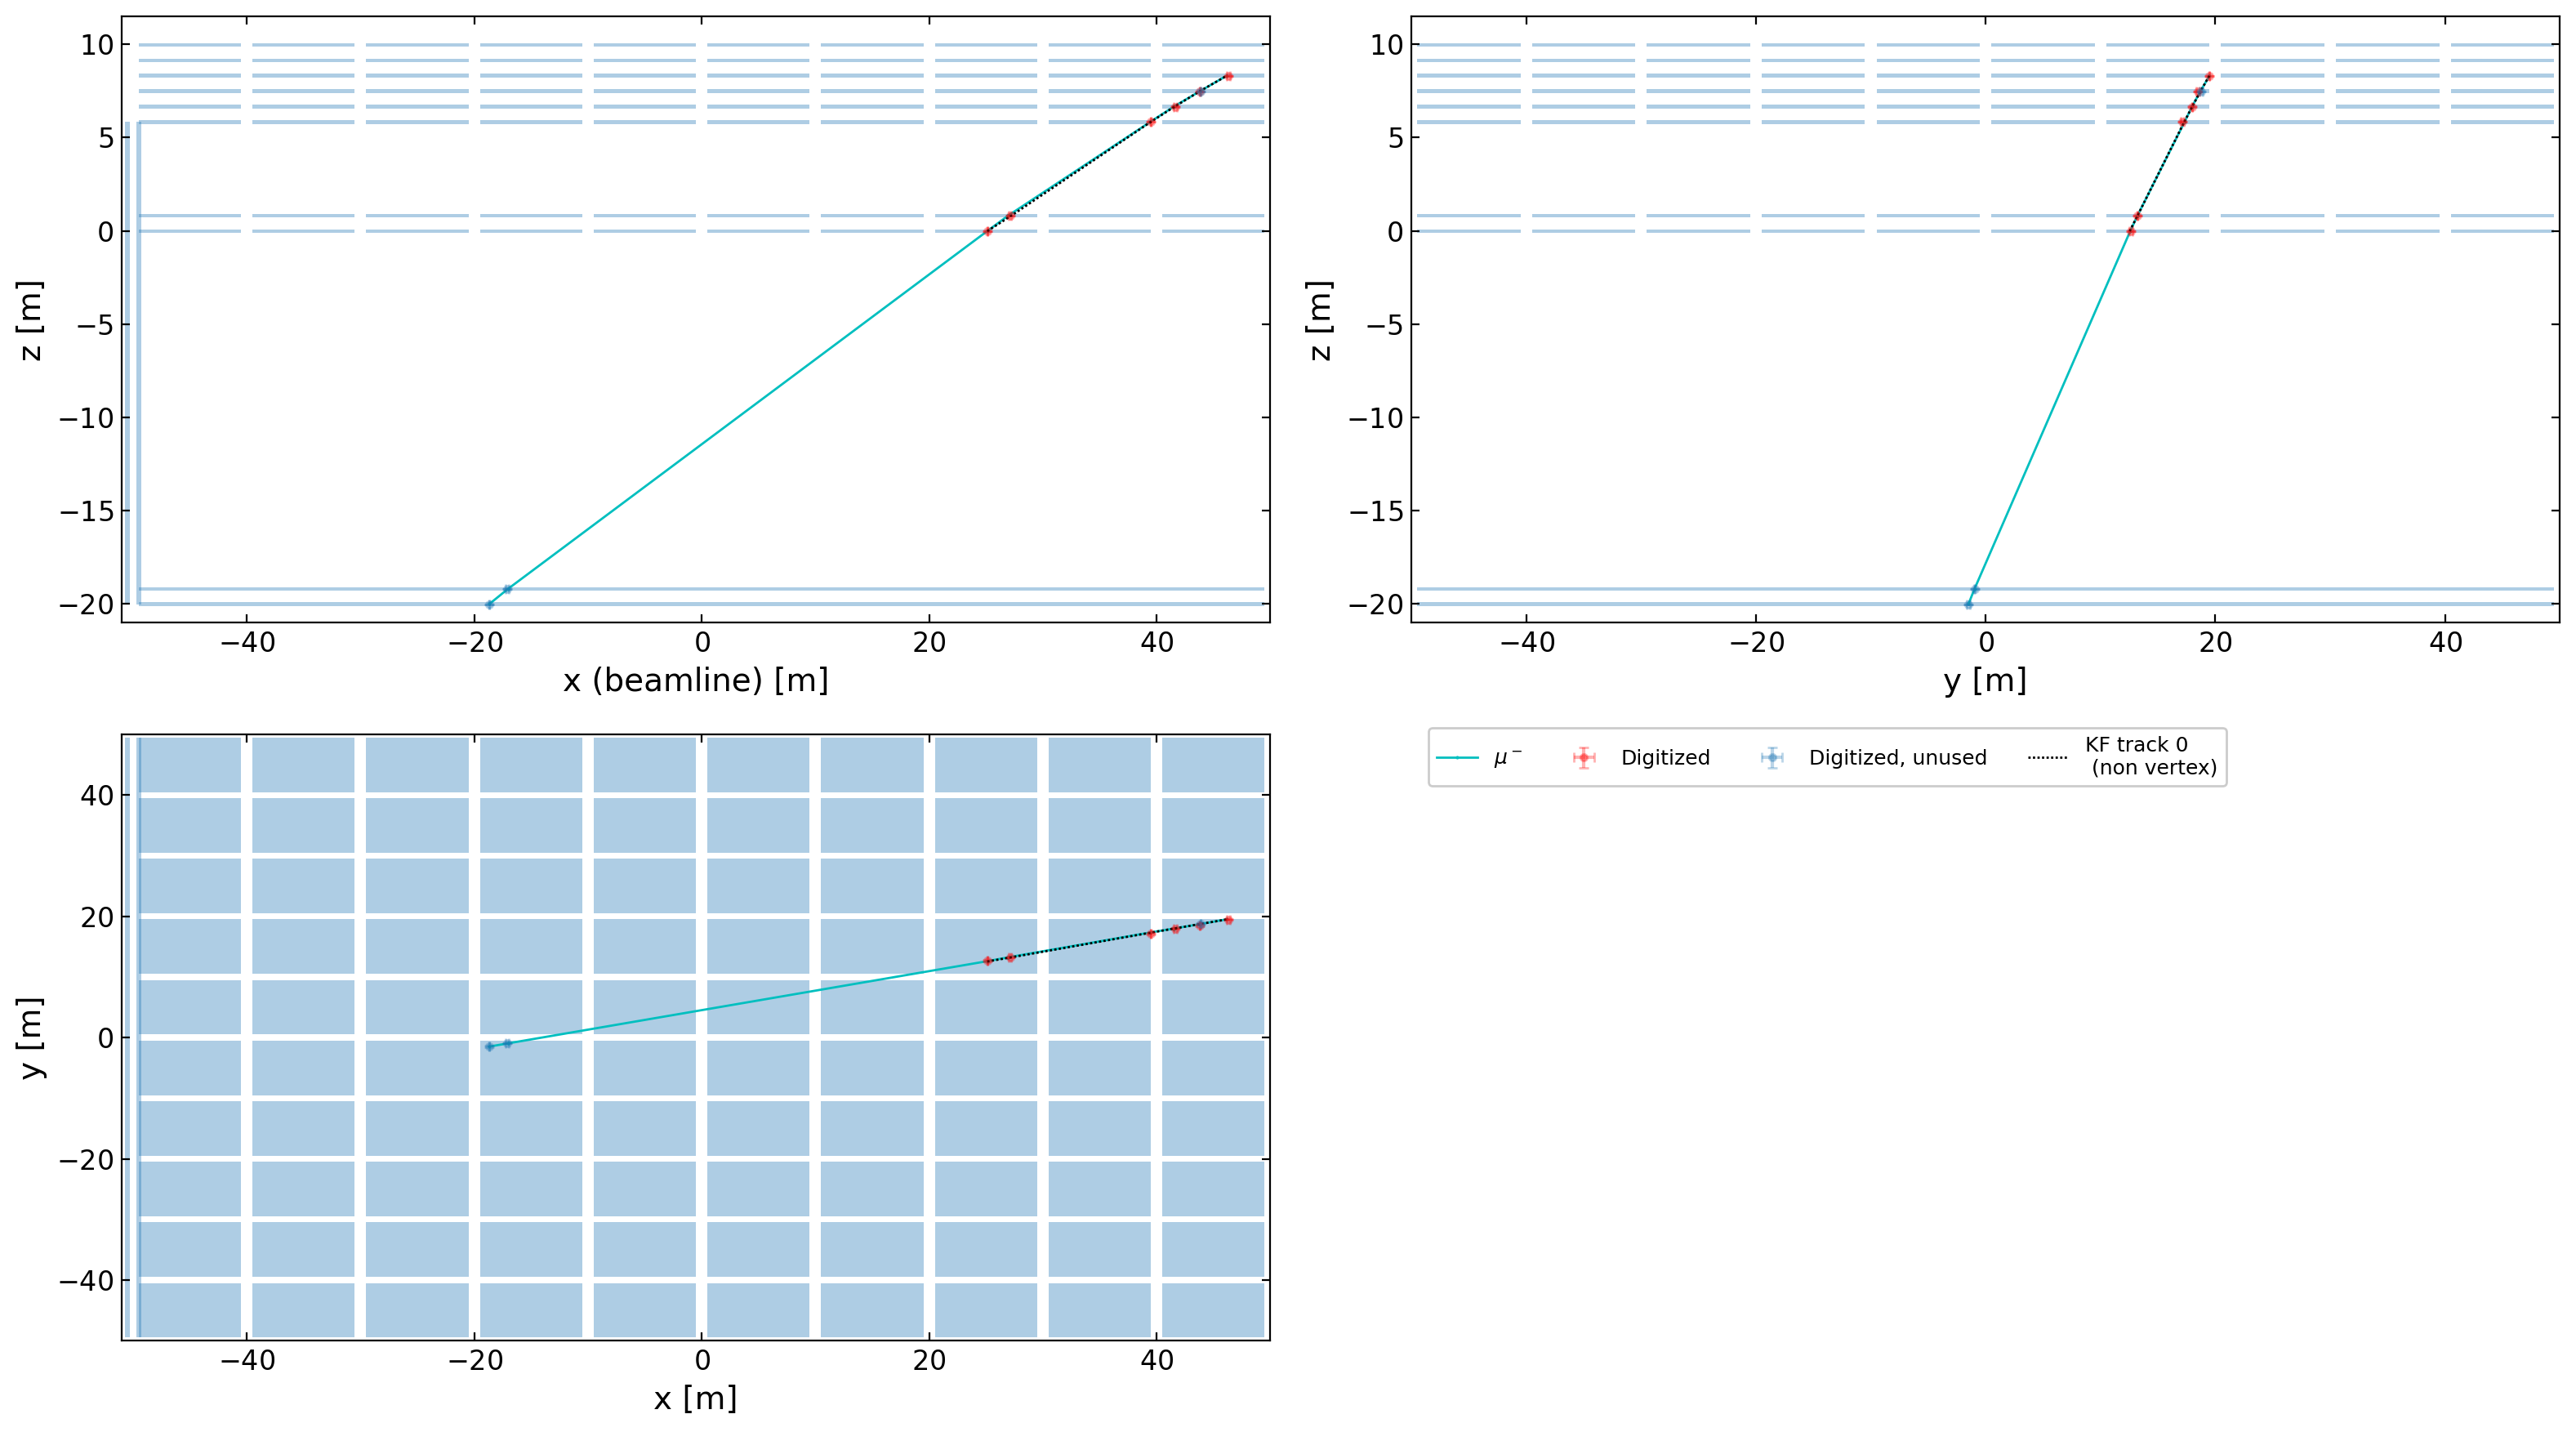

In [12]:

ev = event.Event(filename, 0)

# for i in range(50):
for i in inds_plot:
    print(f"===========================Event {i}==============================")
    ev.EventNumber=i
    ev.Tree.GetEntry(ev.EventNumber)
    if ev.Tree.Digi_x.size()<4:
        continue

    fig,axs=plt.subplots(2,2,figsize=(16,9))
    # fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
    # fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True);
    
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_filereader_vertex=True, disp_first_hit=False,make_legend=False);
    fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True,force_limit=True,make_legend=True, disp_vertex_track_extension=True);    
    # print(util.unzip(ev.Tree.Vertex_k_m_trackIndices))
    show()